# E2E-VIV Cryptographic Core Architecture Model

- Author: Joseph Kiniry
- Author: Daniel M. Zimmerman
- Copyright: Free & Fair, 2024-25
- Created: November 2024
- Revised: April 2025

## Introduction

This is a system architecture model for the cryptographic core of the family of E2E-VIV systems being developed for the [Free Democracy Foundation](https://freedemocracyfoundation.org) [mobile voting project](https://mobilevoting.org/). This model precisely describes the principals (subsystems, actors, and assets) involved, the trust zones and trust levels within the system, and the data flows among the principals and trust zones. 

As this is a model for a cryptographic library, not a full E2E-VIV system, several aspects of a full system (physical deployment of computers and networks, details about network communication beyond the high-level communication flows among principals) are not described. This model extends to the actor level (i.e., the users of the subsystems that incorporate the library), but our implementation of it will only extend to the message/API level (i.e., the library's interfaces to the subsystems in which it is used); this is discussed in more detail later. For brevity, rather than always saying "E2E-VIV cryptograpic core library", we refer to "the system" or "the E2E-VIV system" in the remainder of this model.

This model is written in a literate style using the SysML version 2 Pilot Implementation's Jupyter notebook-based interface.

In [1]:
package <E2E_VIV> 'End-to-End Verifiable Internet Voting Cryptographic Core' {
  // @design dmz SysMLv2 short names apparently can't contain dashes, so E2E_VIV instead of E2E-VIV.
  
  private import ScalarValues::*;

  doc /* 
    This is the SysML model for the E2E-VIV cryptographic core, including the system and network architecture, events, and scenarios.

    @author Joseph Kiniry
    @author Daniel M. Zimmerman
    @copyright 2024-25 Free & Fair
    @history Created November 2024, last revised February 2025
  */

  // @todo dmz define contents and encryption of message types

  // @design dmz this package is nearly empty; while we would ideally make the rest of the
  // packages defined below subpackages of this one, that is incompatible with the way
  // the Jupyter/SysMLv2 integration parses SysML (every cell must be a self-contained
  // SysMLv2 construct parsable in the context of the previously evaluated cells). It
  // remains to be seen whether we can actually write this outermost package usefully
  // with the Jupyter/SysMLv2 integration, or whether we'll need some external scripting
  // to assemble the packages defined in this notebook into a larger external package,
  // or whether we'll just leave it as-is.

  part def 'E2E-VIV System' {
    doc /* Important attributes of an E2E-VIV system. */

    attribute trusteeCount: Integer {
      doc /* The number of trustees. */
      assert constraint { trusteeCount >= 1 }
    }
    
    attribute voterCount: Integer {
      doc /* The number of voters. */
      assert constraint { voterCount >= 1 }
    }

    attribute ballotCheckApplicationCount: Integer {
      doc /* The number of ballot check applications. */
      assert constraint { ballotCheckApplicationCount >= 1 }
    }
    
    attribute verifierCount: Integer {
      doc /* The number of verifiers. */
      assert constraint { verifierCount >= 0 }
    }

    attribute printerCount: Integer {
      doc /* The number of ballot printers. */
      assert constraint { printerCount >= 0 }
    }
  }
}

Package <E2E_VIV> End-to-End Verifiable Internet Voting Cryptographic Core (f72ea0eb-e0e8-47a5-943c-9d5af9712038)


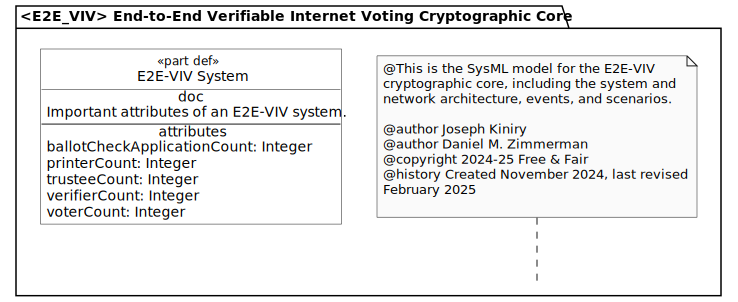

In [2]:
// @todo dmz figure out why this visualization doesn't work with "E2E_VIV"
%viz "End-to-End Verifiable Internet Voting Cryptographic Core"

## Background Concepts

Some background concepts, which are not explicitly defined in the domain model because they are commonly understood, must be defined explicitly so that they can be used within the system. We define those concepts in the following package.

In [3]:
package 'Background Concepts' {
  //* 
    This package defines background concepts that are needed explicitly for use in later definitions, but do not appear in the domain model because they are commonly-understood background concepts.
  */

  item def Identity {
    doc /* An Identity uniquely identifies a communicating part. For a human actor, an Identity might be comprised of multiple pieces of real-world identifying information such as a name, date of birth, registration number, driver's license information, passport information, etc.; for a software subsystem, an Identity might be a unique identifier based on the type of subsystem and other characteristics. The exact composition of an Identity will not be described in further detail here. */
  }

  part def Principal {
    doc /* A principal that communicates within the system. This can be a human actor or a software/hardware subsystem. */
      
    ref item id: Identity[1..*] {
      doc /* The principal's identity (if the principal is realized by more than one human, there may be more than one). */
    }
  }
}


Package Background Concepts (ea0f0426-26d0-476f-b637-025cef1e47f3)


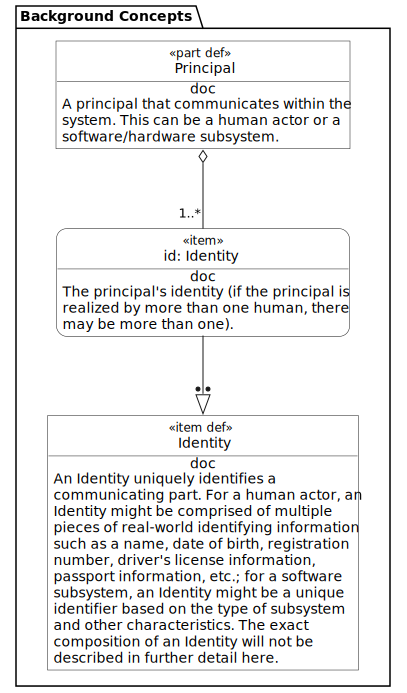

In [4]:
%viz "Background Concepts"

## Cryptography Concepts

Next, we define the concepts from the domain model of cryptography that are necessary for modeling the E2E-VIV system. Note that the domain model of cryptography defines many cryptographic concepts that are not relevant to the cryptographic algorithms and protocols implemented by the system, and we do not define those here.

In [5]:
package 'Cryptography' {
  // @design dmz it's not clear whether we'll need all of these cipher components
  
  part def Cipher {
    doc /* 
      An algorithm used in cryptography to convert plain text into encrypted text (ciphertext) by transforming individual characters or bits of information. Unlike codes, which substitute entire words or phrases, ciphers operate at a more granular level, manipulating letters, numbers, or binary data to obscure the original message. 
    */
  }

  part def 'Block Cipher' specializes Cipher {
    doc /* 
      A symmetric key encryption algorithm that processes data in fixed-size blocks with an unvarying transformation of plaintext into ciphertext using a secret key. Even a secure block cipher is suitable for the encryption of only a single block of data at a time, using a fixed key. A multitude of modes of operation have been designed to allow their repeated use in a secure way. Block ciphers also feature as building blocks in other cryptographic protocols, such as universal hash functions and pseudorandom number generators. 
    */
  }
  
  part def 'Stream Cipher' specializes Cipher {
    doc /* 
      A symmetric key encryption algorithm that encrypts plaintext data one bit or byte at a time, producing a continuous stream of ciphertext. Stream ciphers generate a pseudorandom keystream that is combined with the plaintext, typically using the XOR operation, to produce the ciphertext. The transformation of the plaintext into ciphertext is dependent on the state of the cipher in particular the keystream. 
    */
  }

  part def Mode {
    // @design dmz This might be better as an attribute than a part.
    doc /* 
      A block cipher by itself is only suitable for the secure cryptographic transformation (encryption or decryption) of one fixed-length group of bits called a block. A mode of operation describes how to repeatedly apply a cipher's single-block operation to securely transform amounts of data larger than a block. 
    */
  }
  
  part def Hash {
    doc /* 
      A mathematical algorithm that takes an input (or "message") and produces a fixed-size string of characters, known as the hash value or digest. It is designed to meet specific security properties of pre-image resistance, second pre-image resistance, and collision resistance.
    */
  }

  item def Nonce {
    doc /* 
      A time-varying value that has (at most) an acceptably small chance of repeating. For example, the nonce may be a random value that is generated anew for each use, a timestamp, a sequence number, or some combination of these.
    */
  }

  item def Key {
    doc /* 
      A string of data used with cryptographic algorithms to encrypt or decrypt data, authenticate messages, or verify digital signatures. Keys are categorized into symmetric keys, where the same key is used for both encryption and decryption, and asymmetric keys, which come in pairs (public and private) for digital signatures and secure key exchanges. Key security depends on effective management practices, including secure generation, storage, and distribution.
    */
  }
  
  item def 'Public Key' specializes Key {
    doc /* 
      A cryptographic key that is generated as part of a public key cryptography key pair. The public key can be used to encrypt messages or verify a digital signature. Importantly, it cannot be used to decrypt messages or create digital signatures. The security of the cryptosystem does not rely on the secrecy of the public key, and it is shared openly. 
    */
  }

  item def 'Private Key' specializes Key {
    doc /* 
      A cryptographic key that is generated as part of a public key cryptography key pair. The private key can be used to decrypt messages or create digital signatures. This security of the cryptosystem relies on the secrecy of the private key, and it is not shared. 
    */
  }
  
  part def ElGamal {
    doc /* 
      A probabilistic public-key cryptography algorithm based on the intractability of the Decisional Diffie–Hellman assumption. ElGamal is an extension of the Diffie–Hellman Key Exchange. The algorithm can be described as performing a Diffie–Hellman key exchange to establish a shared secret then using the secret as a one-time pad for encrypting a message. ElGamal encryption is malleable, and is therefore not secure against chosen ciphertext attacks.
    */
  }
  
  part def <MixNet> 'Mix Network' {
    doc /* 
      A data routing protocol that creates hard-to-trace communications by using a chain of mix node servers. Each message is encrypted by the sender first with the public key of the final mix node then with the public key of the next to last mix node and so on until the message is encrypted with the public key of the first mix node. Mix nodes take in messages from multiple senders, shuffle them, decrypt the outermost layer of encryption, and send them back out in random order to the next destination (possibly another mix node). This breaks the link between the source of the message and the destination. Each mix node only knows the node that it immediately received the message from, and the immediate destination to send the shuffled messages to, making the network resistant to malicious mix nodes.
    */
  }
}

Package Cryptography (40818ab6-cd03-43f2-822f-481b5a627ea9)


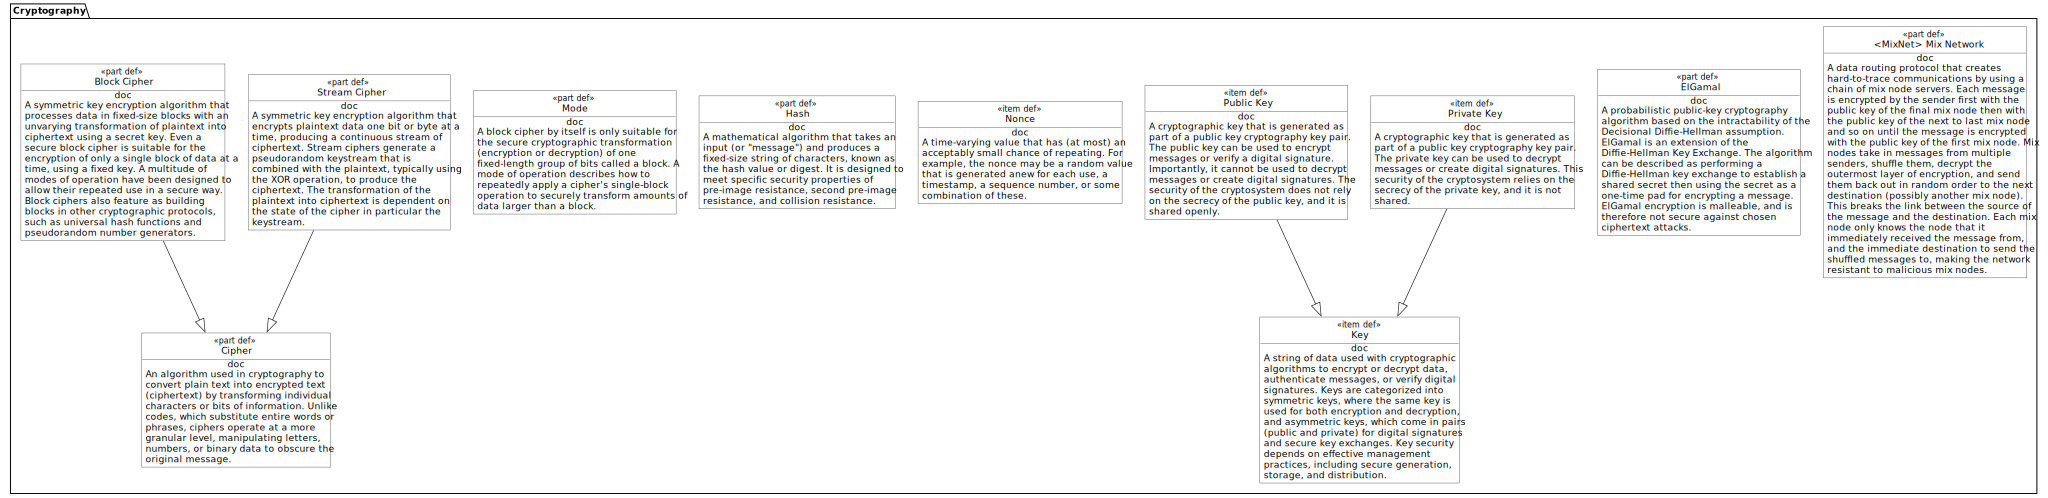

In [6]:
%viz Cryptography

## Election Concepts

Having defined our basic cryptographic concepts, we define the concepts from the domain model of elections that are necessary for the SysML model. Note that the domain model of elections defines many concepts that are not relevant to the cryptographic library, including those related to elections at a political or societal level, etc., and we do not define those here.

In [7]:
package 'Elections' {
  private import 'End-to-End Verifiable Internet Voting Cryptographic Core'::*;
  private import ScalarValues::*;
  private import Collections::KeyValuePair;
  private import Collections::Map;
  private import Collections::OrderedSet;
  private import CollectionFunctions::size;
  private import 'Background Concepts'::*;
  
  // @todo dmz translate these and make sure they're all we need
  //* 
    @design dmz Some of the concepts in the domain model of elections, such as
    Voter and Election Official, are implemented in the 'Actors' package, 
    below, rather than in this package.
  */

  part e2eviv: 'E2E-VIV System';
  
  attribute def ContestChoiceAndTallyPair specializes KeyValuePair {
    doc /* 
      A key-value pair where the key is a contest choice and the value is a tally of votes for that choice. This is used to store contest results. 
    */
    
    ref part key: 'Contest Choice' :>> KeyValuePair::key;
    ref attribute val: Integer :>> KeyValuePair::val;
  }

  attribute def ContestChoiceToTallyMap specializes Map {
    doc /* A mapping from contest choices to tallies. */
      
    attribute elements: ContestChoiceAndTallyPair[0..*] :>> Map::elements;
  }

  part def Contest {
    doc /* 
      A single decision or set of associated decisions being put before the voters (for example, the option of candidates to fill a particular public office or the approval or disapproval of a constitutional amendment). This term encompasses other terms such as "race," "question," and "issue" that are sometimes used to refer to specific kinds of contests. It does not refer to the legal challenge of an election outcome. 
    */

    attribute numChoices: Integer;
    ref part choices: 'Contest Choice'[1..numChoices];
    attribute writeInAllowed: Boolean;
    attribute maxChoices: Integer;
    attribute result: ContestChoiceToTallyMap;

    assert constraint reasonableMaxChoices {
      (0 < maxChoices) & (maxChoices <= numChoices)
    }

    // @todo dmz the following constraint generates warnings about 
    // conforming types, but I don't understand why
    assert constraint reasonableResultSize {
        (writeInAllowed & (numChoices <= size(result)))
      |
        (not writeInAllowed & (numChoices == size(result)))
    }

    // @todo dmz determine how/if to implement "Does the vote contain valid choices for you?"
  }

  part def 'Contest Choice' {
    doc /* A votable choice that appears under a contest. */
  }

  attribute def ChoiceSet specializes OrderedSet {
    doc /* 
      A set of contest choices. It is ordered so that it can be used for ranked choice systems. 
    */

    ref part elements: 'Contest Choice'[0..*] :>> OrderedSet::elements;
  }

  attribute def ContestContestChoicesPair specializes KeyValuePair {
    doc /*
      A key-value pair where the key is a contest and the value is a set of contest choices. This records voter choices on a ballot.
    */

    ref part key: 'Contest' :>> KeyValuePair::key;
    ref attribute val: ChoiceSet :>> KeyValuePair::val;
  }

  attribute def ContestToContestChoicesMap specializes Map {
    doc /* A mapping from contests to ordered sets of contest choices. */

    attribute elements: ContestContestChoicesPair[0..*] :>> Map::elements;
  }

  attribute def 'Contest Presentation' {
    doc /*
      Implementation-dependent details about the presentation of a particular contest.
    */
  }

  attribute def ContestContestPresentationPair specializes KeyValuePair {
    doc /*
      A key-value pair where the key is a contest and the value is information about its presentation to the voter.
    */

    ref part key: 'Contest' :>> KeyValuePair::key;
    ref attribute val: 'Contest Presentation' :>> KeyValuePair::val;
  }

  attribute def ContestToContestPresentationMap specializes Map {
    doc /* A mapping from contests to their presentations. */

    attribute elements: ContestContestPresentationPair[0..*] :>> Map::elements;
  }
  
  part def Ballot {
    doc /* 
      Presentation of the contest options for a particular voter. This SysML part refines Ballot Configuration and Ballot Style as well, by containing an ordered list of contests and their (abstracted) ballot presentation information.
    */

    attribute numContests: Integer;
    ref part contests: Contest[1..numContests];
    attribute contestPresentations: ContestToContestPresentationMap[1..*];
    attribute contestChoices: ContestToContestChoicesMap[1..*];

    assert constraint numberOfContests {
        numContests > 0 
      & numContests == size(contestPresentations) 
      & numContests == size(contestChoices)
    }

    state ballotState {
      //* @design dmz This is one way to model legitimate state transitions in 
          SysML, and it can be used to constrain when transitions are allowed
          to occur, but it cannot - as far as I know - be used to model what
          data structure transformations are allowed at what states (as is 
          necessary in, e.g., the voters' register where contest presentations
          for a voter can't change if the voter has already voted). */
      
      entry action initial;
      
      state unmarked;
      state marked;
      state cast;
      state spoiled;
      
      transition initial then unmarked;
      transition 'markBallot' first unmarked then marked;
      transition 'castBallot' first marked then cast;
      transition 'spoilBallot' first marked then spoiled;
    }
  }

  attribute def VotersRegisterEntry {
    doc /*
      A single entry in the voters' registry contains information about a voter's identity, their ballot configuration, and their participation status.
    */

    ref part voter: Identity;
    attribute contestPresentations: ContestToContestPresentationMap[0..*];

    state participationState {
      entry action initial;

      state not_participated;
      state participated;

      transition initial then not_participated;
      transition 'vote' first not_participated then participated;
    }

    // @todo constraint about contest presentations not changing in the participated state
  }
     
  part def 'Voters Register' {
    doc /*
      A voters' register contains all the voters eligible to vote in an election, as well as information indicating the ballot configuration each voter should use and whether each has participated in the election.
    */

    // @design dmz using "e2eviv.voterCount" directly in the multiplicity
    // below doesn't seem to work, hence "voterCount" as an attribute here
    attribute voterCount: Integer = e2eviv.voterCount;
    attribute entries: VotersRegisterEntry[0..voterCount];
    // @todo constraint about uniqueness of identities in entry list
    // @todo constraint about not removing voters who have voted from the registry
  }
    
  part def 'Election Manifest' {
    doc /*
      The election manifest contains all important information about the election, including the contests, the voters' register, the list of trustees' identities, the required threshold of trustees, and the election's public key.
    */

    ref part contests: Contest[0..*];
    ref part votersRegister: 'Voters Register';
    // @design dmz using "e2eviv.trusteeCount" directly in the multiplicity 
    //  below doesn't seem to work, hence "trusteeCount" as an attribute here
    attribute trusteeCount: Integer = e2eviv.trusteeCount;
    ref part trustees: Identity[1..trusteeCount];
    attribute trusteeThreshold: Integer;
    ref item electionPublicKey: Cryptography::'Public Key';

    assert constraint validTrusteeThreshold {
      //@ design dmz "e2eviv.trusteeCount" _does_ work here, but for
      //  consistency we use the local one
      trusteeThreshold <= trusteeCount
    }
  }
}

Package Elections (60a29fa4-7c93-4d8e-9526-36f05c06598e)


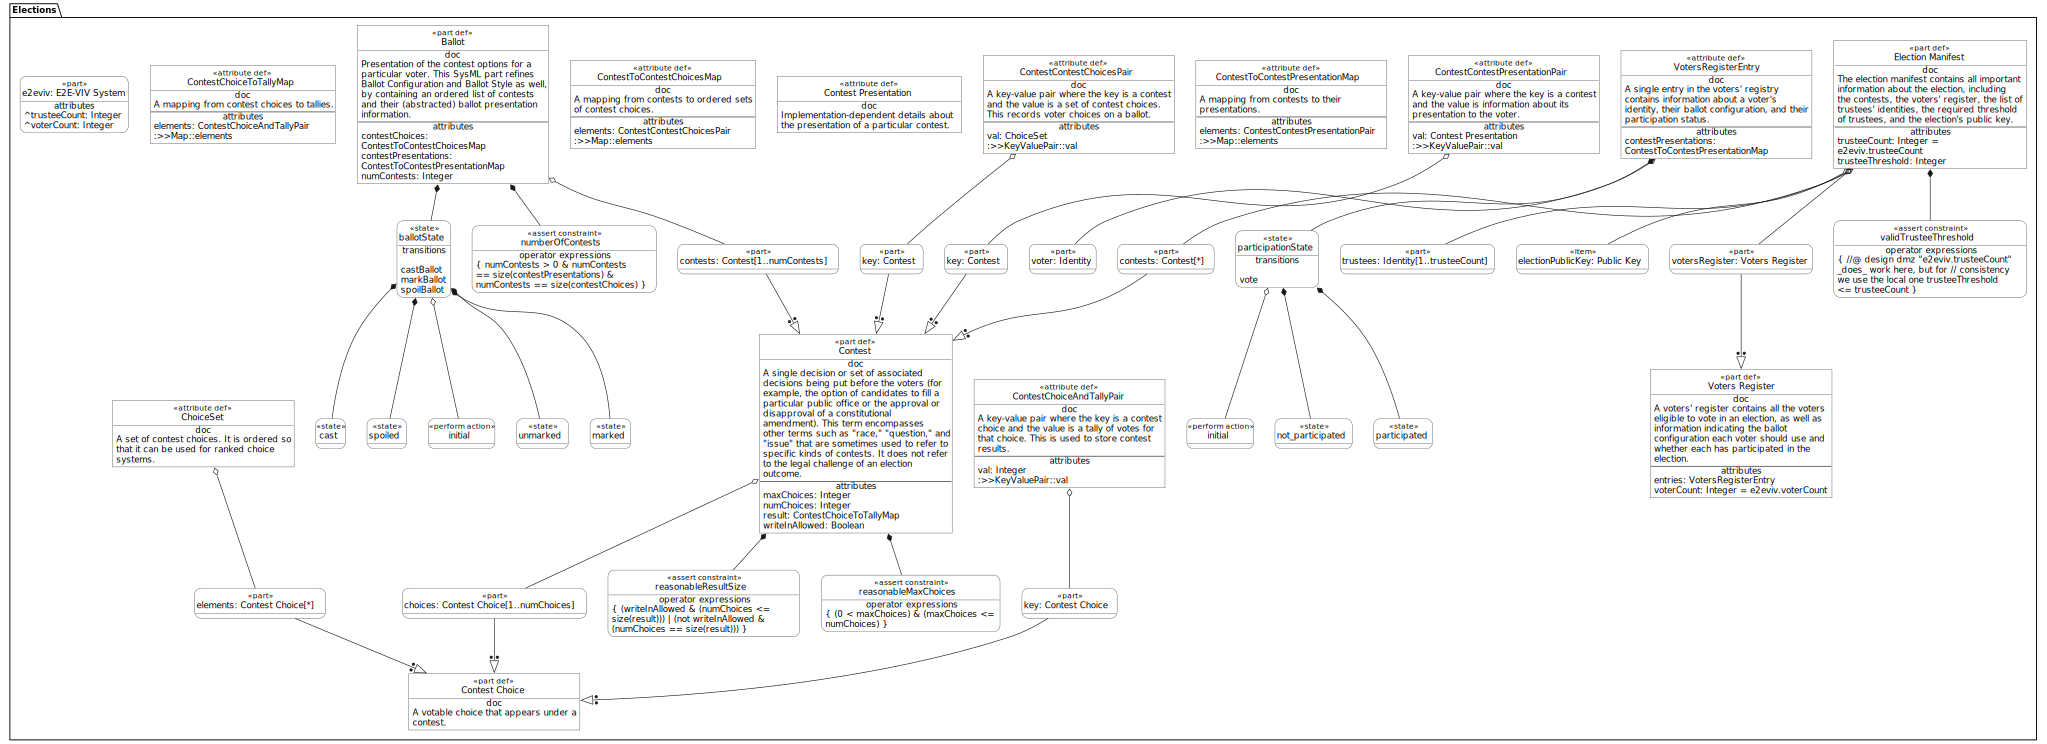

In [8]:
%viz --view=TREE Elections

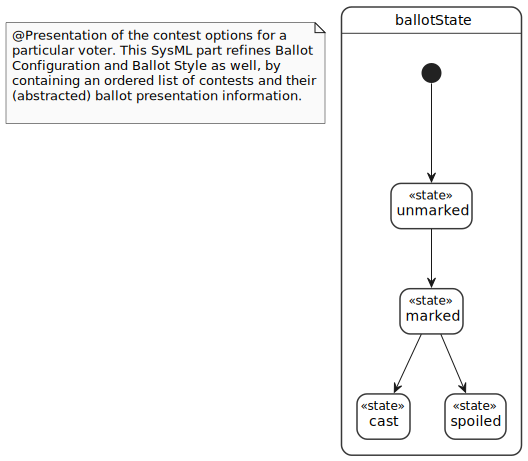

In [9]:
%viz --view=STATE Elections::Ballot

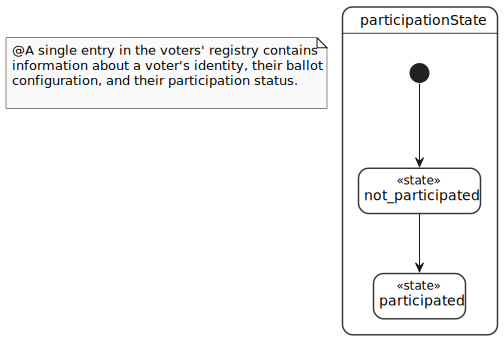

In [10]:
%viz --view=STATE Elections::'VotersRegisterEntry'

## Messages and Ports

We define the message and port types for the system in a package of their own, because they are necessary for defining the the actors and subsystems, and only defining them alongside their sending actors or subsystems would result in circular dependencies. The message and port types correspond to the events in [events.lando](https://github.com/FreeAndFair/TuskMobileVoting/blob/main/models/domain-model/lando/events.lando); we will also define SysMLv2 events bsaed on these types, for defining protocol sequences and generating the associated diagrams.

Note that, for brevity, we only define an _output_ port type for each message type and rely on port conjugation in later part definitions for the corresponding input port.

In [11]:
package 'Messaging' {
  //* 
    This package defines the message types and port types used for interaction within the system. We only define an output port type for each message type, and rely on port conjugation for the corresponding input port. 
  */

  private import 'Background Concepts'::*;
  
  item def Message {
    doc /* A message sent within the system. The only required content of a message is the (purported) Identity of its sender. A message sent with no recipient addresses is assumed to be broadcast to the entire trust zone it's sent within (in practical terms, it's assumed to be sent to every recipient that can receive a message of that type). */

    item sender: Identity;
    item recipients: Identity[0..*];
  }

  // Messages sent by actors, and their associated ports
  package 'Election Administrator Messaging' {
    //* 
      This subpackage defines the message types sent by the Election Administrator and their accompanying port types.
    */
  
    item def 'Load Election Manifest' specializes Message {
      doc /*
        The message sent by the Election Administrator to load the election manifest into the Election Administration Server.
      */

      ref part electionManifest: Elections::'Election Manifest';
    }
  
    port def 'Load Election Manifest Port' {
      doc /*
        The port used to send Load Election Manifest messages.
      */
      out item msg: 'Load Election Manifest';
    }
  
    item def 'Start Key Generation Ceremony' specializes Message {
      doc /*
        The message sent by the Election Administrator to load the election manifest into the Trustee Administration Server and start the key generation ceremony.
      */
    }
  
    port def 'Start Key Generation Ceremony Port' {
      doc /*
        The port used to send Start Key Generation Ceremony messages.
      */
      out item msg: 'Start Key Generation Ceremony';
    }
  
    item def 'Gather Election Data' specializes Message {
      doc /*
        The message sent by the Election Administrator to gather the election data from the Election Administration Server.
      */
    }
  
    port def 'Gather Election Data Port' {
      doc /*
        The port used to send Gather Election Data messages.
      */
      out item msg: 'Gather Election Data';
    }
  
    item def 'Start Ballot Decryption Ceremony' specializes Message {
      doc /*
        The message sent by the Election Administrator to load the election data into the Trustee Administration Server and start the ballot decryption ceremony.
      */
    }
  
    port def 'Start Ballot Decryption Ceremony Port' {
      doc /*
        The port used to send Start Ballot Decryption Ceremony messages.
      */
      out item msg: 'Start Ballot Decryption Ceremony';
    }
  
    item def 'Start Homomorphic Tally Ceremony' specializes Message {
      doc /*
        The message sent by the Election Administrator to load the election data into the Trustee Administration Server and start the homomorphic tally ceremony.
      */
    }
  
    port def 'Start Homomorphic Tally Ceremony Port' {
      doc /*
        The port used to send Start Homomorphic Tally Ceremony messages.
      */
      out item msg: 'Start Homomorphic Tally Ceremony';
    }
  
    item def 'Load Election Results' specializes Message {
      doc /*
        The message sent by the Election Administrator to load the election results into the Election Administration Server.
      */
    }
  
    port def 'Load Election Results Port' {
      doc /*
        The port used to send Load Election Results messages.
      */
      out item msg: 'Load Election Results';
    }
  }
  // end of Election Administrator Messaging
  
  package 'Trustee Messaging' {
    //* 
      This subpackage defines the message types sent by the Trustees and their accompanying port types.
    */

    item def 'Generate Key' specializes Message {
      doc /*
        The message sent by a Trustee to indicate that they have attached a storage device to a Trustee Application and signed in to the key generation process.
      */
    }
  
    port def 'Generate Key Port' {
      doc /*
        The port used to send Generate Key messages.
      */
      out item msg: 'Generate Key';
    }
  
    item def 'Load Key' specializes Message {
      doc /*
        The message sent by a Trustee to indicate that they have attached a storage device to a Trustee Application to load the private key material generated during the key generation process.
      */
    }
  
    port def 'Load Key Port' {
      doc /*
        The port used to send Load Key messages.
      */
      out item msg: 'Load Key';
    }
  
    item def 'Approve Shuffle' specializes Message {
      doc /*
        The message sent by a Trustee to provide approval to begin the shuffle computation based on consensus among the Trustees that the set of ballots is legitimate.
      */
    }
  
    port def 'Approve Shuffle Port' {
      doc /*
        The port used to send Approve Shuffle messages.
      */
      out item msg: 'Approve Shuffle';
    }
  
    item def 'Approve Tally' specializes Message {
      doc /*
        The message sent by a Trustee to provide approval to begin the homomorphic tally based on consensus among the Trustees that the set of ballots is legitimate.
      */
    }
  
    port def 'Approve Tally Port' {
      doc /*
        The port used to send Approve Tally messages.
      */
      out item msg: 'Approve Tally';
    }
  
    item def 'Approve Decryption' specializes Message {
      doc /*
        The message sent by a Trustee to provide approval to decrypt the shuffled ballots and/or the homomorphic tally.
      */
    }
  
    port def 'Approve Decryption Port' {
      doc /*
        The port used to send Approve Decryption messages.
      */
      out item msg: 'Approve Decryption';
    }
  }
  // end of Trustee Messaging
  
  package 'Verifier Messaging' {
    //* 
      This subpackage defines the message types sent by the Verifier and their accompanying port types.
    */
  
    item def 'Request Election Data' specializes Message {
      doc /*
        The message sent by a Verifier to request election data from the Public Bulletin Board.
      */
    }
  
    port def 'Request Election Data Port' {
      doc /*
        The port used to send Request Election Data messages.
      */
      out item msg: 'Request Election Data';
    }
  
    item def 'Report Results' specializes Message {
      doc /*
        The message sent by a Verifier to publicly report the results of the verification they have carried out on Public Bulletin Board data.
      */
    }
  
    port def 'Report Results Port' {
      doc /*
        The port used to send Report Results messages.
      */
      out item msg: 'Report Results';
    }
  }
  // end of Verifier Messaging
  
  package 'Voter Messaging' {
    //* 
      This subpackage defines the message types sent by the Voter actor and their accompanying port types.
    */
  
    item def 'Sign In' specializes Message {
      doc /*
        The message sent by a Voter to sign into the Voting Application.
      */
    }
  
    port def 'Sign In Port' {
      doc /*
        The port used to send Sign In messages.
      */
      out item msg: 'Sign In';
    }
  
    item def 'Authentication' specializes Message {
      doc /*
        The message sent by a Voter to authenticate to the Authentication Service.
      */
    }
  
    port def 'Authentication Port' {
      doc /*
        The port used to send Authentication messages.
      */
      out item msg: 'Authentication';
    }
  
    item def 'Confirm Choices' specializes Message {
      doc /*
        The message sent by a Voter to the Voting Application to confirm their choices on a ballot they are voting. This message is an abstraction of the user interface interactions between a Voter and the Voting Application during the selection process, which we are not modeling in detail.
      */
    }
  
    port def 'Confirm Choices Port' {
      doc /*
        The port used to send Confirm Choices messages.
      */
      out item msg: 'Confirm Choices';
    }
  
    item def 'Ballot Check Initiation' specializes Message {
      doc /*
        The message sent by a Voter to the Voting Application to initiate a ballot check.
      */
    }
  
    port def 'Ballot Check Initiation Port' {
      doc /*
        The port used to send Ballot Check Initiation messages.
      */
      out item msg: 'Ballot Check Initiation';
    }
  
    item def 'Ballot Check Application Start' specializes Message {
      doc /*
        The message sent by a Voter to the Ballot Check Application to start a ballot check.
      */
    }
  
    port def 'Ballot Check Application Start Port' {
      doc /*
        The port used to send Ballot Check Application Start messages.
      */
      out item msg: 'Ballot Check Application Start';
    }
  
    item def 'Ballot Check Confirmation' specializes Message {
      doc /*
        The message sent by a Voter to confirm that the ballot check information shown by the Voting Application matches that shown by the Ballot Check Application.
      */
    }
  
    port def 'Ballot Check Confirmation Port' {
      doc /*
        The port used to send Ballot Check Confirmation messages.
      */
      out item msg: 'Ballot Check Confirmation';
    }
  
    item def 'Ballot Check Mismatch' specializes Message {
      doc /*
        The message sent by a Voter to report a mismatch between the ballot check information shown by the Voting Application and that shown by the Ballot Check Application.
      */
    }
  
    port def 'Ballot Check Mismatch Port' {
      doc /*
        The port used to send Ballot Check Mismatch messages.
      */
      out item msg: 'Ballot Check Mismatch';
    }
  
    item def 'Decrypted Ballot Confirmation' specializes Message {
      doc /*
        The message sent by a Voter to confirm that the decrypted ballot information displayed by the Ballot Check Application matches the Voter's choices.
      */
    }
  
    port def 'Decrypted Ballot Confirmation Port' {
      doc /*
        The port used to send Decrypted Ballot Confirmation messages.
      */
      out item msg: 'Decrypted Ballot Confirmation';
    }
  
    item def 'Decrypted Ballot Mismatch' specializes Message {
      doc /*
        The message sent by a Voter to report that the decrypted ballot information displayed by the Ballot Check Application does not match the Voter's choices.
      */
    }
  
    port def 'Decrypted Ballot Mismatch Port' {
      doc /*
        The port used to send Decrypted Ballot Mismatch messages.
      */
      out item msg: 'Decrypted Ballot Mismatch';
    }
  
    item def 'Ballot Cast' specializes Message {
      doc /*
        The message sent by a Voter to cast a ballot on which they have confirmed their choices.
      */
    }
  
    port def 'Ballot Cast Port' {
      doc /*
        The port used to send Ballot Cast messages.
      */
      out item msg: 'Ballot Cast';
    }
  }
  // end of Voter Messaging
  
  package 'Authentication Service Messaging' {
    //* 
      This subpackage defines the message types sent by the Authentication Service and their accompanying port types.
    */
  
    item def 'Initiate Voter Authentication' specializes Message {
      doc /*
        The message sent by the Authentication Service to initiate authentication with the voter.
      */
    }
  
    port def 'Initiate Voter Authentication Port' {
      doc /*
        The port used to send Initiate Voter Authentication messages.
      */
      out item msg: 'Initiate Voter Authentication';
    }
  
    item def 'Authentication Result' specializes Message {
      doc /*
        The message sent by the Authentication Service to provide an authentication result to the Election Administration Server.
      */
    }
  
    port def 'Authentication Result Port' {
      doc /*
        The port used to send Authentication Result messages.
      */
      out item msg: 'Authentication Result';
    }
  }
  // end of Authentication Service Messaging
  
  package 'Ballot Check Application Messaging' {
    //* 
      This subpackage defines the message types sent by the Ballot Check Application and their accompanying port types.
    */
  
    item def 'Request Ballot Information' specializes Message {
      doc /*
        The message sent by the Ballot Check Application to request ballot information from the digital ballot box.
      */
    }
  
    port def 'Request Ballot Information Port' {
      doc /*
        The port used to send Request Ballot Information messages.
      */
      out item msg: 'Request Ballot Information';
    }
  
    item def 'Show Ballot Check Information' specializes Message {
      doc /*
        The message sent by the Ballot Check Application to display ballot check information to the voter. This information can be used to validate that the ballot check and voting applications are referring to the same ballot.
      */
    }
  
    port def 'Show Ballot Check Information Port' {
      doc /*
        The port used to send Show Ballot Check Information messages.
      */
      out item msg: 'Show Ballot Check Information';
    }
  
    item def 'Show Decrypted Ballot' specializes Message {
      doc /*
        The message sent by the Ballot Check Application to display a decrypted ballot to the voter.
      */
    }
  
    port def 'Show Decrypted Ballot Port' {
      doc /*
        The port used to send Show Decrypted Ballot messages.
      */
      out item msg: 'Show Decrypted Ballot';
    }
  }
  // end of Ballot Check Application Messaging

  package 'Digital Ballot Box Messaging' {
    //* 
      This subpackage defines the message types sent by the Digital Ballot Box and their accompanying port types.
    */
  
    item def 'Initial Ballot Check Information' specializes Message {
      doc /*
        The message sent by the Digital Ballot Box to provide initial ballot check information for a voted ballot to the Voting Application.
      */
    }
  
    port def 'Initial Ballot Check Information Port' {
      doc /*
        The port used to send Initial Ballot Check Information messages.
      */
      out item msg: 'Initial Ballot Check Information';
    }
  
    item def 'Ballot Check Information BCA' specializes Message {
      doc /*
        The message sent by the Digital Ballot Box to provide additional ballot check information to a Ballot Check Application as part of the ballot check process.
      */
    }
  
    port def 'Ballot Check Information BCA Port' {
      doc /*
        The port used to send Ballot Check Information BCA messages.
      */
      out item msg: 'Ballot Check Information BCA';
    }
  
    item def 'Ballot Check Information VA' specializes Message {
      doc /*
        The message sent by the Digital Ballot Box to provide ballot check information to the Voting Application as part of the ballot check process.
      */
    }
  
    port def 'Ballot Check Information VA Port' {
      doc /*
        The port used to send Ballot Check Information VA messages.
      */
      out item msg: 'Ballot Check Information VA';
    }
  
    item def 'Publish Ballot Cryptogram' specializes Message {
      doc /*
        The message sent by the Digital Ballot Box to publish a ballot cryptogram containing voting choices to the public bulletin board.
      */
    }
  
    port def 'Publish Ballot Cryptogram Port' {
      doc /*
        The port used to send Publish Ballot Cryptogram messages.
      */
      out item msg: 'Publish Ballot Cryptogram';
    }
  
    item def 'Publish Spoil Request' specializes Message {
      doc /*
        The message sent by the Digital Ballot Box to publish a spoil request for a ballot to the public bulletin board.
      */
    }
  
    port def 'Publish Spoil Request Port' {
      doc /*
        The port used to send Publish Spoil Request messages.
      */
      out item msg: 'Publish Spoil Request';
    }
  
    item def 'Publish Cast Request' specializes Message {
      doc /*
        The message sent by the Digital Ballot Box to publish a cast request for a ballot to the public bulletin board.
      */
    }
  
    port def 'Publish Cast Request Port' {
      doc /*
        The port used to send Publish Cast Request messages.
      */
      out item msg: 'Publish Cast Request';
    }
  
    item def 'Publish Ballot Check Information' specializes Message {
      doc /*
        The message sent by the Digital Ballot Box to publish ballot check information to the public bulletin board.
      */
    }
  
    port def 'Publish Ballot Check Information Port' {
      doc /*
        The port used to send Publish Ballot Check Information messages.
      */
      out item msg: 'Publish Ballot Check Information';
    }
  
    item def 'Publish Election Manifest' specializes Message {
      doc /*
        The message sent by the Digital Ballot Box to publish the election manifest to the public bulletin board, starting an election.
      */
    }
  
    port def 'Publish Election Manifest Port' {
      doc /*
        The port used to send Publish Election Manifest messages.
      */
      out item msg: 'Publish Election Manifest';
    }
  
    item def 'Publish Election Results' specializes Message {
      doc /*
        The message sent by the Digital Ballot Box to publish election results to the public bulletin board, ending an election.
      */
    }
  
    port def 'Publish Election Results Port' {
      doc /*
        The port used to send Publish Election Results messages.
      */
      out item msg: 'Publish Election Results';
    }
  
    item def 'Election Data' specializes Message {
      doc /*
        The message sent by the Digital Ballot Box to provide election data to the Election Administration Server.
      */
    }
  
    port def 'Election Data Port' {
      doc /*
        The port used to send Election Data messages.
      */
      out item msg: 'Election Data';
    }
  }
  // end of Digital Ballot Box Messaging

  package 'Election Administration Server Messaging' {
    //* 
      This subpackage defines the message types sent by the Election Administration Server and their accompanying port types.
    */
  
    item def 'Request Voter Authentication' specializes Message {
      doc /*
        The message sent by the Election Administration Server to request voter authentication for a specific voter from an authentication service.
      */
    }
  
    port def 'Request Voter Authentication Port' {
      doc /*
        The port used to send Request Voter Authentication messages.
      */
      out item msg: 'Request Voter Authentication';
    }
  
    item def 'Available Elections' specializes Message {
      doc /*
        The message sent by the Election Administration Server to provide information about the election(s) available to a specific voter to the Voting Application, or to inform that authentication failed.
      */
    }
  
    port def 'Available Elections Port' {
      doc /*
        The port used to send Available Elections messages.
      */
      out item msg: 'Available Elections';
    }
  
    item def 'Write Election Manifest' specializes Message {
      doc /*
        The message sent by the Election Administration Server to write the election manifest to a persistent storage device.
      */
    }
  
    port def 'Write Election Manifest Port' {
      doc /*
        The port used to send Write Election Manifest messages.
      */
      out item msg: 'Write Election Manifest';
    }
  
    item def 'Publish Election Manifest' specializes Message {
      doc /*
        The message sent by the Election Administration Server to publish the election manifest.
      */
    }
  
    port def 'Publish Election Manifest Port' {
      doc /*
        The port used to send Publish Election Manifest messages.
      */
      out item msg: 'Publish Election Manifest';
    }
  
    item def 'Write Election Data' specializes Message {
      doc /*
        The message sent by the Election Administration Server to write all election data to a persistent storage device.
      */
    }
  
    port def 'Write Election Data Port' {
      doc /*
        The port used to send Write Election Data messages.
      */
      out item msg: 'Write Election Data';
    }
  
    item def 'Request Election Data' specializes Message {
      doc /*
        The message sent by the Election Administration Server to request all election data from the Digital Ballot Box.
      */
    }
  
    port def 'Request Election Data Port' {
      doc /*
        The port used to send Request Election Data messages.
      */
      out item msg: 'Request Election Data';
    }
  
    item def 'Publish Election Results' specializes Message {
      doc /*
        The message sent by the Election Administration Server to publish the election results.
      */
    }
  
    port def 'Publish Election Results Port' {
      doc /*
        The port used to send Publish Election Results messages.
      */
      out item msg: 'Publish Election Results';
    }
  }
  // end of Election Administration Server Messaging

  package 'Public Bulletin Board Messaging' {
    //* 
      This subpackage defines the message types sent by the Public Bulletin Board and their accompanying port types.
    */
  
    item def 'All Election Data' specializes Message {
      doc /*
        The message sent by the Public Bulletin Board to provide all the election data it has in response to a request.
      */
    }
  
    port def 'All Election Data Port' {
      doc /*
        The port used to send All Election Data messages.
      */
      out item msg: 'All Election Data';
    }
  
    item def 'Selected Election Data' specializes Message {
      doc /*
        The message sent by the Public Bulletin Board to provide selected election data in response to a request.
      */
    }
  
    port def 'Selected Election Data Port' {
      doc /*
        The port used to send Selected Election Data messages.
      */
      out item msg: 'Selected Election Data';
    }
  }
  // end of Public Bulletin Board Messsaging
  
  package 'Trustee Application Messaging' {
    //* 
      This subpackage defines the message types sent by the Trustee Application and their accompanying port types.
    */
  
    item def 'Sign In' specializes Message {
      doc /*
        The message sent by the Trustee Application to authenticate to the Trustee Administration Server.
      */
    }
  
    port def 'Sign In Port' {
      doc /*
        The port used to send Sign In messages.
      */
      out item msg: 'Sign In';
    }
  
    item def 'Write Trustee Key' specializes Message {
      doc /*
        The message sent by the Trustee Application to write generated trustee key material to persistent storage.
      */
    }
  
    port def 'Write Trustee Key Port' {
      doc /*
        The port used to send Write Trustee Key messages.
      */
      out item msg: 'Write Trustee Key';
    }

    item def 'Key Loaded' specializes Message {
      doc /*
        The message sent by the Trustee Application to indicate that the trustee has loaded their key.
      */
    }

    port def 'Key Loaded Port' {
      doc /*
        The port used to send Key Loaded messages.
      */
      out item msg: 'Key Loaded';
    }
    
    item def 'Request Shuffle Approval' specializes Message {
      doc /*
        The message sent by the Trustee Application to request approval from the Trustee to perform the shuffle.
      */
    }
  
    port def 'Request Shuffle Approval Port' {
      doc /*
        The port used to send Request Shuffle Approval messages.
      */
      out item msg: 'Request Shuffle Approval';
    }
  
    item def 'Request Tally Approval' specializes Message {
      doc /*
        The message sent by the Trustee Application to request approval from the Trustee to perform a homomorphic tally.
      */
    }
  
    port def 'Request Tally Approval Port' {
      doc /*
        The port used to send Request Tally Approval messages.
      */
      out item msg: 'Request Tally Approval';
    }
  
    item def 'Request Decryption Approval' specializes Message {
      doc /*
        The message sent by the Trustee Application to request approval from the Trustee to decrypt results.
      */
    }
  
    port def 'Request Decryption Approval Port' {
      doc /*
        The port used to send Request Decryption Approval messages.
      */
      out item msg: 'Request Decryption Approval';
    }
  
    item def 'Shuffled Ballots' specializes Message {
      doc /*
        The message sent by the Trustee Application to provide shuffled ballots to the Trustee Administration Server.
      */
    }
  
    port def 'Shuffled Ballots Port' {
      doc /*
        The port used to send Shuffled Ballots messages.
      */
      out item msg: 'Shuffled Ballots';
    }
  
    item def 'Decryption Information' specializes Message {
      doc /*
        The message sent by the Trustee Application to provide information to the Trustee Administration Server for decrypting the shuffled ballots.
      */
    }
  
    port def 'Decryption Information Port' {
      doc /*
        The port used to send Decryption Information messages.
      */
      out item msg: 'Decryption Information';
    }
  }
  // end of Trustee Application Messaging
  
  package 'Trustee Administration Server Messaging' {
    //* 
      This subpackage defines the message types sent by the Trustee Administration Server and their accompanying port types.
    */
  
    item def 'Threshold Reached' specializes Message {
      doc /*
        The message sent by the Trustee Administration Server to notify the Trustee Applications that enough Trustees have signed in to begin the shuffling and decryption process.
      */
    }
  
    port def 'Threshold Reached Port' {
      doc /*
        The port used to send Threshold Reached messages.
      */
      out item msg: 'Threshold Reached';
    }
  
    item def 'Election Information' specializes Message {
      doc /*
        The message sent by the Trustee Administration Server to provide election information to the Trustee Applications.
      */
    }
  
    port def 'Election Information Port' {
      doc /*
        The port used to send Election Information messages.
      */
      out item msg: 'Election Information';
    }
  
    item def 'Decryption Request' specializes Message {
      doc /*
        The message sent by the Trustee Administration Server to request decryption from the Trustee Applications.
      */
    }
  
    port def 'Decryption Request Port' {
      doc /*
        The port used to send Decryption Request messages.
      */
      out item msg: 'Decryption Request';
    }
  
    item def 'Write Decrypted Tally' specializes Message {
      doc /*
        The message sent by the Trustee Administration Server to write the decrypted tally to persistent storage (only for homomorphic tallying).
      */
    }
  
    port def 'Write Decrypted Tally Port' {
      doc /*
        The port used to send Write Decrypted Tally messages.
      */
      out item msg: 'Write Decrypted Tally';
    }
  
    item def 'Printable Ballots' specializes Message {
      doc /*
        The message sent by the Trustee Administration Server to send the decrypted and shuffled ballots to the ballot printer.
      */
    }
  
    port def 'Printable Ballots Port' {
      doc /*
        The port used to send Printable Ballots messages.
      */
      out item msg: 'Printable Ballots';
    }
  
    item def 'Update Election Manifest' specializes Message {
      doc /*
        The message sent by the Trustee Administration Server to write an updated election manifest to persistent storage.
      */

      ref part electionManifest: Elections::'Election Manifest';
    }
  
    port def 'Update Election Manifest Port' {
      doc /*
        The port used to send Update Election Manifest messages.
      */
      out item msg: 'Update Election Manifest';
    }
  }
  // end of Trustee Administration Server Messaging

  package 'Voting Application Messaging' {
    //* 
      This subpackage defines the message types sent by the Voting Application and their accompanying port types.
    */
  
    item def 'Request Authentication' specializes Message {
      doc /*
        The message sent by the Voting Application to initiate the voter authentication process with the election administration server.
      */
    }
  
    port def 'Request Authentication Port' {
      doc /*
        The port used to send Request Authentication messages.
      */
      out item msg: 'Request Authentication';
    }
  
    item def 'Show Ballot Information' specializes Message {
      doc /*
        The message sent by the Voting Application to show ballot information to the voter.
      */
    }
  
    port def 'Show Ballot Information Port' {
      doc /*
        The port used to send Show Ballot Information messages.
      */
      out item msg: 'Show Ballot Information';
    }
  
    item def 'Show Authentication Failure' specializes Message {
      doc /*
        The message sent by the Voting Application to show information to the voter about their authentication failure.
      */
    }
  
    port def 'Show Authentication Failure Port' {
      doc /*
        The port used to send Show Authentication Failure messages.
      */
      out item msg: 'Show Authentication Failure';
    }
  
    item def 'Ballot' specializes Message {
      doc /*
        The message sent by the Voting Application to send a voted ballot to the digital ballot box.
      */
    }
  
    port def 'Ballot Port' {
      doc /*
        The port used to send Ballot messages.
      */
      out item msg: 'Ballot';
    }
  
    item def 'Show Initial Ballot Check Information' specializes Message {
      doc /*
        The message sent by the Voting Application to show ballot check information to the voter.
      */
    }
  
    port def 'Show Initial Ballot Check Information Port' {
      doc /*
        The port used to send Show Initial Ballot Check Information messages.
      */
      out item msg: 'Show Initial Ballot Check Information';
    }
  
    item def 'Check Ballot' specializes Message {
      doc /*
        The message sent by the Voting Application to request that the digital ballot box spoil a ballot.
      */
    }
  
    port def 'Check Ballot Port' {
      doc /*
        The port used to send Check Ballot messages.
      */
      out item msg: 'Check Ballot';
    }
  
    item def 'Request Ballot Check Information Confirmation' specializes Message {
      doc /*
        The message sent by the Voting Application to request confirmation from the voter that the ballot check information displayed in the Voting Application matches that shown in the Ballot Check Application.
      */
    }
  
    port def 'Request Ballot Check Information Confirmation Port' {
      doc /*
        The port used to send Request Ballot Check Information Confirmation messages.
      */
      out item msg: 'Request Ballot Check Information Confirmation';
    }
  
    item def 'Request Ballot Decryption' specializes Message {
      doc /*
        The message sent by the Voting Application to request the decryption of a checked ballot from the digital ballot box.
      */
    }
  
    port def 'Request Ballot Decryption Port' {
      doc /*
        The port used to send Request Ballot Decryption messages.
      */
      out item msg: 'Request Ballot Decryption';
    }
  
    item def 'Request Ballot Match Confirmation' specializes Message {
      doc /*
        The message sent by the Voting Application to request confirmation from the voter that the decrypted ballot matches their original selections.
      */
    }
  
    port def 'Request Ballot Match Confirmation Port' {
      doc /*
        The port used to send Request Ballot Match Confirmation messages.
      */
      out item msg: 'Request Ballot Match Confirmation';
    }
  
    item def 'Cast Ballot' specializes Message {
      doc /*
        The message sent by the Voting Application to cast a ballot.
      */
    }
  
    port def 'Cast Ballot Port' {
      doc /*
        The port used to send Cast Ballot messages.
      */
      out item msg: 'Cast Ballot';
    }

    item def 'Voter Has Voted' specializes Message {
      doc /*
        The message sent by the Voting Application to the Election Administration Server to indicate that a voter has voted.
      */
    }

    port def 'Voter Has Voted Port' {
      doc /*
        The port used to send Voter Has Voted messages.
      */
      out item msg: 'Voter Has Voted';
    }
    
    item def 'Show Contingency Information' specializes Message {
      doc /*
        The message sent by the Voting Application to show the voter information about what to do if the voting session could not be completed successfully.
      */
    }
  
    port def 'Show Contingency Information Port' {
      doc /*
        The port used to send Show Contingency Information messages.
      */
      out item msg: 'Show Contingency Information';
    }
  }
  // end of Voting Application Messaging

  package 'Election Administrator Storage Messaging' {
    //* 
      This subpackage defines the message types sent by the Election Administration Storage device and their accompanying port types.
    */

    item def 'Election Manifest' {
      doc /*
        The election manifest.
      */

      ref part electionManifest: Elections::'Election Manifest';
    }

    port def 'Election Manifest Port' {
      doc /*
        The port used to send (read from storage) Election Manifest messages.
      */
      out item msg: 'Election Manifest';
    }  

    item def 'Election Data' {
      doc /*
        Election data exported from the Digital Ballot Box.
      */
    }

    port def 'Election Data Port' {
      doc /*
        The port used to send (read from storage) Election Data messages.
      */
      out item msg: 'Election Data';
    } 

    item def 'Decrypted Tally' {
      doc /*
        The decrypted tally generated by the Trustees in a system with homomorphic tallying.
      */
    }

    port def 'Decrypted Tally Port' {
      doc /*
        The port used to send (read from storage) Decrypted Tally messages.
      */
      out item msg: 'Decrypted Tally';
    } 
  }
  // end of Election Administrator Storage Messaging

  package 'Trustee Storage Messaging' {
    //* 
      This subpackage defines the message types sent by the Trustee Storage device and their accompanying port types.
    */

    item def 'Trustee Key' {
      doc /*
        A trustee key share.
      */
    }

    port def 'Trustee Key Port' {
      doc /*
        The port used to send (read from storage) Trustee Key messages.
      */
      out item msg: 'Trustee Key';
    }  
  }
  // end of Trustee Storage Messaging
}
// end of Messaging

Package Messaging (c876a950-7ff3-4ad1-9aa6-c2fa4df24b49)


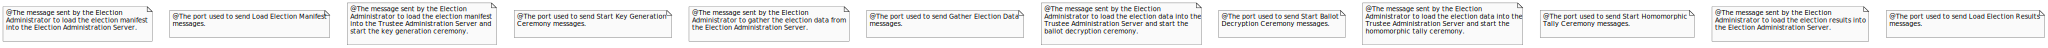

In [12]:
%viz "Messaging::Election Administrator Messaging"

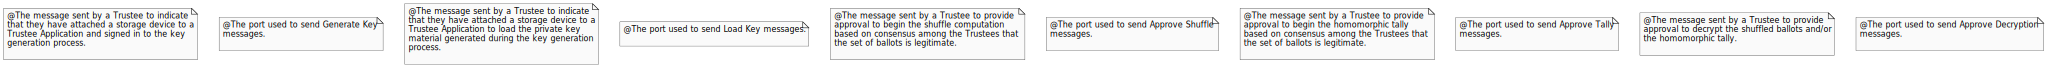

In [13]:
%viz "Messaging::Trustee Messaging"

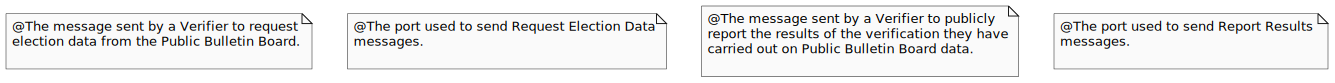

In [14]:
%viz "Messaging::Verifier Messaging"

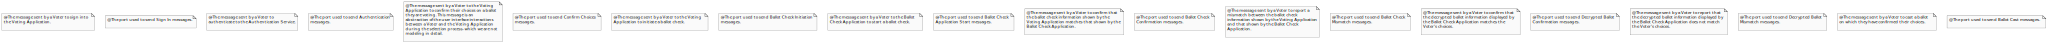

In [15]:
%viz "Messaging::Voter Messaging"

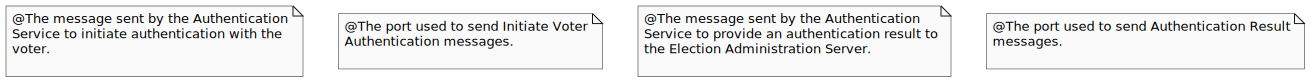

In [16]:
%viz "Messaging::Authentication Service Messaging"

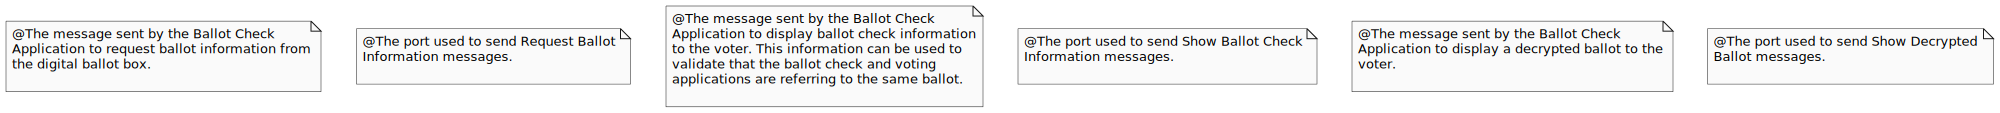

In [17]:
%viz "Messaging::Ballot Check Application Messaging"

In [18]:
%viz "Messaging::Digital Ballot Box Messaging"

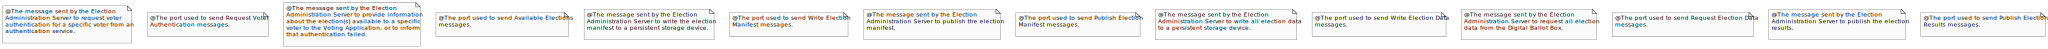

In [19]:
%viz "Messaging::Election Administration Server Messaging"

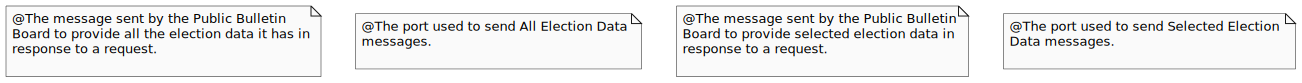

In [20]:
%viz "Messaging::Public Bulletin Board Messaging"

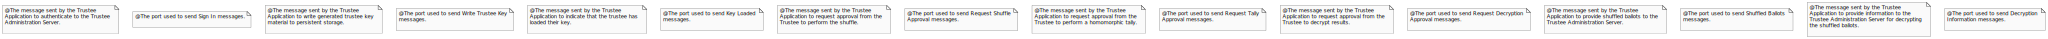

In [21]:
%viz "Messaging::Trustee Application Messaging"

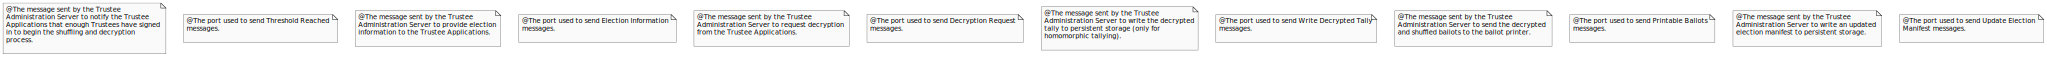

In [22]:
%viz "Messaging::Trustee Administration Server Messaging"

In [23]:
%viz "Messaging::Voting Application Messaging"

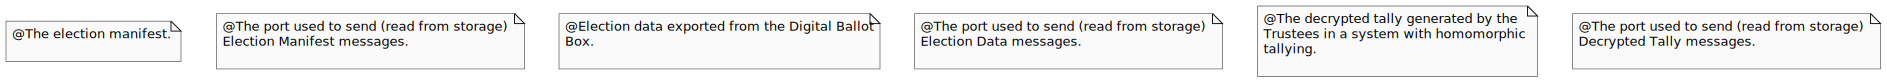

In [24]:
%viz "Messaging::Election Administrator Storage Messaging"

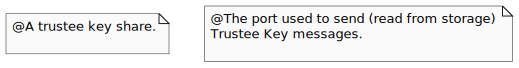

In [25]:
%viz "Messaging::Trustee Storage Messaging"

## Actors

The actors involved in the system are typically individual people, though some actors can be "implemented" in the real world as multiple people (e.g., the Election Administrator responsibilities and privileges may be shared among a small group of election officials for any given election). We model them and their interactions with the system at an abstract level, using the messages described previously.

_@note dmz: I am still sanity checking the port listings in this section._

In [26]:
package 'Actors' {
  //* This package defines the human actors (some of which may actually be groups of human actors) that participate in the operation of the E2E-VIV system. Some subsystems described later (e.g., Voting Application) may also exhibit actor-like behavior, as they can be corrupted (e.g., by malware on a Voter's device changing the behavior of the Voting Application to abuse the server APIs), but we do not list them duplicatively as actors as they are software, not people. */

  private import 'Background Concepts'::*;
  private import Messaging::*;
  
  abstract part def Actor specializes Principal {
    doc /*
      An abstract part that encapsulates all the functionality shared by human actors.
    */
  }

  part def 'Election Administrator' specializes Actor {
    doc /* 
      The Election Administrator facilitates protocols and procedures, provides the election definition, and publishes the election results; this is a single actor in the system even though its responsibilities may be shared among multiple people in a given system instantiation.
    */

    // Output ports
    port loadElectionManifestOut: 'Election Administrator Messaging'::'Load Election Manifest Port';
    port startKeyGenerationCeremonyOut: 'Election Administrator Messaging'::'Start Key Generation Ceremony Port';
    port gatherElectionDataOut: 'Election Administrator Messaging'::'Gather Election Data Port';
    port startBallotDecryptionCeremonyOut: 'Election Administrator Messaging'::'Start Ballot Decryption Ceremony Port';
    port startHomomorphicTallyCeremonyOut: 'Election Administrator Messaging'::'Start Homomorphic Tally Ceremony Port';
    port loadElectionResultsOut: 'Election Administrator Messaging'::'Load Election Results Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendLoadElectionManifest;
    event occurrence sendStartKeyGenerationCeremony;
    event occurrence sendGatherElectionData;
    event occurrence sendStartBallotDecryptionCeremony;
    event occurrence sendStartHomomorphicTallyCeremony;
    event occurrence sendLoadElectionResults;
  }
  alias EA for 'Election Administrator';
  
  part def Trustee specializes Actor {
    doc /* 
      Trustees are jointly responsible for maintaining the privacy of the votes, and for performing/facilitating the vote tally, by keeping custody of election key shares.
    */
    ref item id: Identity[1] :>> Actor::id; // a Trustee has only one Identity

    // Output ports
    port generateKeyOut: 'Trustee Messaging'::'Generate Key Port';
    port loadKeyOut: 'Trustee Messaging'::'Load Key Port';
    port approveShuffleOut: 'Trustee Messaging'::'Approve Shuffle Port';
    port approveTallyOut: 'Trustee Messaging'::'Approve Tally Port';
    port approveDecryptionOut: 'Trustee Messaging'::'Approve Decryption Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendGenerateKey;
    event occurrence sendLoadKey;
    event occurrence sendApproveShuffle;
    event occurrence sendApproveTally;
    event occurrence sendApproveDecryption;
    
    // Input ports
    port requestShuffleApprovalIn: ~'Trustee Application Messaging'::'Request Shuffle Approval Port';
    port requestTallyApprovalIn: ~'Trustee Application Messaging'::'Request Tally Approval Port';
    port requestDecryptionApprovalIn: ~'Trustee Application Messaging'::'Request Decryption Approval Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvRequestShuffleApproval;
    event occurrence recvRequestTallyApproval;
    event occurrence recvRequestDecryptionApproval;
  }
  alias T for 'Trustee';
  
  part def Verifier specializes Actor {
    doc /* 
      A Verifier is a person (or group of people) that evaluates the election records to confirm an election's integrity; verifiers may use any means at their disposal (verification programs, pencil and paper, etc.) to verify the results based on public information available from the Digital Ballot Box, and they have no direct role in the election.
    */

    // Output ports
    port requestElectionDataOut: 'Verifier Messaging'::'Request Election Data Port';
    port reportResultsOut: 'Verifier Messaging'::'Report Results Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendRequestElectionData;
    event occurrence sendReportResults;
    
    // Input ports
    port allElectionDataIn: ~'Public Bulletin Board Messaging'::'All Election Data Port';
    port selectedElectionDataIn: ~'Public Bulletin Board Messaging'::'Selected Election Data Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvAllElectionData;
    event occurrence recvSelectedElectionData;
  }
  alias VER for Verifier;
  
  part def Voter specializes Actor {
    doc /* 
      Voters are people who use the system to cast ballots and optionally check that they have been properly recorded.
    */
    ref item id: Identity[1] :>> Actor::id; // a Voter has only one Identity

    // Output ports
    port signInOut: 'Voter Messaging'::'Sign In Port';
    port authenticationOut: 'Voter Messaging'::'Authentication Port';
    port confirmChoicesOut: 'Voter Messaging'::'Confirm Choices Port';
    port ballotCheckInitiationOut: 'Voter Messaging'::'Ballot Check Initiation Port';
    port ballotCheckApplicationStartOut: 'Voter Messaging'::'Ballot Check Application Start Port';
    port ballotCheckConfirmOut: 'Voter Messaging'::'Ballot Check Confirmation Port';
    port ballotCheckMismatchOut: 'Voter Messaging'::'Ballot Check Mismatch Port';
    port decryptedBallotConfirmOut: 'Voter Messaging'::'Decrypted Ballot Confirmation Port';
    port decryptedBallotMismatchOut: 'Voter Messaging'::'Decrypted Ballot Mismatch Port';
    port ballotCastOut: 'Voter Messaging'::'Ballot Cast Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendSignIn;
    event occurrence sendAuthentication;
    event occurrence sendConfirmChoices;
    event occurrence sendBallotCheckInitiation;
    event occurrence sendBallotCheckApplicationStart;
    event occurrence sendBallotCheckConfirm;
    event occurrence sendBallotCheckMismatch;
    event occurrence sendDecryptedBallotConfirm;
    event occurrence sendDecryptedBallotMismatch;
    event occurrence sendBallotCast;
    
    // Input ports
    port initiateVoterAuthenticationIn: ~'Authentication Service Messaging'::'Initiate Voter Authentication Port';
    port showBallotInformationIn: ~'Voting Application Messaging'::'Show Ballot Information Port';
    port showAuthenticationFailureIn: ~'Voting Application Messaging'::'Show Authentication Failure Port';
    port showInitialBallotCheckInformationIn: ~'Voting Application Messaging'::'Show Initial Ballot Check Information Port';
    port requestBallotCheckInformationConfirmationIn: ~'Voting Application Messaging'::'Request Ballot Check Information Confirmation Port';
    port requestBallotMatchConfirmationIn: ~'Voting Application Messaging'::'Request Ballot Match Confirmation Port';
    port showContingencyInformationIn: ~'Voting Application Messaging'::'Show Contingency Information Port';
    port showBallotCheckInformationIn: ~'Ballot Check Application Messaging'::'Show Ballot Check Information Port';
    port showDecryptedBallotIn: ~'Ballot Check Application Messaging'::'Show Decrypted Ballot Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvInitiateVoterAuthentication;
    event occurrence recvShowBallotInformation;
    event occurrence recvShowAuthenticationFailure;
    event occurrence recvShowBallotCheckInitiationInformation;
    event occurrence recvRequestBallotCheckInformationConfirmation;
    event occurrence recvRequestBallotMatchConfirmation;
    event occurrence recvShowContingencyInformation;
    event occurrence recvShowBallotCheckInformation;
    event occurrence recvShowDecryptedBallot;
  }
  alias V for Voter;
}
// end of Actors

Package Actors (e0aefb6c-b3b4-4f55-bb85-82001d6caa55)


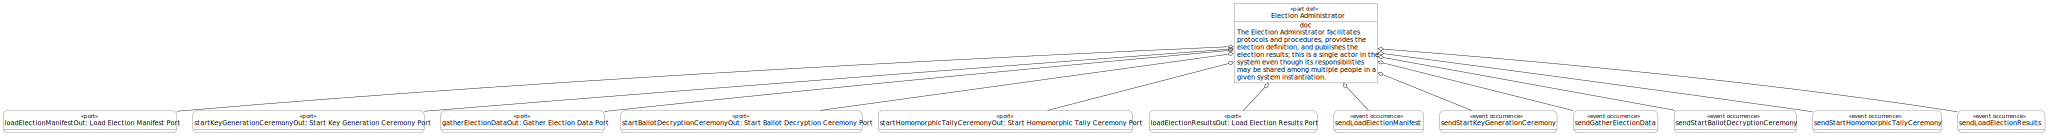

In [27]:
%viz --view=TREE "Actors::Election Administrator"

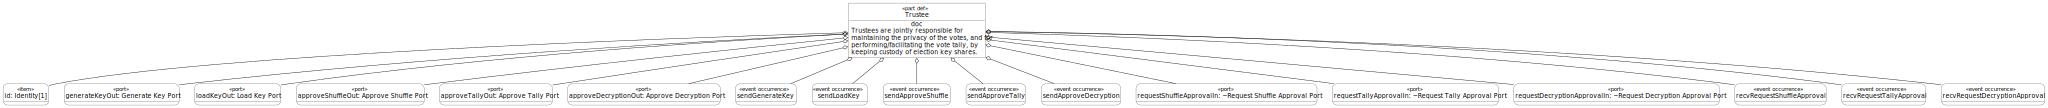

In [28]:
%viz --view=TREE "Actors::Trustee"

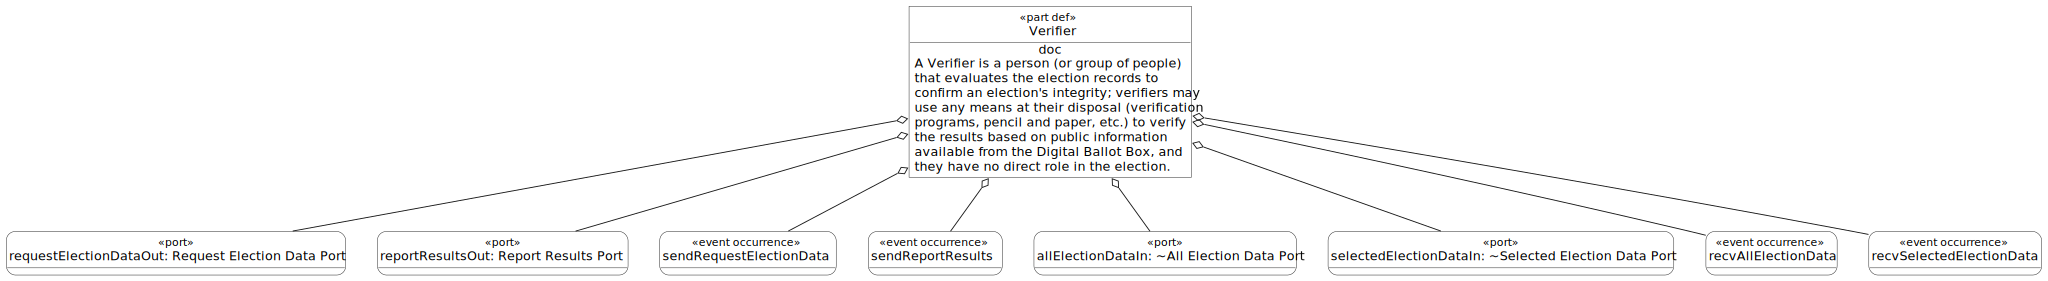

In [29]:
%viz --view=TREE Actors::Verifier"

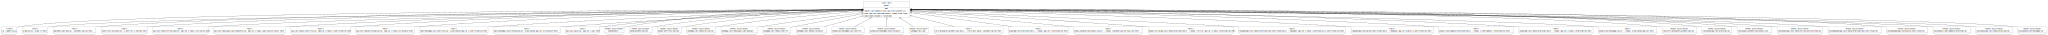

In [30]:
%viz --view=TREE "Actors::Voter"

## Assets

The E2E-VIV system involves both physical and digital assets. They are described below.

In [31]:
package 'Assets' {
  //* The E2E-VIV system has the following assets. */

  private import 'Background Concepts'::*;
  private import Messaging::*;

  item def 'Election Administrator Credentials' {
    doc /* 
      Election Administrator Credentials are used to perform election administration functions.
    */
  }
    
  item def 'Trustee Private Key Share' {
    doc /* 
      A Trustee Private Key Share is a part of the election's private key held by an individual Trustee; a threshold number of these (defined as part of the Election Manifest and used during the Trustee Key Generation Ceremony) is required in order to partially decrypt or homomorphically tally Digital Ballot Cryptograms exported from the Digital Ballot Box.
    */
  }

  item def 'Election Public Key' {
    doc /* 
      The Election Public Key is the public key corresponding to the private key generated during Trustee key generation. Digital Ballot Cryptograms encrypted using the Election Public Key can be decrypted using a threshold number of Trustee Private Key Shares.
    */
  }
    
  item def 'Digital Ballot Box API Credentials' {
    doc /* 
      Digital Ballot Box API Credentials are used to write ballot/election information to the Digital Ballot Box.
    */
  }
    
  item def 'Voter Roster' {
    doc /* 
      The Voter Roster is a list of Voters who are eligible to participate in a particular election. */
  }
    
  item def 'Election Manifest' {
    doc /* 
      The Election Manifest is the definition of an election, including all contests and selectable options, contest selection limits, ballot styles, and appropriate/necessary metadata about the election's timing, software versions, etc. It serves as a common view of the election shared by all actors, publicly visible in the Digital Ballot Box.
    */
  }
    
  item def 'Digital Ballot Cryptogram' {
    doc /* 
      Digital Ballot Cryptograms are encrypted digital representations of ballots that have been submitted to the Digital Ballot Box by Voters using the Voting Application; these may end up being either cast or checked.
    */
    // @todo dmz This may not be strictly true; it's possible for a digital ballot cryptogram to be neither cast nor checked if the protocol doesn't complete properly. That language, and any attributes of the item, should be refined later.
  }
    
  item def 'Cast Digital Ballot Plaintext' {
    doc /* 
      A Cast Digital Ballot Plaintext is a decrypted digital representation of a ballot that has been cast by a Voter using the Voting Application; these should only ever exist within the Trustee Administration Server's trust zone.
    */
  }
    
  item def 'Checked Digital Ballot Plaintext' {
    doc /* 
      A Checked Digital Ballot Plaintext is a decrypted digital representation of a ballot that has been checked by a Voter using the Ballot Check Appplication; these are publicly available in the Digital Ballot Box.
    */
  }
    
  item def 'Printable Cast Ballot' {
    doc /* 
      A Printable Cast Ballot is a printable file that represents a ballot cast in the election, which enables traditional optical-scan or hand tallying of paper ballots in some mix-net based system configurations. */
  }

  part def 'Trustee Storage' specializes Principal {
    doc /* 
      Trustee Storage is a piece of hardware for each Trustee that stores their Trustee Private Key Share; this will most likely be realized as a fresh USB storage device, and must never be attached to an Internet-connected device during the system's lifetime.
    */

    ref item id: Identity[1] :>> Principal::id; // a storage device has only one Identity

    // Output ports
    port trusteeKeyOut: ~'Trustee Storage Messaging'::'Trustee Key Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendTrusteeKey;
    
    // Input ports
    port writeTrusteeKeyIn: ~'Trustee Application Messaging'::'Write Trustee Key Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvWriteTrusteeKey;
  }

  part def 'Election Administrator Storage' specializes Principal {
    doc /* 
      Election Administrator Storage is a piece of hardware for the Election Administrator that is used to convey information between the Election Administration Server/Digital Ballot Box and the Trustee Administration Server (across an air gap); this will most likely be a fresh USB storage device.
    */

    ref item id: Identity[1] :>> Principal::id; // a storage device has only one Identity

    // Output ports
    port electionManifestOut: 'Election Administrator Storage Messaging'::'Election Manifest Port';
    port electionDataOut: 'Election Administrator Storage Messaging'::'Election Data Port';
    port decryptedTallyOut: 'Election Administrator Storage Messaging'::'Decrypted Tally Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendElectionManifest;
    event occurrence sendElectionData;
    event occurrence sendDecryptedTally;
    
    // Input ports
    port writeElectionManifestIn: ~'Election Administration Server Messaging'::'Write Election Manifest Port';
    port writeElectionDataIn: ~'Election Administration Server Messaging'::'Write Election Data Port';
    port updateElectionManifestIn: ~'Trustee Administration Server Messaging'::'Update Election Manifest Port';
    port writeDecryptedTallyIn: ~'Trustee Administration Server Messaging'::'Write Decrypted Tally Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvWriteElectionManifest;
    event occurrence recvWriteElectionData;
    event occurrence recvUpdateElectionManifest;
    event occurrence recvWriteDecryptedTally;
  }
}
// end of Assets

Package Assets (9e225362-13c2-47a4-ad4c-982eda61e10d)


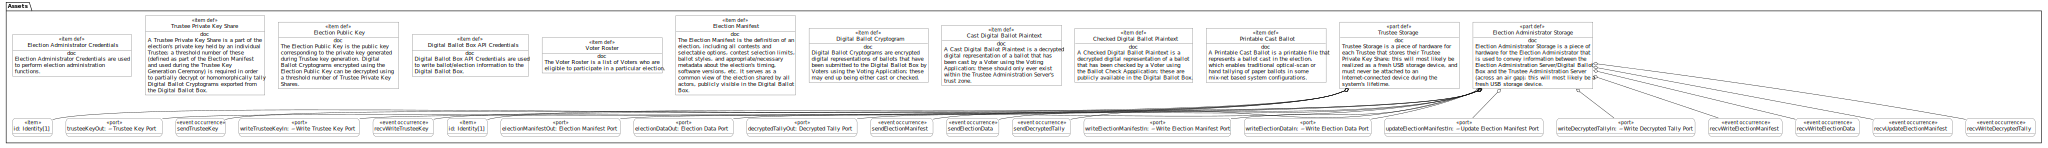

In [32]:
%viz Assets

## Trust

The following are the trust levels in the E2E-VIV system. Trust levels are typically concretized/realized via technological
means, such as Role-Based Access Control configurations in digital systems, which in turn realize appropriate levels of access and control as stipulated by statutes, regulations, and rules.

Note that trust levels are defined as a SysML enumeration; in any specific situation, only a single trust level applies.

In [33]:
package 'Trust Levels' {
  //* The E2E-VIV system has the following trust levels */

  enum def 'Trust Level' {
    enum 'Election Administrator' {
      doc /*
        The Election Administrator trust level includes full, physical access to the Election Administration Server (or to the Election Admistrator Application that has full access to the Election Administration Server, if the latter is in the cloud) and Trustee Administration Server for election configuation and protocol/procedure facilitation. */
    }
      
    enum Trustee {
      doc /* 
        The Trustee trust level includes the ability to physically access the device hosting a single Trustee Application (and thus to hold a single Trustee Private Key Share), and no access to any other subsystem beyond what is available at the Public trust level. */
    }
      
    enum Voter {
      doc /* 
        The Voter trust level includes the ability to use the Voting Application and any number of Ballot Check Applications, and no access to any other subsystems beyond what is available at the Public trust level; note that technically, anybody can run and interact with either of these applications (or, for that matter, attempt to use the APIs of any of the servers connected to the Internet), but only a registered Voter can actually cast a vote or get sufficient information from the Voting Application to check a vote. */
    }

    enum Public {
      doc /* 
        The Public trust level includes the ability to read the public information from the Digital Ballot Box, and to access any Internet-accessible endpoint of the system in any allowed uncredentialed way. */
    }
      
    enum Vendor {
      //* @design kiniry I suggest we need Vendor as a separate trust level, as they often have access different from any of the other trust levels enumerated above. */
    }
  }
}
// end of Trust Levels

Package Trust Levels (670faeba-f841-4cec-9f66-2385a71fb6ec)


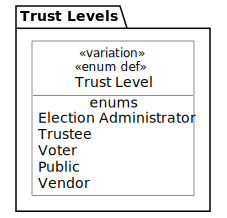

In [34]:
%viz "Trust Levels"

*Trust Zones* are areas of control whose access is constrained by trust levels.

In [35]:
package 'Trust Zones' {
  //* The E2E-VIV system has the following trust zones */

  part def 'Air-Gapped Network' {
    doc /* 
      The Air-Gapped Network is a network sequestered from the global Internet and all other trust zones of the system. It houses the Trustee Applications and Trustee Administration Server; entry to/exit from this zone is exclusively by physical devices (USB storage, paper, direct keyboard input of physical randomness such as dice roll results, etc.). */
  }
    
  part def 'Election Office Network' {
    doc /* 
      The Election Office Network is the network that houses the system exit point used to export data for transfer to the Air-Gapped Network; this network is physically located in an election office.
    */
  }
    
  part def 'Election Administration Network' {
    doc /* 
      The Election Administration Network is the network that houses the Election Administration Server, Digital Ballot Box, and Public Bulletin Board; this network may be connected to the Internet, and may be located either in the cloud or in an election office. */
  }

  part def 'Internet' {
    doc /* 
      The Internet is the worldwide network to which many subsystems (e.g., Voting Application) are directly connected and which connects all trust zones except the Air-Gapped Network.
    */
  }
} 
// end of Trust Zones

Package Trust Zones (d5cbb3e9-67ec-4429-a594-53a61ab96c7a)


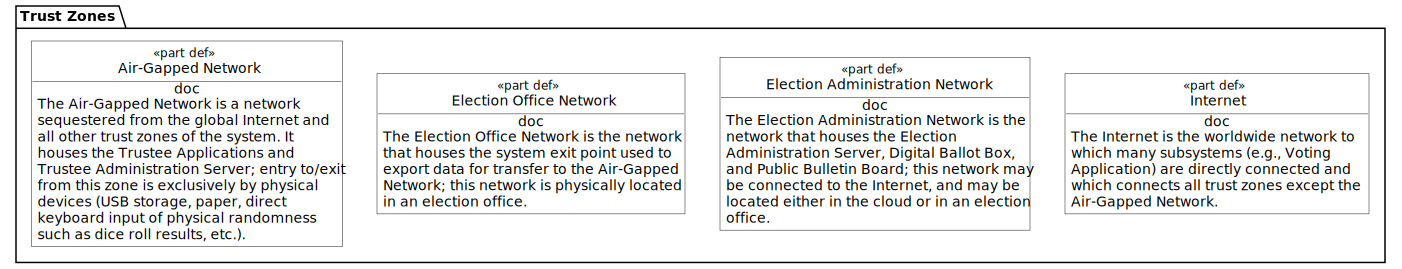

In [36]:
%viz "Trust Zones"

## Subsystems

The following are the primary subsystems of the E2E-VIV system. Subsystems are typically implemented via software components, where it is often, but not always, the case that each component resides and executes on a different physical hardware device.

_@note dmz: I am still sanity checking the port listings in this section._

In [37]:
package 'Subsystems' {
  //* The E2E-VIV system has the following subsystems. */
        
  //* The E2E-VIV system is comprised of the following subsystems. */

  private import 'Background Concepts'::*;
  private import Messaging::*;
  private import Actors::*;
  
  abstract part def Subsystem specializes Principal {
    doc /*
      An abstract part that encapsulates all the functionality shared by subsystems.
    */

    ref item id: Identity[1] :>> Principal::id; // a subsystem instance has only one Identity
  }

  part def Environment {
    doc /* The environment outside the E2E-VIV system. While technically not a subsystem of its own, this allows us to model to completion scenarios that involve messages being sent outside the system (the only one of these so far is post-hoc election verification). */

    // Input ports
    port reportResultsIn: ~'Verifier Messaging'::'Report Results Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvReportResults;
  }
  
  part def <AS> 'Authentication Service' {
    doc /* 
      The Authentication Service is used by the Election Administration Server to authenticate voters' identities, so that their eligibility to vote in a specific election can be determined; in any given instantiation of the system, this service may be provided by multiple external identity service providers. 
    */
    
    // Output ports
    port initiateVoterAuthenticationOut: 'Authentication Service Messaging'::'Initiate Voter Authentication Port';
    port authenticationResultOut: 'Authentication Service Messaging'::'Authentication Result Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendInitiateVoterAuthentication;
    event occurrence sendAuthenticationResult;
    
    // Input ports
    port requestVoterAuthenticationIn: ~'Election Administration Server Messaging'::'Request Voter Authentication Port';
    port authenticationIn: ~'Voter Messaging'::'Authentication Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvRequestVoterAuthentication;
    event occurrence recvAuthentication;
  }
    
  part def <BCA> 'Ballot Check Application' {
    doc /* 
      A Ballot Check Application is a client-side (web-based or mobile) application used by a Voter to perform ballot checks; there may be multiple independent Ballot Check Applications in any instantiation of the system. 
    */

    // Output ports
    port requestBallotInformationOut: 'Ballot Check Application Messaging'::'Request Ballot Information Port';
    port showBallotCheckInformationOut: 'Ballot Check Application Messaging'::'Show Ballot Check Information Port';
    port showDecryptedBallotOut: 'Ballot Check Application Messaging'::'Show Decrypted Ballot Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendRequestBallotInformation;
    event occurrence sendShowBallotCheckInformation;
    event occurrence sendShowDecryptedBallot;

    // Input ports
    port ballotCheckInformationBCAIn: ~'Digital Ballot Box Messaging'::'Ballot Check Information BCA Port';
    port ballotCheckApplicationStartIn: ~'Voter Messaging'::'Ballot Check Application Start Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvBallotCheckInformationBCA;
    event occurrence recvBallotCheckApplicationStart;
  }

  part def <BP> 'Ballot Printer' {
    doc /* 
      A Ballot Printer is a printer that produces Paper Ballots from Cast Digital Ballot Plaintexts. It is only part of the system in variants that perform mix-net decryption and print ballots for physical tally, and is most likely implemented by a standard printer combined with a software component on the Trustee Administration Server that converts Cast Digital Ballot Plaintexts to an appropriate digital format.
    */

    // Input ports
    port printableBallotsIn: ~'Trustee Administration Server Messaging'::'Printable Ballots Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvPrintableBallots;
  }

  part def <DBB> 'Digital Ballot Box' {
    doc /* 
      The Digital Ballot Box is the system that stores submitted digital ballots, which can be used for ballot checks and, post-election, for tallies; this system determines when information can be appended to the Public Bulletin Board.
    */

    // Output ports
    port initialBallotCheckInformationOut: 'Digital Ballot Box Messaging'::'Initial Ballot Check Information Port';
    port ballotCheckInformationBCAOut: 'Digital Ballot Box Messaging'::'Ballot Check Information BCA Port';
    port ballotCheckInformationVAOut: 'Digital Ballot Box Messaging'::'Ballot Check Information VA Port';
    port publishBallotCryptogramOut: 'Digital Ballot Box Messaging'::'Publish Ballot Cryptogram Port';
    port publishSpoilRequestOut: 'Digital Ballot Box Messaging'::'Publish Spoil Request Port';
    port publishCastRequestOut: 'Digital Ballot Box Messaging'::'Publish Cast Request Port';
    port publishBallotCheckInformationOut: 'Digital Ballot Box Messaging'::'Publish Ballot Check Information Port';
    port publishElectionManifestOut: 'Digital Ballot Box Messaging'::'Publish Election Manifest Port';
    port publishElectionResultsOut: 'Digital Ballot Box Messaging'::'Publish Election Results Port';
    port electionDataOut: 'Digital Ballot Box Messaging'::'Election Data Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendInitialBallotCheckInformation;
    event occurrence sendBallotCheckInformationBCA;
    event occurrence sendBallotCheckInformationVA;
    event occurrence sendPublishBallotCryptogram;
    event occurrence sendPublishSpoilRequest;
    event occurrence sendPublishCastRequest;
    event occurrence sendPublishBallotCheckInformation;
    event occurrence sendPublishElectionManifest;
    event occurrence sendPublishElectionResults;
    event occurrence sendElectionData;

    // Input ports
    port ballotIn: ~'Voting Application Messaging'::'Ballot Port';
    port checkBallotIn: ~'Voting Application Messaging'::'Check Ballot Port';
    port castBallotIn: ~'Voting Application Messaging'::'Cast Ballot Port';
    port requestBallotDecryptionIn: ~'Voting Application Messaging'::'Request Ballot Decryption Port';
    port requestBallotInformationIn: ~'Ballot Check Application Messaging'::'Request Ballot Information Port';
    port requestElectionDataIn: ~'Election Administration Server Messaging'::'Request Election Data Port';
    port publishElectionManifestIn: ~'Election Administration Server Messaging'::'Publish Election Manifest Port';
    port publishElectionResultsIn: ~'Election Administration Server Messaging'::'Publish Election Results Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvBallot;
    event occurrence recvCheckBallot;
    event occurrence recvCastBallot;
    event occurrence recvRequestBallotDecryption;
    event occurrence recvRequestBallotInformation;
    event occurrence recvRequestElectionData;
    event occurrence recvPublishElectionManifest;
    event occurrence recvPublishElectionResults;
  }

  part def <EAS> 'Election Administration Server' {
    doc /* 
      The Election Administration Server is the system used by election officials to handle election definition and administration functions, including voter authorization (based on registration records), ballot definitions, election start/end times, etc.; note that we treat this as a single abstract subsystem for simplicity, though in a concrete implementation the election administrator will likely interact with it using a separate election administration application, which we do not model here.
    */

    ref item administrator: Actors::'Election Administrator' {
      doc /* The Election Administrator controlling this Election Administration Server. */
    }
  
    ref part storageDevice: Assets::'Election Administrator Storage' {
      doc /* The Election Administrator Storage device associated with the administrator. */
    }
    
    // Output ports
    port requestVoterAuthenticationOut: 'Election Administration Server Messaging'::'Request Voter Authentication Port';
    port availableElectionsOut: 'Election Administration Server Messaging'::'Available Elections Port';
    port writeElectionManifestOut: 'Election Administration Server Messaging'::'Write Election Manifest Port';
    port publishElectionManifestOut: 'Election Administration Server Messaging'::'Publish Election Manifest Port';
    port writeElectionDataOut: 'Election Administration Server Messaging'::'Write Election Data Port';
    port requestElectionDataOut: 'Election Administration Server Messaging'::'Request Election Data Port';
    port publishElectionResultsOut: 'Election Administration Server Messaging'::'Publish Election Results Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendRequestVoterAuthentication;
    event occurrence sendAvailableElections;
    event occurrence sendWriteElectionManifest;
    event occurrence sendPublishElectionManifest;
    event occurrence sendWriteElectionData;
    event occurrence sendRequestElectionData;
    event occurrence sendPublishElectionResults;

    // Input ports
    port authenticationResultIn: ~'Authentication Service Messaging'::'Authentication Result Port';
    port electionDataIn: ~'Digital Ballot Box Messaging'::'Election Data Port';
    port requestAuthenticationIn: ~'Voting Application Messaging'::'Request Authentication Port';
    port voterHasVotedIn: ~'Voting Application Messaging'::'Voter Has Voted Port';
    port loadElectionManifestIn: ~'Election Administrator Messaging'::'Load Election Manifest Port';
    port gatherElectionDataIn: ~'Election Administrator Messaging'::'Gather Election Data Port';
    port loadElectionResultsIn: ~'Election Administrator Messaging'::'Load Election Results Port';
    port electionManifestIn: ~'Election Administrator Storage Messaging'::'Election Manifest Port';
    port decryptedTallyIn: ~'Election Administrator Storage Messaging'::'Decrypted Tally Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvAuthenticationResult;
    event occurrence recvElectionData;
    event occurrence recvRequestAuthentication;
    event occurrence recvVoterHasVoted;
    event occurrence recvLoadElectionManifest;
    event occurrence recvGatherElectionData;
    event occurrence recvLoadElectionResults;
    event occurrence recvElectionManifest;
    event occurrence recvDecryptedTally;
  }
  
  part def <PBB> 'Public Bulletin Board' {
    doc /* 
      The Public Bulletin Board is the canonical, publicly-readable, append-only view of election information; it can only be appended to by the Digital Ballot Box. 
    */

    // Output ports
    port allElectionDataOut: 'Public Bulletin Board Messaging'::'All Election Data Port';
    port selectedElectionDataOut: 'Public Bulletin Board Messaging'::'Selected Election Data Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendAllElectionData;
    event occurrence sendSelectedElectionData;

    // Input ports
    port publishBallotCryptogramIn: ~'Digital Ballot Box Messaging'::'Publish Ballot Cryptogram Port';
    port publishSpoilRequestIn: ~'Digital Ballot Box Messaging'::'Publish Spoil Request Port';
    port publishCastRequestIn: ~'Digital Ballot Box Messaging'::'Publish Cast Request Port';
    port publishBallotCheckInformationIn: ~'Digital Ballot Box Messaging'::'Publish Ballot Check Information Port';
    port publishElectionManifestIn: ~'Digital Ballot Box Messaging'::'Publish Election Manifest Port';
    port publishElectionResultsIn: ~'Digital Ballot Box Messaging'::'Publish Election Results Port';
    port requestElectionDataIn: ~'Verifier Messaging'::'Request Election Data Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvPublishBallotCryptogram;
    event occurrence recvPublishSpoilRequest;
    event occurrence recvPublishCastRequest;
    event occurrence recvPublishBallotCheckInformation;
    event occurrence recvPublishElectionManifest;
    event occurrence recvPublishElectionResults;
    event occurrence recvRequestElectionData;
  }

  part def <TAS> 'Trustee Administration Server' {
    doc /* 
      The Trustee Administration Server is the system that orchestrates the generation of cryptographic keys (and associated threshold secret sharing) related to the election before the election begins, and ballot decryption or homomorphic tallying once the election is complete. It must not be connected to the Internet at any point during the system's lifetime.
    */

    ref item administrator: Actors::'Election Administrator' {
      doc /* The Election Administrator controlling this Trustee Administration Server. */
    }
  
    ref part storageDevice: Assets::'Election Administrator Storage' {
      doc /* The Election Administrator Storage device associated with the administrator. */
    }
  
    ref part ballotPrinters: 'Ballot Printer'[0..*] {
      doc /* The Ballot Printer(s) attached to this Trustee Administration Server, if any. */
    }
  
    ref part trusteeApplications: 'Trustee Application'[1..*] {
      doc /* The Trustee Applications orchestrated by this Trustee Administration Server. */
    }
  
    attribute trusteeCount: ScalarValues::Positive;
    attribute trusteeThreshold: ScalarValues::Positive;

    assert constraint reasonableTrusteeCounts {
      0 < trusteeThreshold & trusteeThreshold <= trusteeCount
    }
    
    // Output ports
    port thresholdReachedOut: 'Trustee Administration Server Messaging'::'Threshold Reached Port';
    port decryptionRequestOut: 'Trustee Administration Server Messaging'::'Decryption Request Port';
    port writeDecryptedTallyOut: 'Trustee Administration Server Messaging'::'Write Decrypted Tally Port';
    port printableBallotsOut: 'Trustee Administration Server Messaging'::'Printable Ballots Port';
    port updateElectionManifestOut: 'Trustee Administration Server Messaging'::'Update Election Manifest Port';
    port electionInformationOut: 'Trustee Administration Server Messaging'::'Election Information Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendThresholdReached;
    event occurrence sendDecryptionRequest;
    event occurrence sendWriteDecryptedTally;
    event occurrence sendPrintableBallots;
    event occurrence sendUpdateElectionManifest;
    event occurrence sendElectionInformation;

    // Input ports
    port signInIn: ~'Trustee Application Messaging'::'Sign In Port';
    port keyLoadedIn: ~'Trustee Application Messaging'::'Key Loaded Port';
    port shuffledBallotsIn: ~'Trustee Application Messaging'::'Shuffled Ballots Port';
    port decryptionInformationIn: ~'Trustee Application Messaging'::'Decryption Information Port';
    port startKeyGenerationCeremonyIn: ~'Election Administrator Messaging'::'Start Key Generation Ceremony Port';
    port startBallotDecryptionCeremonyIn: ~'Election Administrator Messaging'::'Start Ballot Decryption Ceremony Port';
    port startHomomorphicTallyCeremonyIn: ~'Election Administrator Messaging'::'Start Homomorphic Tally Ceremony Port';
    port electionManifestIn: ~'Election Administrator Storage Messaging'::'Election Manifest Port';
    port electionDataIn: ~'Election Administrator Storage Messaging'::'Election Data Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvSignIn;
    event occurrence recvKeyLoaded;
    event occurrence recvShuffledBallots;
    event occurrence recvDecryptionInformation;
    event occurrence recvStartKeyGenerationCeremony;
    event occurrence recvStartBallotDecryptionCeremony;
    event occurrence recvStartHomomorphicTallyCeremony;
    event occurrence recvElectionManifest;
    event occurrence recvElectionData;
  }

  part def <TA> 'Trustee Application' {
    doc /* 
      The Trustee Application is the client-side application with which Trustees interact in order to generate their private key shares, open/close the election, and perform ballot mixing and decryption in a mix-net configuration or homomorphic tally decryption in a homomorphic tally configuration; this application runs on a dedicated device, one of which exists for each Trustee, and must not be directly connected to the Internet at any point during the system's lifetime. 
    */

    ref item trustee: Actors::Trustee {
      doc /* The Trustee associated with this Trustee Application. */
    }
  
    ref part trusteeStorage: Assets::'Trustee Storage' {
      doc /* The Trustee Storage device associated with the trustee. */
    }
  
    // Output ports
    port signInOut: 'Trustee Application Messaging'::'Sign In Port';
    port writeTrusteeKeyOut: 'Trustee Application Messaging'::'Write Trustee Key Port';
    port requestShuffleApprovalOut: 'Trustee Application Messaging'::'Request Shuffle Approval Port';
    port requestTallyApprovalOut: 'Trustee Application Messaging'::'Request Tally Approval Port';
    port requestDecryptionApprovalOut: 'Trustee Application Messaging'::'Request Decryption Approval Port';
    port keyLoadedOut: 'Trustee Application Messaging'::'Key Loaded Port';
    port shuffledBallotsOut: 'Trustee Application Messaging'::'Shuffled Ballots Port';
    port decryptionInformationOut: 'Trustee Application Messaging'::'Decryption Information Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendSignIn;
    event occurrence sendWriteTrusteeKey;
    event occurrence sendRequestShuffleApproval;
    event occurrence sendRequestTallyApproval;
    event occurrence sendRequestDecryptionApproval;
    event occurrence sendKeyLoaded;
    event occurrence sendShuffledBallots;
    event occurrence sendDecryptionInformation;
  
    // Input ports
    port thresholdReachedIn: ~'Trustee Administration Server Messaging'::'Threshold Reached Port';
    port electionInformationIn: ~'Trustee Administration Server Messaging'::'Election Information Port';
    port decryptionRequestIn: ~'Trustee Administration Server Messaging'::'Decryption Request Port';
    port trusteeKeyIn: ~'Trustee Storage Messaging'::'Trustee Key Port';
    port generateKeyIn: ~'Trustee Messaging'::'Generate Key Port';
    port loadKeyIn: ~'Trustee Messaging'::'Load Key Port';
    port approveShuffleIn: ~'Trustee Messaging'::'Approve Shuffle Port';
    port approveTallyIn: ~'Trustee Messaging'::'Approve Tally Port';
    port approveDecryptionIn: ~'Trustee Messaging'::'Approve Decryption Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvThresholdReached;
    event occurrence recvElectionInformation;
    event occurrence recvDecryptionRequest;
    event occurrence recvTrusteeKey;
    event occurrence recvGenerateKey;
    event occurrence recvLoadKey;
    event occurrence recvApproveShuffle;
    event occurrence recvApproveTally;
    event occurrence recvApproveDecryption;
  }

  part def <VA> 'Voting Application' {
    doc /* 
      The Voting Application is the client-side mobile application used by a voter to authenticate to the system, make choices on a ballot, and cast or check a voted ballot. 
    */

    ref item voter: Actors::Voter {
      doc /* The Voter associated with this Voter Application. */
    }

    // Output ports
    port requestAuthenticationOut: 'Voting Application Messaging'::'Request Authentication Port';
    port showBallotInformationOut: 'Voting Application Messaging'::'Show Ballot Information Port';
    port showAuthenticationFailureOut: 'Voting Application Messaging'::'Show Authentication Failure Port';
    port ballotOut: 'Voting Application Messaging'::'Ballot Port';
    port showInitialBallotCheckInformationOut: 'Voting Application Messaging'::'Show Initial Ballot Check Information Port';
    port checkBallotOut: 'Voting Application Messaging'::'Check Ballot Port';
    port requestBallotCheckInformationConfirmationOut: 'Voting Application Messaging'::'Request Ballot Check Information Confirmation Port';
    port requestBallotDecryptionOut: 'Voting Application Messaging'::'Request Ballot Decryption Port';
    port requestBallotMatchConfirmationOut: 'Voting Application Messaging'::'Request Ballot Match Confirmation Port';
    port castBallotOut: 'Voting Application Messaging'::'Cast Ballot Port';
    port voterHasVotedOut: 'Voting Application Messaging'::'Voter Has Voted Port';
    port showContingencyInformationOut: 'Voting Application Messaging'::'Show Contingency Information Port';

    // Event occurrences corresponding to sends on output ports
    event occurrence sendRequestAuthentication;
    event occurrence sendShowBallotInformation;
    event occurrence sendShowAuthenticationFailure;
    event occurrence sendBallot;
    event occurrence sendShowBallotCheckInformation;
    event occurrence sendCheckBallot;
    event occurrence sendRequestBallotCheckInformationConfirmation;
    event occurrence sendRequestBallotDecryption;
    event occurrence sendRequestBallotMatchConfirmation;
    event occurrence sendCastBallot;
    event occurrence sendVoterHasVoted;
    event occurrence sendShowContingencyInformation;
  
    // Input ports
    port signInIn: ~'Voter Messaging'::'Sign In Port';
    port confirmChoicesIn: ~'Voter Messaging'::'Confirm Choices Port';
    port ballotCheckInitiationIn: ~'Voter Messaging'::'Ballot Check Initiation Port';
    port ballotCheckApplicationStartIn: ~'Voter Messaging'::'Ballot Check Application Start Port';
    port ballotCheckConfirmIn: ~'Voter Messaging'::'Ballot Check Confirmation Port';
    port ballotCheckMismatchIn: ~'Voter Messaging'::'Ballot Check Mismatch Port';
    port decryptedBallotConfirmIn: ~'Voter Messaging'::'Decrypted Ballot Confirmation Port';
    port decryptedBallotMismatchIn: ~'Voter Messaging'::'Decrypted Ballot Mismatch Port';
    port ballotCastIn: ~'Voter Messaging'::'Ballot Cast Port';
    port initialBallotCheckInformationIn: ~'Digital Ballot Box Messaging'::'Initial Ballot Check Information Port';
    port ballotCheckInformationVAIn: ~'Digital Ballot Box Messaging'::'Ballot Check Information VA Port';
    port availableElectionsIn: ~'Election Administration Server Messaging'::'Available Elections Port';
    port initiateVoterAuthenticationIn: ~'Authentication Service Messaging'::'Initiate Voter Authentication Port';

    // Event occurrences corresponding to receives on input ports
    event occurrence recvSignIn;
    event occurrence recvConfirmChoices;
    event occurrence recvBallotCheckInitiation;
    event occurrence recvBallotCheckApplicationStart;
    event occurrence recvBallotCheckConfirm;
    event occurrence recvBallotCheckMismatch;
    event occurrence recvDecryptedBallotConfirm;
    event occurrence recvDecryptedBallotMismatch;
    event occurrence recvBallotCast;
    event occurrence recvInitialBallotCheckInformation;
    event occurrence recvBallotCheckInformationVA;
    event occurrence recvAvailableElections;
    event occurrence recvInitiateVoterAuthentication;
  }
} 
// end of Subsystems

Package Subsystems (60803399-7a4f-431b-9c72-f4ab28bc8b99)


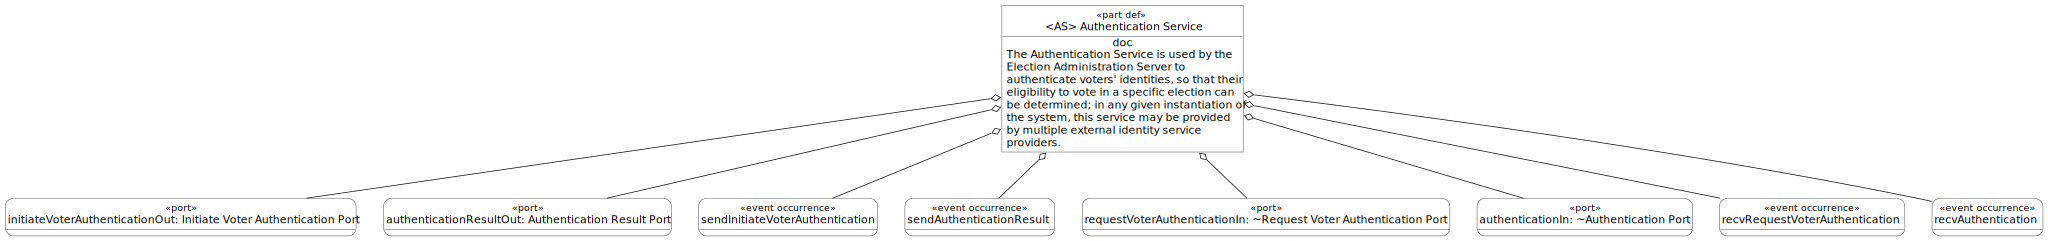

In [38]:
%viz Subsystems::AS

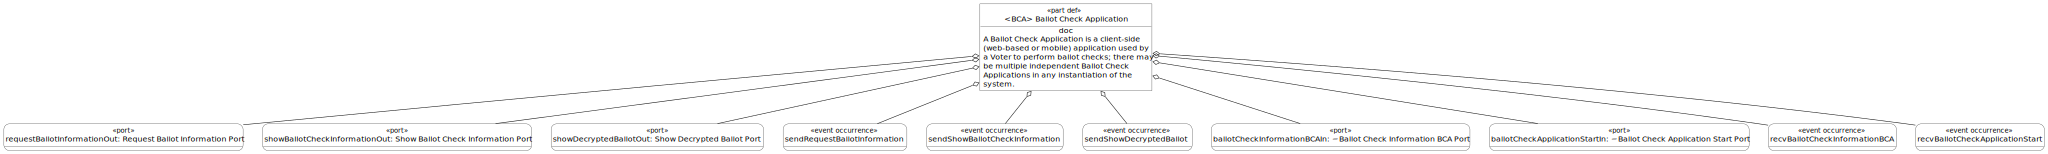

In [39]:
%viz Subsystems::BCA

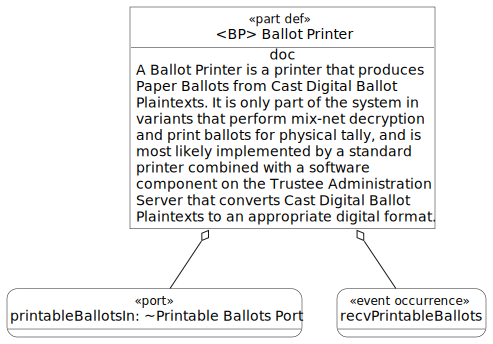

In [40]:
%viz Subsystems::BP

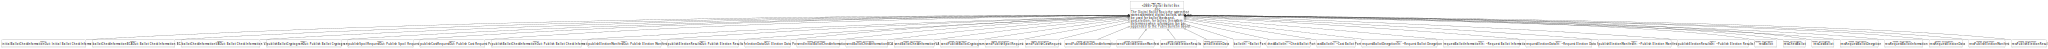

In [41]:
%viz Subsystems::DBB

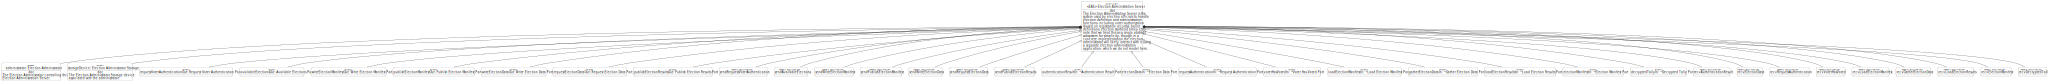

In [42]:
%viz Subsystems::EAS

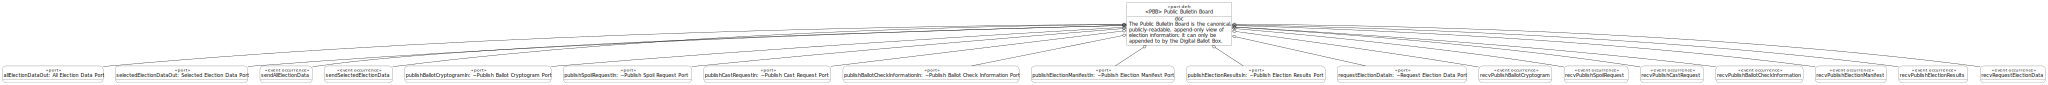

In [43]:
%viz Subsystems::PBB

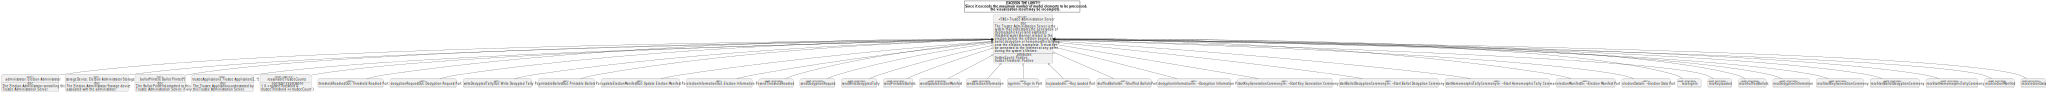

In [44]:
%viz Subsystems::TAS

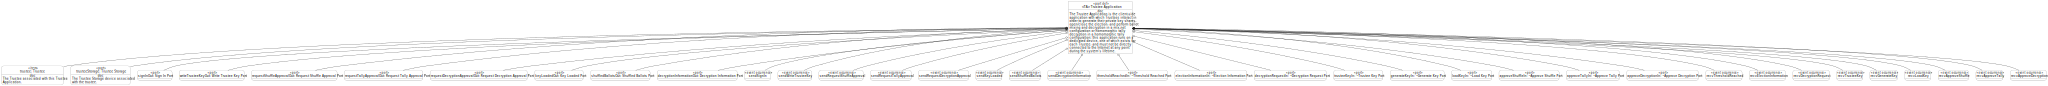

In [45]:
%viz Subsystems::TA

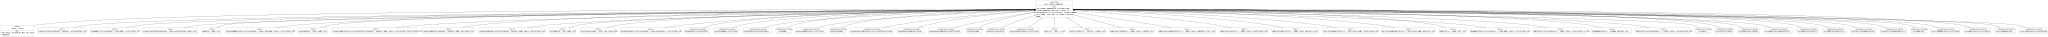

In [46]:
%viz Subsystems::VA

Next, we describe the system's network topology, by first instantiating trust zones and the subsystems/actors within them, and then establishing the interconnections among the principals.

**Design Notes** It appears that (1) there are too many entities here for the graphical renderer to deal with, and (2) the renderer does not render connections that span trust zones (e.g., between a verifier and the digital ballot box) for some reason.

In [47]:
package 'Network Topology' {
  private import 'End-to-End Verifiable Internet Voting Cryptographic Core'::*;
  private import 'Background Concepts'::*;
  private import 'Trust Zones'::*;
  private import 'Actors'::*;
  private import 'Subsystems'::*;
  private import 'Messaging'::*;
  private import 'Assets'::*;

  part entireSystem: 'E2E-VIV System' {
    
    part electionOfficeNetwork: 'Election Office Network' {
      // Actors
      // @design dmz The election administrator (and its storage) is present
      //  in the model both here and in the air-gapped network because
      //  it interacts with the system via both; it could also be lifted out
      //  of both to exist only outside.
      part electionAdministrator: 'Election Administrator';

      // Assets
      item electionAdministratorStorage: 'Election Administrator Storage';

      // there are no port connections solely within this network, because
      // we have not explicitly modeled an election administrator workstation
      // within the election office; effectively, the election adminstrator
      // (and its storage) communicate directly with the election 
      // administration server
    }
    
    part electionAdminNetwork: 'Election Administration Network' {
      // Subsystems
      part electionAdminServer: 'Election Administration Server';
      part digitalBallotBox: 'Digital Ballot Box';
      part publicBulletinBoard: 'Public Bulletin Board';

      // Port connections within the network. Note that there are also 
      // connections between Internet actors/systems and this network.

      //@ design dmz we use "flow" instead of "message" because it causes
      //  (an admittedly clunky) diagram to be generated of the connections,
      //  which oddly doesn't happen with "message"

      // EAS -> DBB
      flow electionAdminServer.publishElectionManifestOut to digitalBallotBox.publishElectionManifestIn;
      flow electionAdminServer.publishElectionResultsOut to digitalBallotBox.publishElectionResultsIn;
      flow electionAdminServer.requestElectionDataOut to digitalBallotBox.requestElectionDataIn;

      // DBB -> EAS
      flow digitalBallotBox.electionDataOut to electionAdminServer.electionDataIn;

      // DBB -> PBB
      flow digitalBallotBox.publishBallotCryptogramOut to publicBulletinBoard.publishBallotCryptogramIn;
      flow digitalBallotBox.publishSpoilRequestOut to publicBulletinBoard.publishSpoilRequestIn;
      flow digitalBallotBox.publishCastRequestOut to publicBulletinBoard.publishCastRequestIn;
      flow digitalBallotBox.publishBallotCheckInformationOut to publicBulletinBoard.publishBallotCheckInformationIn;
      flow digitalBallotBox.publishElectionManifestOut to publicBulletinBoard.publishElectionManifestIn;
      flow digitalBallotBox.publishElectionResultsOut to publicBulletinBoard.publishElectionResultsIn;
    }

    part internet: 'Internet' {
      // Actors
      part voters: Voter[1..voterCount];
      part verifiers: Verifier[1..verifierCount];

      // Subsystems
      part authenticationService: 'Authentication Service';
      part votingApplications: 'Voting Application'[1..voterCount];
      part ballotCheckApplications: 'Ballot Check Application'[1..ballotCheckApplicationCount];

      // Port connections within the network. Note that there are also 
      // connections between Election Administration Network
      // actors/systems and this network.

      //@ design dmz we use "flow" instead of "message" because it causes
      //  (an admittedly clunky) diagram to be generated of the connections,
      //  which oddly doesn't happen with "message"
      
      // V -> VA
      flow voters.signInOut to votingApplications.signInIn;
      flow voters.confirmChoicesOut to votingApplications.confirmChoicesIn;
      flow voters.ballotCheckInitiationOut to votingApplications.ballotCheckInitiationIn;
      flow voters.ballotCheckConfirmOut to votingApplications.ballotCheckConfirmIn;
      flow voters.ballotCheckMismatchOut to votingApplications.ballotCheckMismatchIn;
      flow voters.decryptedBallotConfirmOut to votingApplications.decryptedBallotConfirmIn;
      flow voters.decryptedBallotMismatchOut to votingApplications.decryptedBallotMismatchIn;
      flow voters.ballotCastOut to votingApplications.ballotCastIn;
      flow voters.ballotCheckApplicationStartOut to votingApplications.ballotCheckApplicationStartIn;

      // V -> AS
      flow voters.authenticationOut to authenticationService.authenticationIn;

      // V -> BCA
      flow voters.ballotCheckApplicationStartOut to ballotCheckApplications.ballotCheckApplicationStartIn;

      // AS -> VA
      flow authenticationService.initiateVoterAuthenticationOut to votingApplications.initiateVoterAuthenticationIn;
      
      // VA -> V
      flow votingApplications.showBallotInformationOut to voters.showBallotInformationIn;
      flow votingApplications.showAuthenticationFailureOut to voters.showAuthenticationFailureIn;
      flow votingApplications.showInitialBallotCheckInformationOut to voters.showInitialBallotCheckInformationIn;
      flow votingApplications.requestBallotCheckInformationConfirmationOut to voters.requestBallotCheckInformationConfirmationIn;
      flow votingApplications.requestBallotMatchConfirmationOut to voters.requestBallotMatchConfirmationIn;
      flow votingApplications.showContingencyInformationOut to voters.showContingencyInformationIn;

      // VA -> AS
      flow votingApplications.requestAuthenticationOut to authenticationService.requestVoterAuthenticationIn;

      // BCA -> V
      flow ballotCheckApplications.showBallotCheckInformationOut to voters.showBallotCheckInformationIn;
      flow ballotCheckApplications.showDecryptedBallotOut to voters.showDecryptedBallotIn;
    }

    part airGappedNetwork: 'Air-Gapped Network' {      
      // Actors
      // @design dmz The election administrator (and its storage) is present
      //  in the model both here and in the election office network because
      //  it interacts with the system via both; it could also be lifted out
      //  of both to exist only outside.
      part electionAdministrator: 'Election Administrator';
      part trustees: Trustee[1..trusteeCount];
  
      // Subsystems
      part trusteeAdminServer: 'Trustee Administration Server';
      part trusteeApplications: 'Trustee Application'[1..trusteeCount];
      part ballotPrinters: 'Ballot Printer'[0..printerCount];
      
      // Assets
      item electionAdministratorStorage: 'Election Administrator Storage';
      item trusteeStorage: 'Trustee Storage'[1..trusteeCount];

      // Port connections within the network; since this is the air-gapped
      // network, there are no connections to/from outside ports; note that
      // multiplicity is glossed over here (we assume that many-to-one/one-
      // to-many connections are handled reasonably), and that SysMLv2 does
      // not seem to check for port compatibility when defining connections
      // this way.

      //@ design dmz we use "flow" instead of "message" because it causes
      //  (an admittedly clunky) diagram to be generated of the connections,
      //  which oddly doesn't happen with "message"

      // EA -> TAS
      flow electionAdministrator.startKeyGenerationCeremonyOut to trusteeAdminServer.startKeyGenerationCeremonyIn;
      flow electionAdministrator.startBallotDecryptionCeremonyOut to trusteeAdminServer.startBallotDecryptionCeremonyIn;
      flow electionAdministrator.startHomomorphicTallyCeremonyOut to trusteeAdminServer.startHomomorphicTallyCeremonyIn;

      // EST -> TAS
      flow electionAdministratorStorage.electionManifestOut to trusteeAdminServer.electionManifestIn;
      flow electionAdministratorStorage.electionDataOut to trusteeAdminServer.electionDataIn;
      
      // TA -> TAS
      flow trusteeApplications.signInOut to trusteeAdminServer.signInIn;
      flow trusteeApplications.shuffledBallotsOut to trusteeAdminServer.shuffledBallotsIn;
      flow trusteeApplications.decryptionInformationOut to trusteeAdminServer.decryptionInformationIn;

      // TA -> TST
      flow trusteeApplications.writeTrusteeKeyOut to trusteeStorage.writeTrusteeKeyIn;

      // TA -> T
      flow trusteeApplications.requestShuffleApprovalOut to trustees.requestShuffleApprovalIn;
      flow trusteeApplications.requestTallyApprovalOut to trustees.requestTallyApprovalIn;
      flow trusteeApplications.requestDecryptionApprovalOut to trustees.requestDecryptionApprovalIn;

      // TAS -> BP
      flow trusteeAdminServer.printableBallotsOut to ballotPrinters.printableBallotsIn;

      // TAS -> TA
      flow trusteeAdminServer.thresholdReachedOut to trusteeApplications.thresholdReachedIn;
      flow trusteeAdminServer.decryptionRequestOut to trusteeApplications.decryptionRequestIn;
      flow trusteeAdminServer.electionInformationOut to trusteeApplications.electionInformationIn;

      // TAS -> EST
      flow trusteeAdminServer.writeDecryptedTallyOut to electionAdministratorStorage.writeDecryptedTallyIn;
      flow trusteeAdminServer.updateElectionManifestOut to electionAdministratorStorage.updateElectionManifestIn;
      
      // T -> TA
      flow trustees.generateKeyOut to trusteeApplications.generateKeyIn;
      flow trustees.loadKeyOut to trusteeApplications.loadKeyIn;
      flow trustees.approveShuffleOut to trusteeApplications.approveShuffleIn;
      flow trustees.approveTallyOut to trusteeApplications.approveTallyIn;
      flow trustees.approveDecryptionOut to trusteeApplications.approveDecryptionIn;

      // TST -> TA
      flow trusteeStorage.trusteeKeyOut to trusteeApplications.trusteeKeyIn;
    }

    // Flows that connect different trust zones
    
    // EA -> EAS
    flow electionOfficeNetwork.electionAdministrator.loadElectionManifestOut to electionAdminNetwork.electionAdminServer.loadElectionManifestIn;
    flow electionOfficeNetwork.electionAdministrator.gatherElectionDataOut to electionAdminNetwork.electionAdminServer.gatherElectionDataIn;
    flow electionOfficeNetwork.electionAdministrator.loadElectionResultsOut to electionAdminNetwork.electionAdminServer.loadElectionResultsIn;

    // EAS -> EST
    flow electionAdminNetwork.electionAdminServer.writeElectionManifestOut to electionOfficeNetwork.electionAdministratorStorage.writeElectionManifestIn;
    flow electionAdminNetwork.electionAdminServer.writeElectionDataOut to electionOfficeNetwork.electionAdministratorStorage.writeElectionDataIn;

    // EST -> EAS
    flow electionOfficeNetwork.electionAdministratorStorage.electionManifestOut to electionAdminNetwork.electionAdminServer.electionManifestIn;
    flow electionOfficeNetwork.electionAdministratorStorage.decryptedTallyOut to electionAdminNetwork.electionAdminServer.decryptedTallyIn;

    // AS -> EAS
    flow internet.authenticationService.authenticationResultOut to electionAdminNetwork.electionAdminServer.authenticationResultIn;

    // EAS -> AS
    flow electionAdminNetwork.electionAdminServer.requestVoterAuthenticationOut to internet.authenticationService.requestVoterAuthenticationIn;

    // VER -> PBB
    flow internet.verifiers.requestElectionDataOut to electionAdminNetwork.publicBulletinBoard.requestElectionDataIn;

    // PBB -> VER
    flow electionAdminNetwork.publicBulletinBoard.allElectionDataOut to internet.verifiers.allElectionDataIn;
    flow electionAdminNetwork.publicBulletinBoard.selectedElectionDataOut to internet.verifiers.selectedElectionDataIn;

    // VA -> EAS
    flow internet.votingApplications.voterHasVotedOut to electionAdminNetwork.electionAdminServer.voterHasVotedIn;

    // EAS -> VA
    flow electionAdminNetwork.electionAdminServer.availableElectionsOut to internet.votingApplications.availableElectionsIn;

    // BCA -> DBB
    flow internet.ballotCheckApplications.requestBallotInformationOut to electionAdminNetwork.digitalBallotBox.requestBallotInformationIn;

    // DBB -> BCA
    flow electionAdminNetwork.digitalBallotBox.ballotCheckInformationBCAOut to internet.ballotCheckApplications.ballotCheckInformationBCAIn;

    // VA -> DBB
    flow internet.votingApplications.ballotOut to electionAdminNetwork.digitalBallotBox.ballotIn;
    flow internet.votingApplications.checkBallotOut to electionAdminNetwork.digitalBallotBox.checkBallotIn;
    flow internet.votingApplications.castBallotOut to electionAdminNetwork.digitalBallotBox.castBallotIn;
    flow internet.votingApplications.requestBallotDecryptionOut to electionAdminNetwork.digitalBallotBox.requestBallotDecryptionIn;
    
    
    // DBB -> VA
    flow electionAdminNetwork.digitalBallotBox.initialBallotCheckInformationOut to internet.votingApplications.initialBallotCheckInformationIn;
    flow electionAdminNetwork.digitalBallotBox.ballotCheckInformationVAOut to internet.votingApplications.ballotCheckInformationVAIn;
  }
}

Package Network Topology (a3c03d23-a9bd-4fb1-b906-a97878e5ab68)


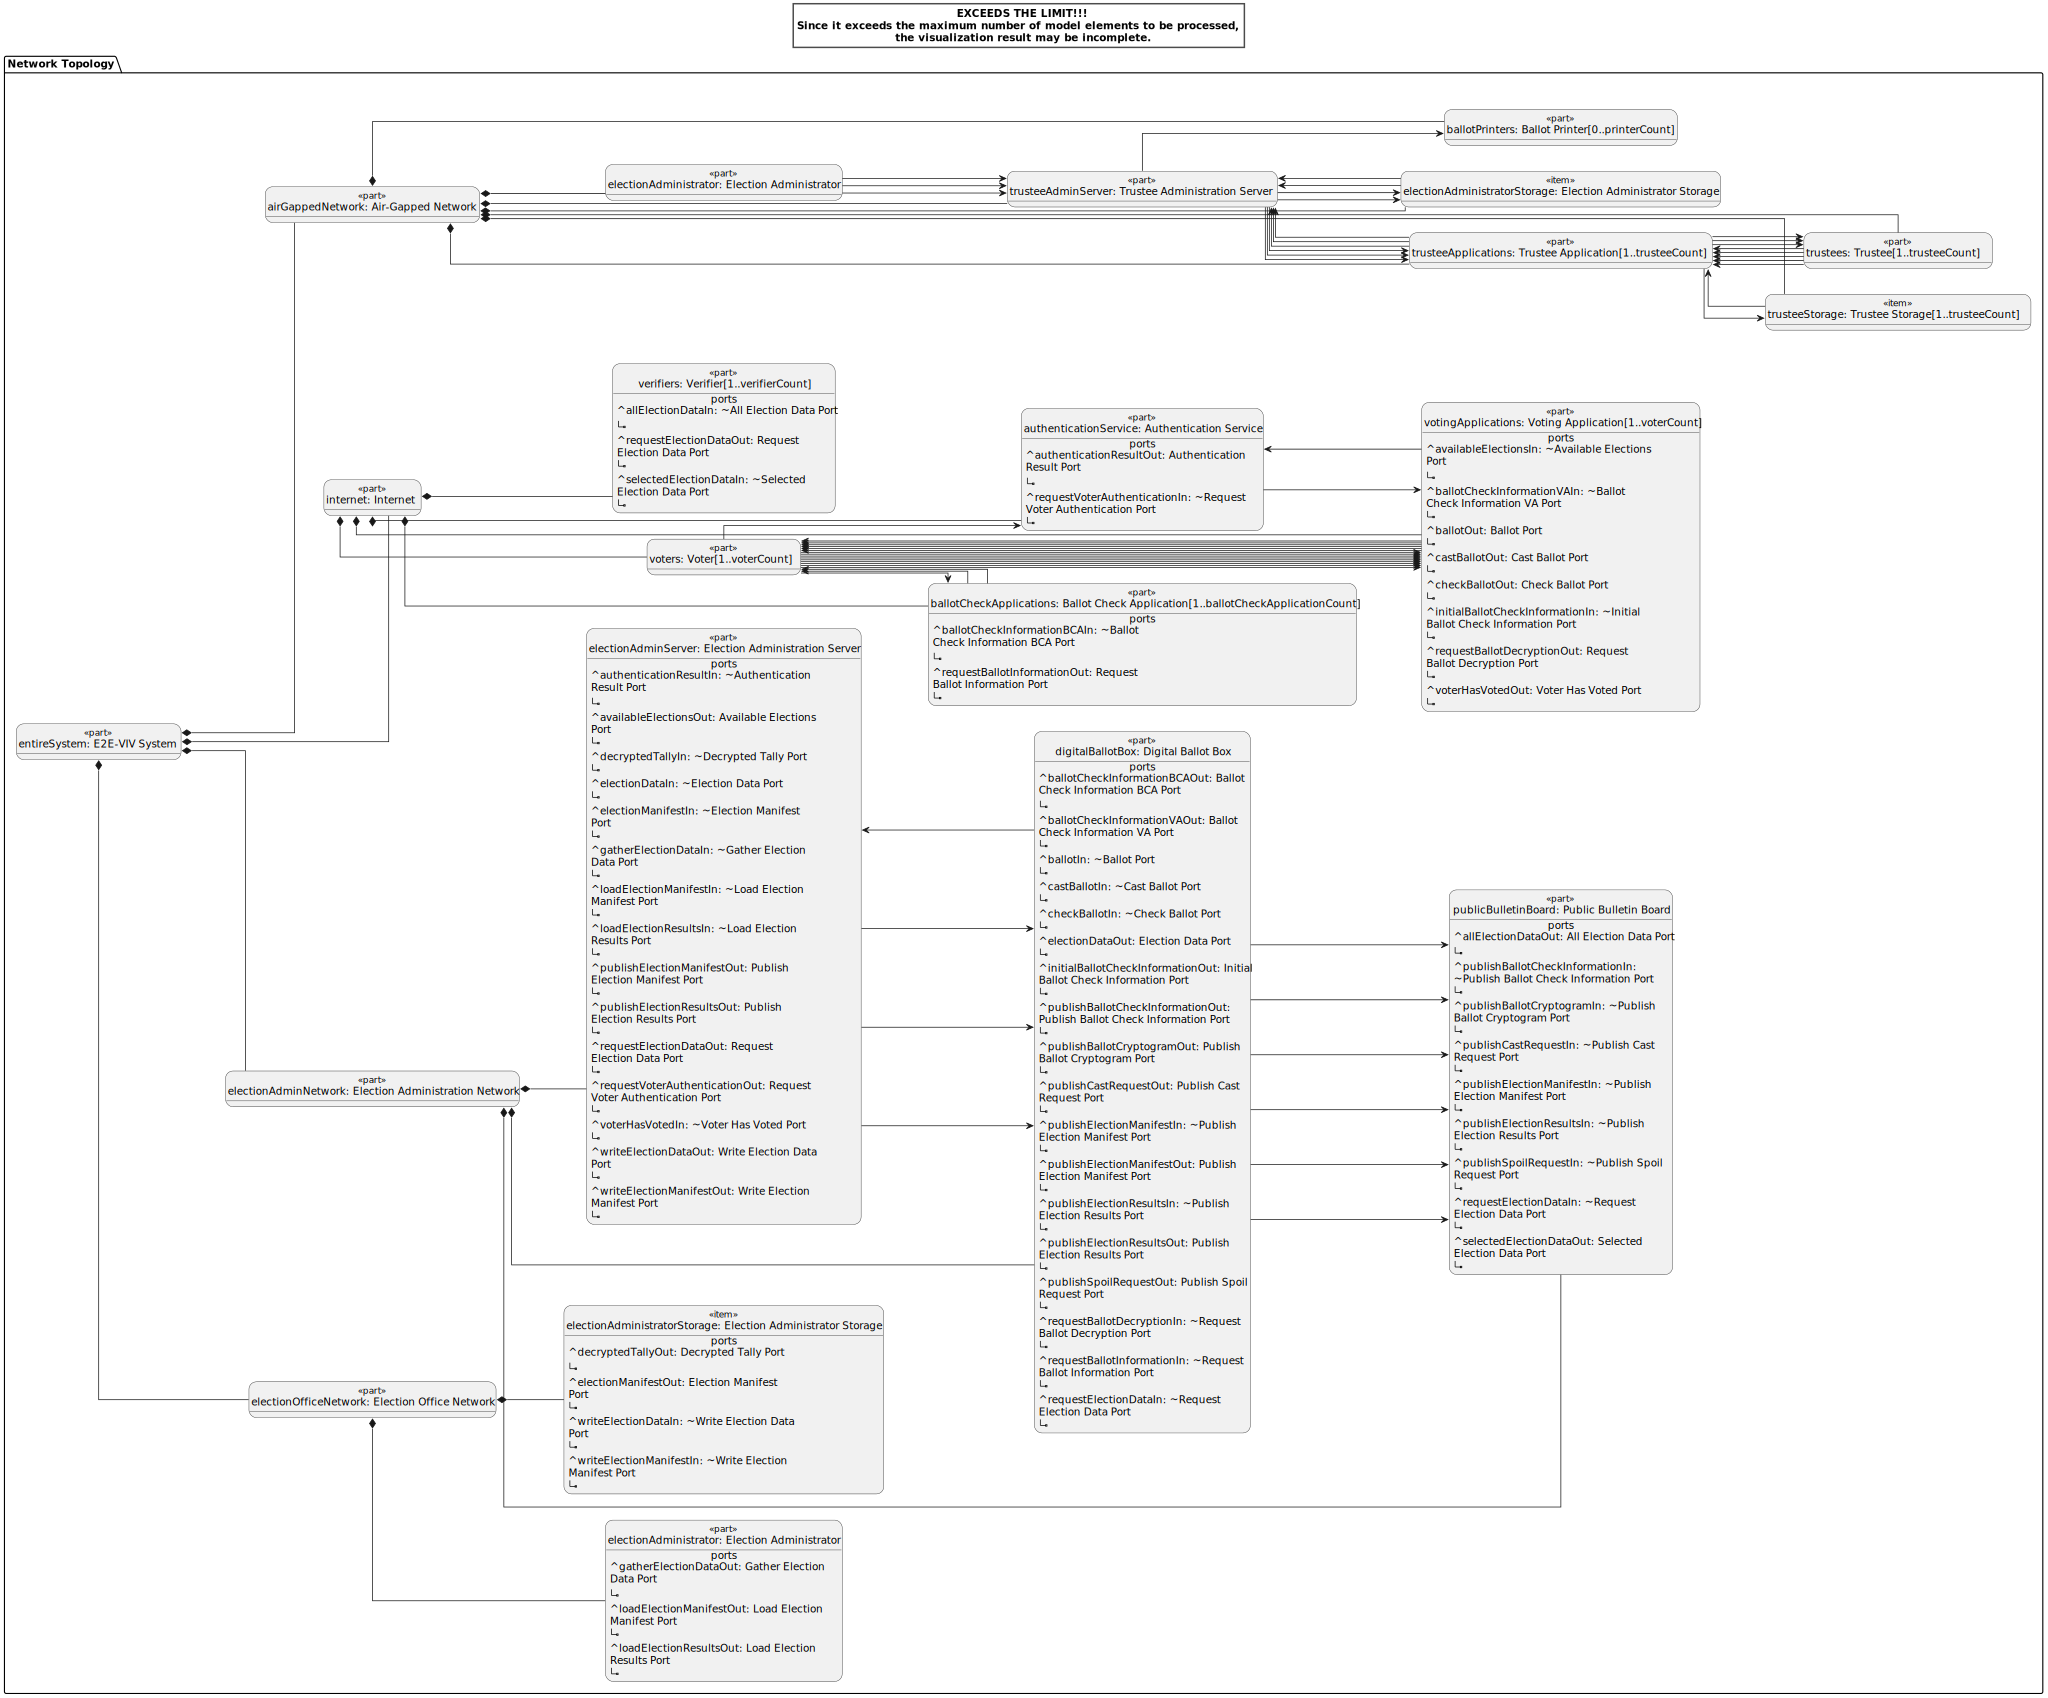

In [48]:
%viz --view=tree --style ORTHOLINE --style COMPTREE --style LR "Network Topology"

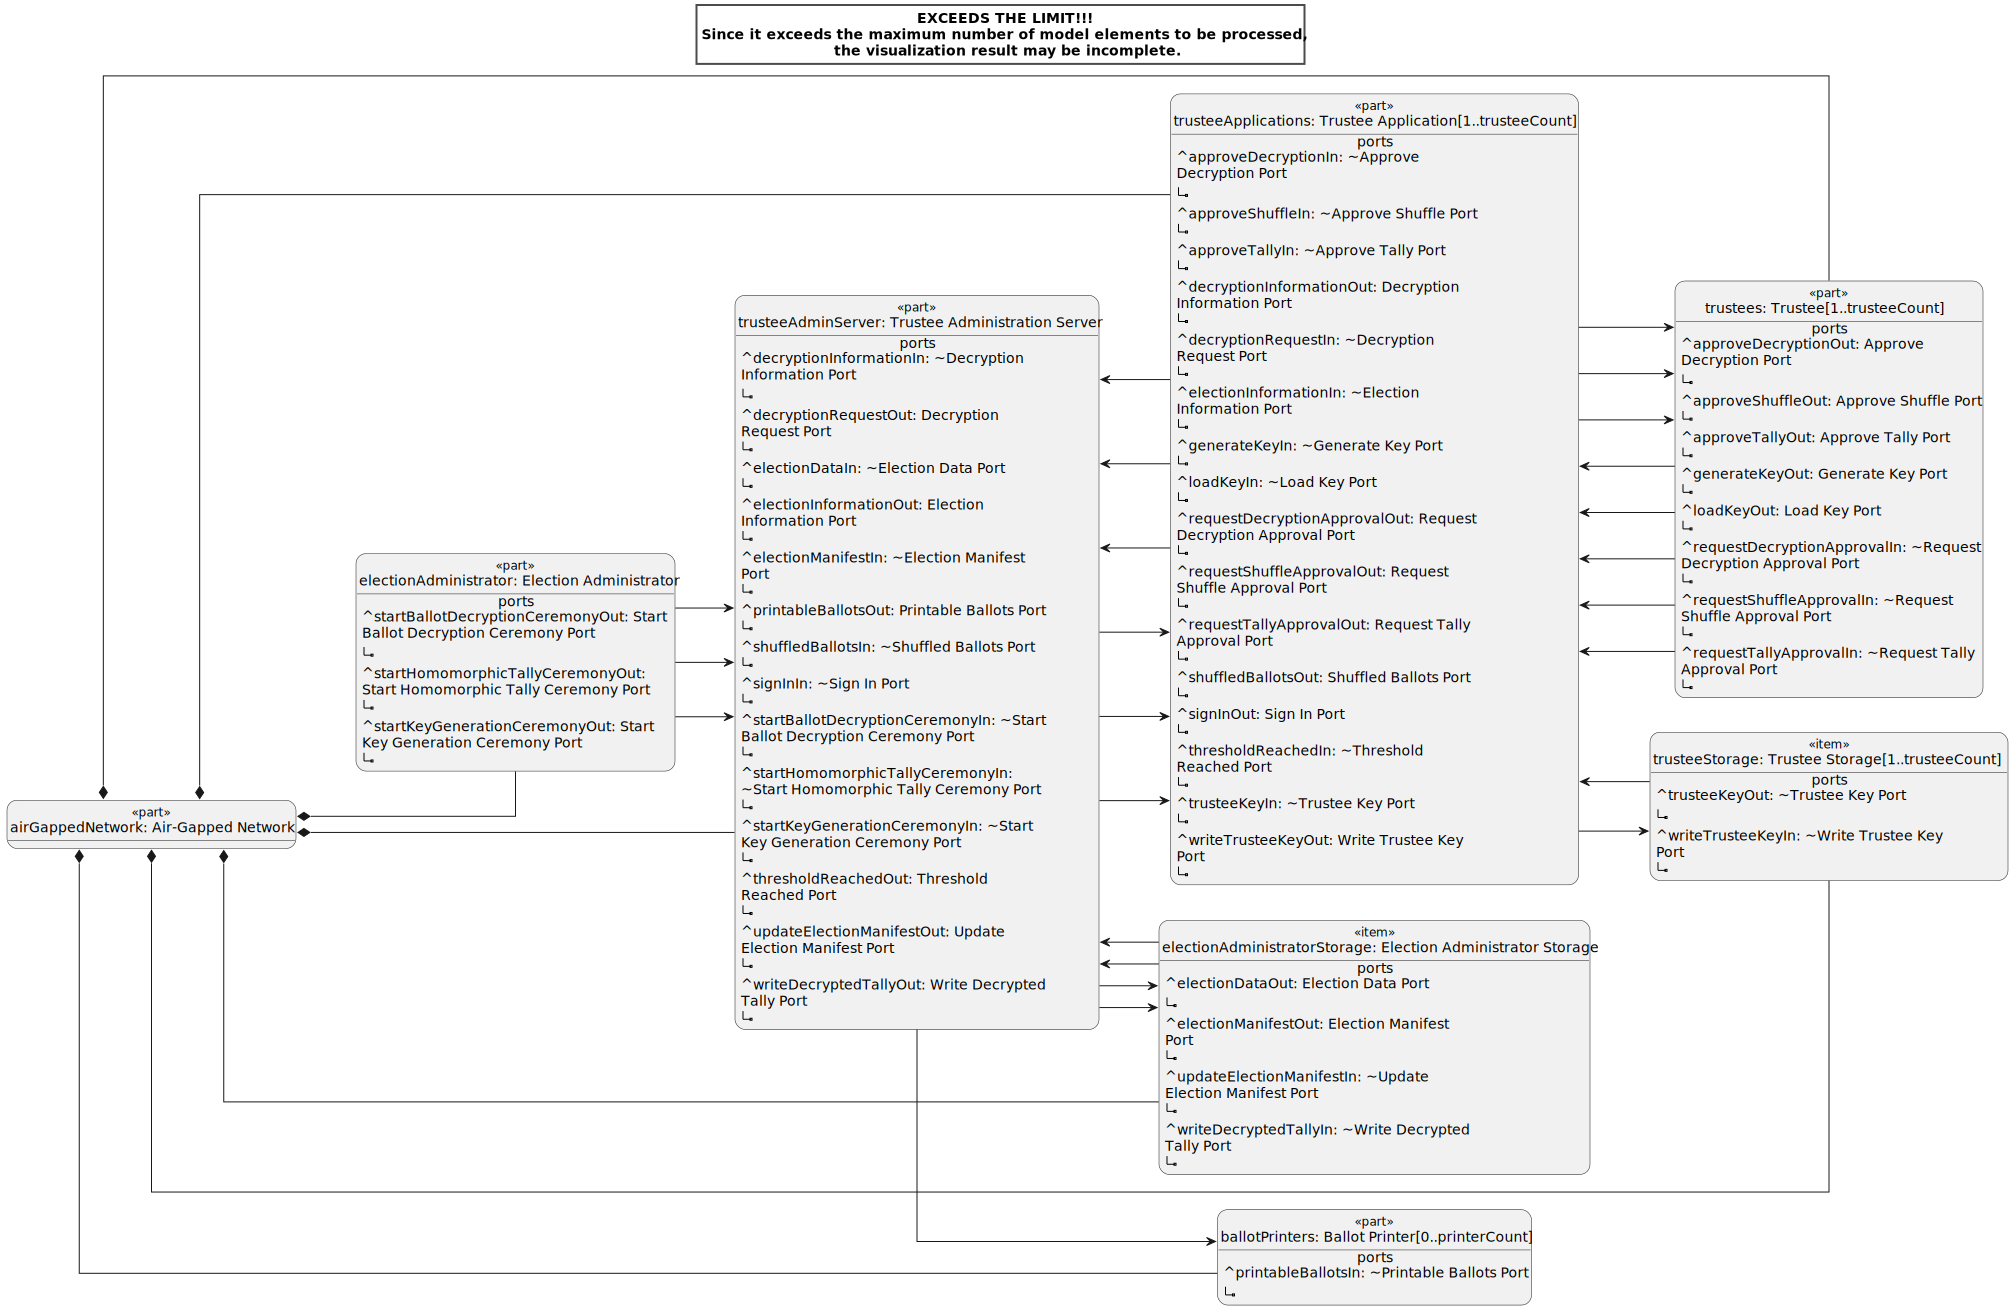

In [49]:
%viz --view=tree --style ORTHOLINE --style COMPTREE --style LR "Network Topology::entireSystem::airGappedNetwork"

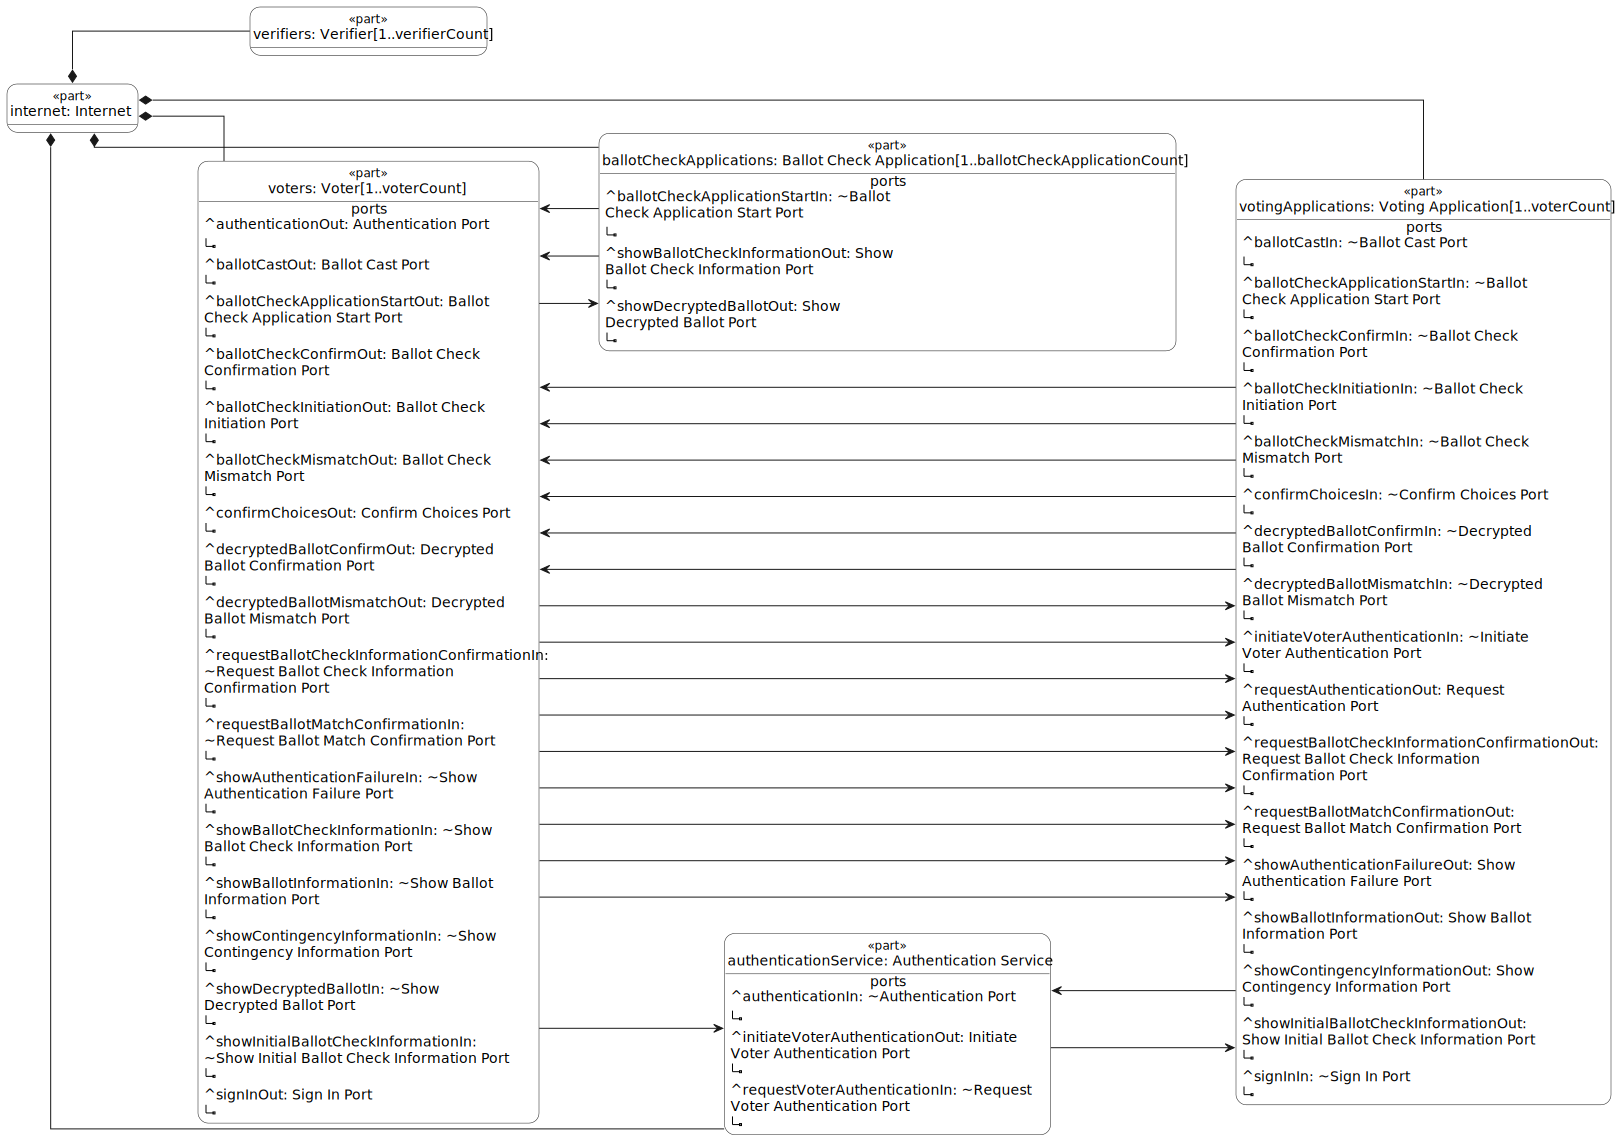

In [50]:
%viz --view=tree --style ORTHOLINE --style COMPTREE --style LR "Network Topology::entireSystem::internet"

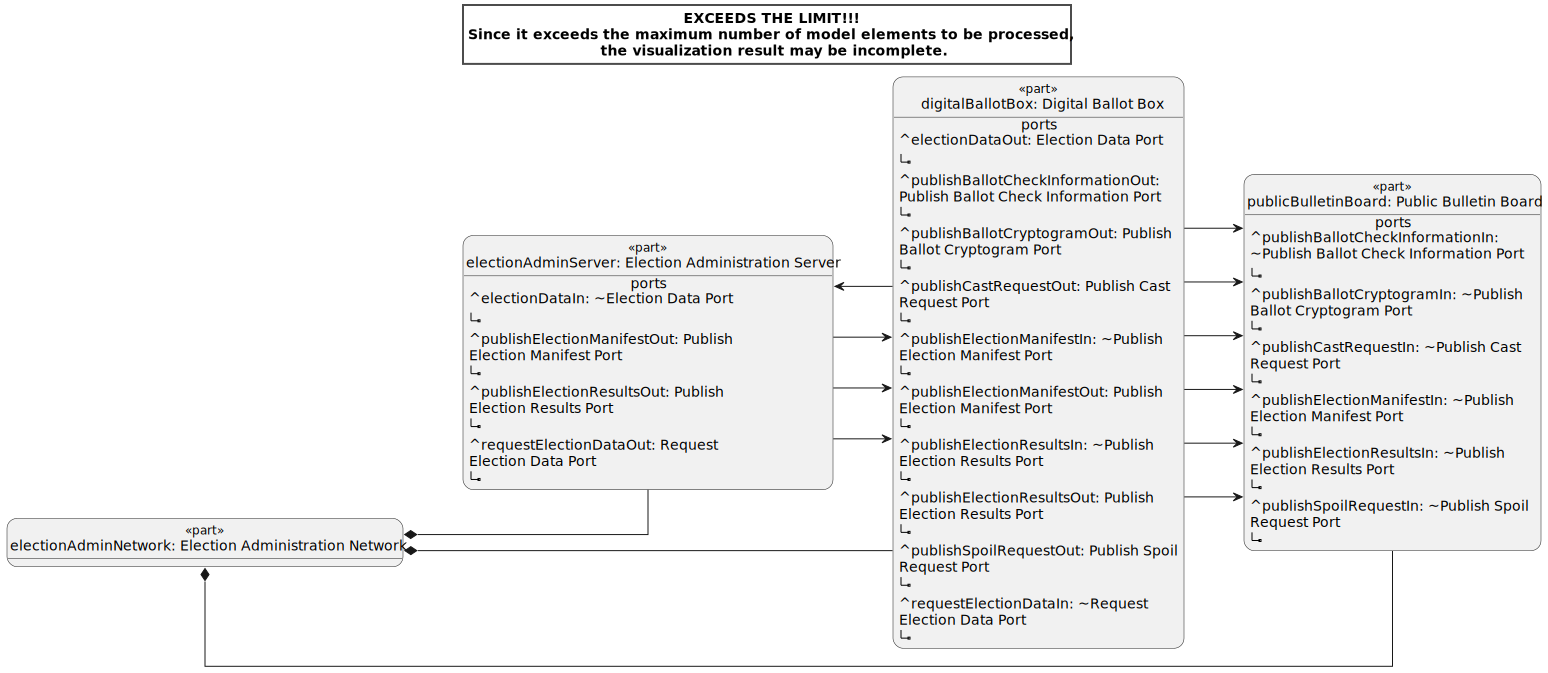

In [51]:
%viz --view=tree --style ORTHOLINE --style COMPTREE --style LR "Network Topology::entireSystem::electionAdminNetwork"

Next, we'll define the system's events (from Lando) as SysMLv2 actions. Each action is associated with a specific message type.

In [52]:
package 'PrincipalActions' {
  // @design dmz It's not clear to me whether this package is actually necessary, given the way
  // use cases are specified later (as sequences of messages); actions cannot, I think, be used
  // directly in use cases.
  
  doc /*
    This package defines the actions performed by principals within the 
    E2E-VIV system. Actions represent specific interactions among
    principals (actors and subsystems).
  */

  private import 'Messaging'::*;

  package 'Election Administrator Actions' {
    doc /* Actions taken by the election administrator. */
      
    action def 'Load Election Manifest' {
      doc /* The election administrator loads the election manifest into the election administration server. */
      out item msg: 'Election Administrator Messaging'::'Load Election Manifest';
    }

    action def 'Start Key Generation Ceremony' {
      doc /* The election administrator loads the election manifest into the trustee administration server and starts the key generation ceremony. */
      out item msg: 'Election Administrator Messaging'::'Start Key Generation Ceremony';
    }

    action def 'Gather Election Data' {
      doc /* The election administrator gets the election data from the election administration server. */
      out item msg: 'Election Administrator Messaging'::'Gather Election Data';
    }

    action def 'Start Ballot Decryption Ceremony' {
      doc /* The election administrator loads the election data into the trustee administration server and starts the ballot decryption ceremony. */
      out item msg: 'Election Administrator Messaging'::'Start Ballot Decryption Ceremony';
    }

    action def 'Start Homomorphic Tally Ceremony' {
      doc /* The election administrator loads the election data into the trustee administration server and starts the homomorphic tally ceremony. */
      out item msg: 'Election Administrator Messaging'::'Start Homomorphic Tally Ceremony';
    }

    action def 'Load Election Results' {
      doc /* The election administrator loads the election results into the election administration server. */
      out item msg: 'Election Administrator Messaging'::'Load Election Results';
    }
  }
  // end of Election Administrator Actions
  
  package 'Trustee Actions' {
    doc /* Actions taken by a trustee. */

    action def 'Generate Key' {
      doc /* A trustee attaches a storage device to a trustee application and signs in to the key generation process. */
      out item msg: 'Trustee Messaging'::'Generate Key';
    }

    action def 'Load Key' {
      doc /* A trustee attaches a storage device to a trustee application to load the private key material generated during the key generation process. */
      out item msg: 'Trustee Messaging'::'Load Key';
    }

    action def 'Approve Shuffle' {
      doc /* A trustee provides approval to begin the shuffle computation based on consensus among the trustees that the set of ballots is legitimate. */
      out item msg: 'Trustee Messaging'::'Approve Shuffle';
    }

    action def 'Approve Tally' {
      doc /* A trustee provides approval to begin the homomorphic tally based on consensus among the trustees that the set of ballots is legitimate. */
      out item msg: 'Trustee Messaging'::'Approve Tally';
    }

    action def 'Approve Decryption' {
      doc /* A trustee provides approval to decrypt the shuffled ballots and/or the homomorphic tally. */
      out item msg: 'Trustee Messaging'::'Approve Decryption';
    }
  }
  // end of Trustee Actions

  package 'Verifier Actions' {
    doc /* Actions taken by a verifier. */
    
    action def 'Request Election Data' {
      doc /* A verifier requests election data from the public bulletin board. */
      out item msg: 'Verifier Messaging'::'Request Election Data';
    }

    action def 'Report Results' {
      doc /* A verifier publicly reports the results of the verification they have carried out on public bulletin board data. */
      out item msg: 'Verifier Messaging'::'Report Results';
    }
  }
  // end of Verifier Actions

  package 'Voter Actions' {
    doc /* Actions taken by a voter. */
      
    action def 'Sign In' {
      doc /* A voter signs in to the voting application using their email address. */
      out item msg: 'Voter Messaging'::'Sign In';
    }

    action def 'Authenticate' {
      doc /* A voter provides authentication information to an authentication service. */
      out item msg: 'Voter Messaging'::'Authentication';
    }

    action def 'Confirm Choices' {
      doc /* A voter submits and confirms their choices on a ballot they are voting. */
      out item msg: 'Voter Messaging'::'Confirm Choices';
    }

    action def 'Initiate Ballot Check' {
      doc /* A voter tells the voting application to check a ballot on which they have confirmed their choices. */
      out item msg: 'Voter Messaging'::'Ballot Check Initiation';
    }

    action def 'Start Ballot Check Application' {
      doc /* A voter enters ballot check information into a ballot check application. */
      out item msg: 'Voter Messaging'::'Ballot Check Application Start';
    }

    action def 'Confirm Ballot Check' {
      doc /* A voter confirms that the ballot check information displayed in the voting application and ballot check application match, so that a ballot check can be performed. */
      out item msg: 'Voter Messaging'::'Ballot Check Confirmation';
    }

    action def 'Report Ballot Check Mismatch' {
      doc /* A voter reports that the ballot check information displayed in the voting application and ballot check application do not match, indicating a problem with the system. */
      out item msg: 'Voter Messaging'::'Ballot Check Mismatch';
    }

    action def 'Confirm Decrypted Ballot' {
      doc /* A voter confirms that the decrypted ballot displayed by a ballot check application matches their confirmed choices. */
      out item msg: 'Voter Messaging'::'Decrypted Ballot Confirmation';
    }

    action def 'Report Decrypted Ballot Mismatch' {
      doc /* A voter reports that the decrypted ballot displayed in the ballot check application does not match their confirmed choices, indicating a problem with the system. */
      out item msg: 'Voter Messaging'::'Decrypted Ballot Mismatch';
    }

    action def 'Cast Ballot' {
      doc /* A voter chooses to cast a ballot on which they have confirmed their choices. */
      out item msg: 'Voter Messaging'::'Ballot Cast';
    }
  }
  // end of Voter Actions

  package 'Authentication Service Actions' {
    doc /* Actions taken by the authentication service. */
      
    action def 'Initiate Voter Authentication' {
      doc /* The authentication service initiates authentication with the voter. */
      out item msg: 'Authentication Service Messaging'::'Initiate Voter Authentication';
    }

    action def 'Send Authentication Result' {
      doc /* The authentication service sends an authentication result to the election administration server. */
      out item msg: 'Authentication Service Messaging'::'Authentication Result';
    }
  }
  // end of Authentication Service Actions

  package 'Ballot Check Application Actions' {
    doc /* Actions taken by the ballot check application. */
  
    action def 'Request Ballot Information' {
      doc /* The ballot check application requests ballot information from the digital ballot box. */
      out item msg: 'Ballot Check Application Messaging'::'Request Ballot Information';
    }

    action def 'Show Ballot Check Information' {
      doc /* The ballot check application displays ballot check information to the voter. */
      out item msg: 'Ballot Check Application Messaging'::'Show Ballot Check Information';
    }

    action def 'Show Decrypted Ballot' {
      doc /* The ballot check application displays a decrypted ballot. */
      out item msg: 'Ballot Check Application Messaging'::'Show Decrypted Ballot';
    }
  }
  // end of Ballot Check Application Actions

  package 'Digital Ballot Box Actions' {
    doc /* Actions taken by the digital ballot box. */

    action def 'Send Initial Ballot Check Information' {
      doc /* The digital ballot box sends initial ballot check information for a voted ballot to the voting application. */
      out item msg: 'Digital Ballot Box Messaging'::'Initial Ballot Check Information';
    }

    action def 'Send Ballot Check Information to BCA' {
      doc /* The digital ballot box sends additional ballot check information to a ballot check application. */
      out item msg: 'Digital Ballot Box Messaging'::'Ballot Check Information BCA';
    }

    action def 'Send Ballot Check Information to VA' {
      doc /* The digital ballot box sends ballot check information to the voting application. */
      out item msg: 'Digital Ballot Box Messaging'::'Ballot Check Information VA';
    }

    action def 'Publish Ballot Cryptogram' {
      doc /* The digital ballot box publishes a ballot cryptogram containing voting choices to the public bulletin board. */
      out item msg: 'Digital Ballot Box Messaging'::'Publish Ballot Cryptogram';
    }

    action def 'Publish Spoil Request' {
      doc /* The digital ballot box publishes a spoil request for a ballot to the public bulletin board. */
      out item msg: 'Digital Ballot Box Messaging'::'Publish Spoil Request';
    }

    action def 'Publish Cast Request' {
      doc /* The digital ballot box publishes a cast request for a ballot to the public bulletin board. */
      out item msg: 'Digital Ballot Box Messaging'::'Publish Cast Request';
    }

    action def 'Publish Ballot Check Information' {
      doc /* The digital ballot box publishes ballot check information to the public bulletin board. */
      out item msg: 'Digital Ballot Box Messaging'::'Publish Ballot Check Information';
    }

    action def 'Publish Election Manifest' {
      doc /* The digital ballot box publishes the election manifest to the public bulletin board to start an election. */
      out item msg: 'Digital Ballot Box Messaging'::'Publish Election Manifest';
    }

    action def 'Publish Election Results' {
      doc /* The digital ballot box publishes the election results to the public bulletin board to end an election. */
      out item msg: 'Digital Ballot Box Messaging'::'Publish Election Results';
    }

    action def 'Send Election Data' {
      doc /* The digital ballot box sends election data to the election administration server. */
      out item msg: 'Digital Ballot Box Messaging'::'Election Data';
    }
  }
  // end of Digital Ballot Box Actions
  
  package 'Election Administration Server Actions' {
    doc /* Actions taken by the election administration server. */
      
    action def 'Request Voter Authentication' {
      doc /* The election administration server requests voter authentication for a specific voter from an authentication service. */
      out item msg: 'Election Administration Server Messaging'::'Request Voter Authentication';
    }

    action def 'Send Election Information' {
      doc /* The election administration server sends election information to a specific voter via the voting application, or informs them that authentication failed. */
      out item msg: 'Election Administration Server Messaging'::'Available Elections';
    }

    action def 'Write Election Manifest' {
      doc /* The election administration server writes the election manifest to a persistent storage device. */
      out item msg: 'Election Administration Server Messaging'::'Write Election Manifest';
    }

    action def 'Publish Election Manifest' {
      doc /* The election administration server publishes the election manifest. */
      out item msg: 'Election Administration Server Messaging'::'Publish Election Manifest';
    }

    action def 'Write Election Data' {
      doc /* The election administration server writes all election data to a persistent storage device. */
      out item msg: 'Election Administration Server Messaging'::'Write Election Data';
    }

    action def 'Request Election Data' {
      doc /* The election administration server requests all election data from the digital ballot box. */
      out item msg: 'Election Administration Server Messaging'::'Request Election Data';
    }

    action def 'Publish Election Results' {
      doc /* The election administration server publishes the election results. */
      out item msg: 'Election Administration Server Messaging'::'Publish Election Results';
    }
  }
  // end of Election Administration Server Actions
  
  package 'Public Bulletin Board Actions' {
    doc /* Actions taken by the public bulletin board. */
      
    action def 'Send All Election Data' {
      doc /* The public bulletin board sends all the election data it has upon request. */
      out item msg: 'Public Bulletin Board Messaging'::'All Election Data';
    }

    action def 'Send Selected Election Data' {
      doc /* The public bulletin board sends selected election data upon request. */
      out item msg: 'Public Bulletin Board Messaging'::'Selected Election Data';
    }
  }
  // end of Public Bulletin Board Actions
  
  package 'Trustee Application Actions' {
    doc /* Actions taken by the trustee application. */
      
    action def 'Sign In' {
      doc /* The trustee application authenticates to the trustee administration server. */
      out item msg: 'Trustee Application Messaging'::'Sign In';
    }

    action def 'Write Trustee Key' {
      doc /* The trustee application writes the generated trustee key material to persistent storage. */
      out item msg: 'Trustee Application Messaging'::'Write Trustee Key';
    }

    action def 'Request Shuffle Approval' {
      doc /* The trustee application requests approval from the trustee to perform the shuffle. */
      out item msg: 'Trustee Application Messaging'::'Request Shuffle Approval';
    }

    action def 'Request Tally Approval' {
      doc /* The trustee application requests approval from the trustee to perform a homomorphic tally. */
      out item msg: 'Trustee Application Messaging'::'Request Tally Approval';
    }

    action def 'Request Decryption Approval' {
      doc /* The trustee application requests approval from the trustee to decrypt results. */
      out item msg: 'Trustee Application Messaging'::'Request Decryption Approval';
    }

    action def 'Send Shuffled Ballots' {
      doc /* The trustee application sends shuffled ballots to the trustee administration server. */
      out item msg: 'Trustee Application Messaging'::'Shuffled Ballots';
    }

    action def 'Send Decryption Information' {
      doc /* The trustee application sends information to the trustee administration server to decrypt the shuffled ballots. */
      out item msg: 'Trustee Application Messaging'::'Decryption Information';
    }
  }
  // end of Trustee Application Actions

  package 'Trustee Administration Server Actions' {
    doc /* Actions taken by the trustee administration server. */

    action def 'Send Threshold Reached' {
      doc /* The trustee administration server notifies the trustee applications that enough trustees have signed in to begin the shuffling and decryption process. */
      out item msg: 'Trustee Administration Server Messaging'::'Threshold Reached';
    }

    action def 'Send Election Information' {
      doc /* The trustee administration server sends election information to the trustee applications. */
      out item msg: 'Trustee Administration Server Messaging'::'Election Information';
    }

    action def 'Send Decryption Request' {
      doc /* The trustee administration server sends a decryption request to the trustee applications. */
      out item msg: 'Trustee Administration Server Messaging'::'Decryption Request';
    }

    action def 'Write Decrypted Tally' {
      doc /* The trustee administration server writes the decrypted tally to persistent storage (only for homomorphic tallying). */
      out item msg: 'Trustee Administration Server Messaging'::'Write Decrypted Tally';
    }

    action def 'Send Ballots to Printer' {
      doc /* The trustee administration server sends the decrypted and shuffled ballots to the ballot printer. */
      out item msg: 'Trustee Administration Server Messaging'::'Printable Ballots';
    }

    action def 'Update Election Manifest' {
      doc /* The trustee administration server updates the election manifest in persistent storage. */
      out item msg: 'Trustee Administration Server Messaging'::'Update Election Manifest';
    }
  }
  // end of Trustee Administration Server Actions

  package 'Voting Application Actions' {
    doc /* Actions taken by the Voting Application. */
  
    action def 'Request Authentication' {
      doc /* The voting application initiates the voter authentication process with the election administration server. */
      out item msg: 'Voting Application Messaging'::'Request Authentication';
    }
  
    action def 'Show Ballot Information' {
      doc /* The voting application shows ballot information to the voter. */
      out item msg: 'Voting Application Messaging'::'Show Ballot Information';
    }
  
    action def 'Show Authentication Failure' {
      doc /* The voting application shows information to the voter about their authentication having failed. */
      out item msg: 'Voting Application Messaging'::'Show Authentication Failure';
    }
  
    action def 'Send Ballot' {
      doc /* The voting application sends a voted ballot to the digital ballot box. */
      out item msg: 'Voting Application Messaging'::'Ballot';
    }
  
    action def 'Show Initial Ballot Check Information' {
      doc /* The voting application shows information to the voter that can be used to initiate the ballot check process. */
      out item msg: 'Voting Application Messaging'::'Show Initial Ballot Check Information';
    }
  
    action def 'Check Ballot' {
      doc /* The voting application sends a check ballot request to the digital ballot box. */
      out item msg: 'Voting Application Messaging'::'Check Ballot';
    }
  
    action def 'Request Ballot Check Information Confirmation' {
      doc /* The voting application requests confirmation from the voter that the ballot check information displayed in a ballot check application matches the ballot check information displayed in the voting application. */
      out item msg: 'Voting Application Messaging'::'Request Ballot Check Information Confirmation';
    }
  
    action def 'Request Ballot Decryption' {
      doc /* The voting application sends a request for the decryption of a spoiled ballot to the digital ballot box. */
      out item msg: 'Voting Application Messaging'::'Request Ballot Decryption';
    }
  
    action def 'Request Ballot Match Confirmation' {
      doc /* The voting application requests confirmation from the voter that the decrypted ballot displayed in the ballot check application matches the voter's original selections. */
      out item msg: 'Voting Application Messaging'::'Request Ballot Match Confirmation';
    }
  
    action def 'Cast Ballot' {
      doc /* The voting application sends a cast ballot request to the digital ballot box and records with the election administration server that the voter has voted. */
      out item msg: 'Voting Application Messaging'::'Cast Ballot';
    }
  
    action def 'Voter Has Voted' {
      doc /* The voting application sends a message to the election administration server indicating that the voter has voted. */
      out item msg: 'Voting Application Messaging'::'Voter Has Voted';
    }
  
    action def 'Show Contingency Information' {
      doc /* The voting application shows the voter information about what to do if the voting session could not be completed successfully (e.g., a failed ballot check or other failed cryptographic protocol interaction). */
      out item msg: 'Voting Application Messaging'::'Show Contingency Information';
    }
  }
  // end of Voting Application Actions

  package 'Election Administrator Storage Actions' {
    doc /* Actions taken by the Election Administrator Storage device. */
  
    action def 'Send Election Manifest' {
      doc /* The storage device sends the election manifest stored on it to an application. */
      out item msg: 'Election Administrator Storage Messaging'::'Election Manifest';
    }
  
    action def 'Send Election Data' {
      doc /* The storage device sends the election data stored on it to an application. */
      out item msg: 'Election Administrator Storage Messaging'::'Election Data';
    }
  
    action def 'Send Decrypted Tally' {
      doc /* The storage device sends the decrypted tally stored on it to an application. */
      out item msg: 'Election Administrator Storage Messaging'::'Decrypted Tally';
    }
  }

  package 'Trustee Storage Actions' {
    doc /* Actions taken by the Trustee Storage device. */
  
    action def 'Send Trustee Key' {
      doc /* The storage device sends the trustee key stored on it to an application. */
      out item msg: 'Trustee Storage Messaging'::'Trustee Key';
    }
  }
}

Package PrincipalActions (78e77c8c-ea20-495a-9159-8990430b871f)


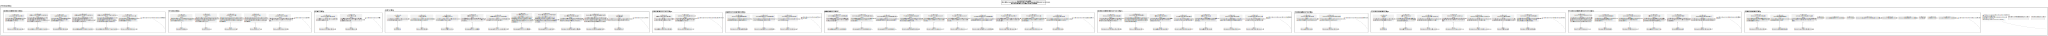

In [53]:
%viz PrincipalActions

Next, we define the scenarios of the E2E-VIV system as SysMLv2 use cases. (this is work in progress)

In [54]:
package 'E2E-VIV Scenarios' {
  doc /* 
    This package defines the use cases of the E2E-VIV system.
  */

  private import 'End-to-End Verifiable Internet Voting Cryptographic Core'::*;
  private import 'Actors'::*;
  private import 'Subsystems'::*;
  private import 'Messaging'::*;
  private import 'Assets'::*;

  use case def 'Trustee Key Generation' {
    objective {
      doc /*
        The election administrator convenes trustees for the trustee key generation ceremony and provides the election manifest to the trustee application server. The trustee application server orchestrates the generation of trustee keys by the trustee applications, which write those keys to trustee-held persistent storage devices for later use. It then writes information about the key generation ceremony (number of trustees, threshold, etc.) to the election administrator's storage device for export from the air-gapped network.
      */
    }
  
    subject e2eviv: 'E2E-VIV System';
  
    actor ea: EA;
    actor tas: TAS;
    // @design dmz Ideally, we'd like to say "e2eviv.trusteeCount" below, but for some reason we can't,
    // and it's not clear how to do that or if it's possible... so I've just chosen 3 trustees.
    actor ta: TA[1..3];
    actor trustee: T[1..3];
    actor sd: 'Election Administrator Storage';
      
    message startKeyGenerationCeremony of 'Election Administrator Messaging'::'Start Key Generation Ceremony'  
      from ea.sendStartKeyGenerationCeremony to tas.recvStartKeyGenerationCeremony;
    message electionManifest of 'Election Administrator Storage Messaging'::'Election Manifest'
      from sd.sendElectionManifest to tas.recvElectionManifest;
    // The next three messages happen once for each trustee
    then message generateKey of 'Trustee Messaging'::'Generate Key'  
      from trustee.sendGenerateKey to ta.recvGenerateKey;
    then message signIn of 'Trustee Application Messaging'::'Sign In'  
      from ta.sendSignIn to tas.recvSignIn;
    then message writeTrusteeKey of 'Trustee Application Messaging'::'Write Trustee Key'  
      from ta.sendWriteTrusteeKey to ta.trusteeStorage.recvWriteTrusteeKey;
    then message updateElectionManifest of 'Trustee Administration Server Messaging'::'Update Election Manifest'  
      from tas.sendUpdateElectionManifest to sd.recvUpdateElectionManifest;
  }
  // end of Trustee Key Generation

  use case def 'Election Setup and Start' {
    objective {
      doc /*
        The election administrator loads a complete (post-key generation) election manifest into the election administration server.
      */
    }
  
    subject e2eviv: 'E2E-VIV System';
  
    actor ea: EA;
    actor eas: EAS;
    actor sd: 'Election Administrator Storage';
    message loadElectionManifest of 'Election Administrator Messaging'::'Load Election Manifest'  
      from ea.sendLoadElectionManifest to eas.recvLoadElectionManifest;
    message electionManifest of 'Election Administrator Storage Messaging'::'Election Manifest'
      from sd.sendElectionManifest to eas.recvElectionManifest; 
  }
  // end of Election Setup and Start

  use case def 'Successful Voter Authentication' {
    objective {
      doc /*
        The voter signs in to a voting application using their email address. The voter application requests voter authentication, and the voter authenticates to an authentication service. Authentication is successful and the voter is shown a ballot, if one is available.
      */
    }

    subject e2eviv: 'E2E-VIV System';

    actor v: V;
    actor va: VA;
    actor eas: EAS;
    actor auth: AS;

    message signIn of 'Voter Messaging'::'Sign In'  
      from v.sendSignIn to va.recvSignIn;
    message requestAuthentication of 'Voting Application Messaging'::'Request Authentication'  
      from va.sendRequestAuthentication to eas.recvRequestAuthentication;
    message requestVoterAuthentication of 'Election Administration Server Messaging'::'Request Voter Authentication'  
      from eas.sendRequestVoterAuthentication to auth.recvRequestVoterAuthentication;
    message initiateVoterAuthentication of 'Authentication Service Messaging'::'Initiate Voter Authentication'  
      from auth.sendInitiateVoterAuthentication to v.recvInitiateVoterAuthentication;
    message authentication of 'Voter Messaging'::'Authentication'
      from v.sendAuthentication to auth.recvAuthentication;
    message authenticationResult of 'Authentication Service Messaging'::'Authentication Result'  
      from auth.sendAuthenticationResult to eas.recvAuthenticationResult;
    message availableElections of 'Election Administration Server Messaging'::'Available Elections'  
      from eas.sendAvailableElections to va.recvAvailableElections;
    message showBallotInformation of 'Voting Application Messaging'::'Show Ballot Information'  
      from va.sendShowBallotInformation to v.recvShowBallotInformation;
  }
  // end of Successful Voter Authentication

  use case def 'Unsuccessful Voter Authentication' {
    objective {
      doc /*
        The voter signs in to a voting application using their email address. The voter application requests voter authentication, and the voter authenticates to an authentication service. Authentication is unsuccessful and the voter is shown information about what to do next.
      */
    }

    subject e2eviv: 'E2E-VIV System';

    actor v: V;
    actor va: VA;
    actor eas: EAS;
    actor auth: AS;

    message signIn of 'Voter Messaging'::'Sign In'  
      from v.sendSignIn to va.recvSignIn;
    message requestAuthentication of 'Voting Application Messaging'::'Request Authentication'  
      from va.sendRequestAuthentication to eas.recvRequestAuthentication;
    message requestVoterAuthentication of 'Election Administration Server Messaging'::'Request Voter Authentication'  
      from eas.sendRequestVoterAuthentication to auth.recvRequestVoterAuthentication;
    message initiateVoterAuthentication of 'Authentication Service Messaging'::'Initiate Voter Authentication'  
      from auth.sendInitiateVoterAuthentication to v.recvInitiateVoterAuthentication;
    message authenticationResult of 'Authentication Service Messaging'::'Authentication Result'  
      from auth.sendAuthenticationResult to eas.recvAuthenticationResult;
    message availableElections of 'Election Administration Server Messaging'::'Available Elections'  
      from eas.sendAvailableElections to va.recvAvailableElections;
    message showAuthenticationFailure of 'Voting Application Messaging'::'Show Authentication Failure'  
      from va.sendShowAuthenticationFailure to v.recvShowAuthenticationFailure;
  }
  // end of Unsuccessful Voter Authentication

  use case def 'Ballot Choice Selection and Initial Submission' {
    objective {
      doc /*
        The voter selects their ballot choices and submits them to the voting application. The voting application sends the ballot to the digital ballot box, then shows the voter ballot check information that can be used for checking the ballot.
      */
    }

    subject e2eviv: 'E2E-VIV System';

    actor v: V;
    actor va: VA;
    actor dbb: DBB;
    actor pbb: PBB;

    message confirmChoices of 'Voter Messaging'::'Confirm Choices'  
      from v.sendConfirmChoices to va.recvConfirmChoices;
    message ballot of 'Voting Application Messaging'::'Ballot'  
      from va.sendBallot to dbb.recvBallot;
    message publishBallotCryptogram of 'Digital Ballot Box Messaging'::'Publish Ballot Cryptogram'
      from dbb.sendPublishBallotCryptogram to pbb.recvPublishBallotCryptogram;
    message initialBallotCheckInformation of 'Digital Ballot Box Messaging'::'Initial Ballot Check Information'  
      from dbb.sendInitialBallotCheckInformation to va.recvInitialBallotCheckInformation;
    message showBallotCheckInformation of 'Voting Application Messaging'::'Show Initial Ballot Check Information'  
      from va.sendShowBallotCheckInformation to v.recvShowBallotCheckInformation;
  }
  // end of Ballot Choice Selection and Initial Submission

  use case def 'Successful Ballot Check' {
    objective {
      doc /*
        The voter elects to check their ballot and starts the ballot check application. The voting application sends a check request to the digital ballot box, and subsequently requests confirmation from the voter that the ballot check information displayed in the voting application and the ballot check application match. The voter confirms that they do, and the voting application requests ballot decryption. The ballot check application displays a decrypted ballot. The voting application requests confirmation from the voter that the decrypted ballot matches the voter's original choices, and the voter confirms that they match. The voting application then re-encrypts the ballot, sends it to the digital ballot box, and shows the voter new ballot check information for the resubmitted ballot.
      */
    }

    subject e2eviv: 'E2E-VIV System';

    actor v: V;
    actor va: VA;
    actor bca: BCA;
    actor dbb: DBB;
    actor pbb: PBB;

    message ballotCheckInitiation of 'Voter Messaging'::'Ballot Check Initiation'  
      from v.sendBallotCheckInitiation to va.recvBallotCheckInitiation;
    message ballotCheckApplicationStart of 'Voter Messaging'::'Ballot Check Application Start'  
      from v.sendBallotCheckApplicationStart to bca.recvBallotCheckApplicationStart;
    message checkBallot of 'Voting Application Messaging'::'Check Ballot'  
      from va.sendCheckBallot to dbb.recvCheckBallot;
    message requestBallotInformation of 'Ballot Check Application Messaging'::'Request Ballot Information'  
      from bca.sendRequestBallotInformation to dbb.recvRequestBallotInformation;
    message ballotCheckInformationVA of 'Digital Ballot Box Messaging'::'Ballot Check Information VA'
      from dbb.sendBallotCheckInformationVA to va.recvBallotCheckInformationVA;
    message ballotCheckInformationBCA of 'Digital Ballot Box Messaging'::'Ballot Check Information BCA'
      from dbb.sendBallotCheckInformationBCA to bca.recvBallotCheckInformationBCA;
    message requestBallotCheckInformationConfirmation of 'Voting Application Messaging'::'Request Ballot Check Information Confirmation'  
      from va.sendRequestBallotCheckInformationConfirmation to v.recvRequestBallotCheckInformationConfirmation;
    message showBallotCheckInformation of 'Ballot Check Application Messaging'::'Show Ballot Check Information'  
      from bca.sendShowBallotCheckInformation to v.recvShowBallotCheckInformation;
    message ballotCheckConfirm of 'Voter Messaging'::'Ballot Check Confirmation'  
      from v.sendBallotCheckConfirm to va.recvBallotCheckConfirm;
    message requestBallotDecryption of 'Voting Application Messaging'::'Request Ballot Decryption'  
      from va.sendRequestBallotDecryption to dbb.recvRequestBallotDecryption;
    message publishSpoilRequest of 'Digital Ballot Box Messaging'::'Publish Spoil Request'
      from dbb.sendPublishSpoilRequest to pbb.recvPublishSpoilRequest;
    message showDecryptedBallot of 'Ballot Check Application Messaging'::'Show Decrypted Ballot'  
      from bca.sendShowDecryptedBallot to v.recvShowDecryptedBallot;
    message requestBallotMatchConfirmation of 'Voting Application Messaging'::'Request Ballot Match Confirmation'  
      from va.sendRequestBallotMatchConfirmation to v.recvRequestBallotMatchConfirmation;
    message decryptedBallotConfirm of 'Voter Messaging'::'Decrypted Ballot Confirmation'  
      from v.sendDecryptedBallotConfirm to va.recvDecryptedBallotConfirm;
    message reencryptedBallot of 'Voting Application Messaging'::'Ballot'  
      from va.sendBallot to dbb.recvBallot;
    message newBallotCheckInformation of 'Digital Ballot Box Messaging'::'Initial Ballot Check Information'  
      from dbb.sendInitialBallotCheckInformation to va.recvInitialBallotCheckInformation;
    message showNewBallotCheckInformation of 'Voting Application Messaging'::'Show Initial Ballot Check Information'  
      from va.sendShowBallotCheckInformation to v.recvShowBallotCheckInformation;
  }
  // end of Successful Ballot Check

  use case def 'Unsuccessful Ballot Check - Mismatched Ballot Check Information' {
    objective {
      doc /*
        The voter elects to check their ballot and starts the ballot check application. The voting application sends a check request to the digital ballot box, and subsequently requests confirmation from the voter that the ballot check information displayed in the voting application and the ballot check application match. The voter reports that they do not match, and the voting application shows the voter contingency information.
      */
    }

    subject e2eviv: 'E2E-VIV System';

    actor v: V;
    actor va: VA;
    actor bca: BCA;
    actor dbb: DBB;

    message ballotCheckInitiation of 'Voter Messaging'::'Ballot Check Initiation'  
      from v.sendBallotCheckInitiation to va.recvBallotCheckInitiation;
    message ballotCheckApplicationStart of 'Voter Messaging'::'Ballot Check Application Start'  
      from v.sendBallotCheckApplicationStart to bca.recvBallotCheckApplicationStart;
    message checkBallot of 'Voting Application Messaging'::'Check Ballot'  
      from va.sendCheckBallot to dbb.recvCheckBallot;
    message requestBallotInformation of 'Ballot Check Application Messaging'::'Request Ballot Information'  
      from bca.sendRequestBallotInformation to dbb.recvRequestBallotInformation;
    message ballotCheckInformationVA of 'Digital Ballot Box Messaging'::'Ballot Check Information VA'
      from dbb.sendBallotCheckInformationVA to va.recvBallotCheckInformationVA;
    message ballotCheckInformationBCA of 'Digital Ballot Box Messaging'::'Ballot Check Information BCA'
      from dbb.sendBallotCheckInformationBCA to bca.recvBallotCheckInformationBCA;
    message requestBallotCheckInformationConfirmation of 'Voting Application Messaging'::'Request Ballot Check Information Confirmation'  
      from va.sendRequestBallotCheckInformationConfirmation to v.recvRequestBallotCheckInformationConfirmation;
    message showBallotCheckInformation of 'Ballot Check Application Messaging'::'Show Ballot Check Information'  
      from bca.sendShowBallotCheckInformation to v.recvShowBallotCheckInformation;
    message ballotCheckMismatch of 'Voter Messaging'::'Ballot Check Mismatch'  
      from v.sendBallotCheckMismatch to va.recvBallotCheckMismatch;
    message showContingencyInformation of 'Voting Application Messaging'::'Show Contingency Information'  
      from va.sendShowContingencyInformation to v.recvShowContingencyInformation;
  }
  // end of Unsuccessful Ballot Check - Mismatched Ballot Check Information

  use case def 'Unsuccessful Ballot Check - Mismatched Ballot Selections' {
    objective {
      doc /*
        The voter elects to check their ballot and starts the ballot check application. The voting application sends a check request to the digital ballot box, and subsequently requests confirmation from the voter that the ballot check information displayed in the voting application and the ballot check application match. The voter confirms that they do, and the voting application requests ballot decryption. The ballot check application displays the decrypted ballot. The voting application requests confirmation from the voter that the decrypted ballot matches their original selections, and the voter reports that they do not match. The voting application shows the voter contingency information.
      */
    }

    subject e2eviv: 'E2E-VIV System';

    actor v: V;
    actor va: VA;
    actor bca: BCA;
    actor dbb: DBB;
    actor pbb: PBB;

    message ballotCheckInitiation of 'Voter Messaging'::'Ballot Check Initiation'  
      from v.sendBallotCheckInitiation to va.recvBallotCheckInitiation;
    message ballotCheckApplicationStart of 'Voter Messaging'::'Ballot Check Application Start'  
      from v.sendBallotCheckApplicationStart to bca.recvBallotCheckApplicationStart;
    message checkBallot of 'Voting Application Messaging'::'Check Ballot'  
      from va.sendCheckBallot to dbb.recvCheckBallot;
    message requestBallotInformation of 'Ballot Check Application Messaging'::'Request Ballot Information'  
      from bca.sendRequestBallotInformation to dbb.recvRequestBallotInformation;
    message ballotCheckInformationVA of 'Digital Ballot Box Messaging'::'Ballot Check Information VA'
      from dbb.sendBallotCheckInformationVA to va.recvBallotCheckInformationVA;
    message ballotCheckInformationBCA of 'Digital Ballot Box Messaging'::'Ballot Check Information BCA'
      from dbb.sendBallotCheckInformationBCA to bca.recvBallotCheckInformationBCA;
    message requestBallotCheckInformationConfirmation of 'Voting Application Messaging'::'Request Ballot Check Information Confirmation'  
      from va.sendRequestBallotCheckInformationConfirmation to v.recvRequestBallotCheckInformationConfirmation;
    message showBallotCheckInformation of 'Ballot Check Application Messaging'::'Show Ballot Check Information'  
      from bca.sendShowBallotCheckInformation to v.recvShowBallotCheckInformation;
    message ballotCheckConfirm of 'Voter Messaging'::'Ballot Check Confirmation'  
      from v.sendBallotCheckConfirm to va.recvBallotCheckConfirm;
    message requestBallotDecryption of 'Voting Application Messaging'::'Request Ballot Decryption'  
      from va.sendRequestBallotDecryption to dbb.recvRequestBallotDecryption;
    message publishSpoilRequest of 'Digital Ballot Box Messaging'::'Publish Spoil Request'
      from dbb.sendPublishSpoilRequest to pbb.recvPublishSpoilRequest;
    message showDecryptedBallot of 'Ballot Check Application Messaging'::'Show Decrypted Ballot'  
      from bca.sendShowDecryptedBallot to v.recvShowDecryptedBallot;
    message requestBallotMatchConfirmation of 'Voting Application Messaging'::'Request Ballot Match Confirmation'  
      from va.sendRequestBallotMatchConfirmation to v.recvRequestBallotMatchConfirmation;
    message decryptedBallotMismatch of 'Voter Messaging'::'Decrypted Ballot Mismatch'  
      from v.sendDecryptedBallotMismatch to va.recvDecryptedBallotMismatch;
    message showContingencyInformation of 'Voting Application Messaging'::'Show Contingency Information'  
      from va.sendShowContingencyInformation to v.recvShowContingencyInformation;
  }
  // end of Unsuccessful Ballot Check - Mismatched Ballot Selections

  use case def 'Ballot Cast' {
    objective {
      doc /*
        The voter elects to cast their ballot. The voting application sends a notification to the digital ballot box that the ballot has been cast, and a notification to the election administration server that the voter has voted.
      */
    }

    subject e2eviv: 'E2E-VIV System';

    actor v: V;
    actor va: VA;
    actor dbb: DBB;
    actor eas: EAS;

    message ballotCast of 'Voter Messaging'::'Ballot Cast'  
      from v.sendBallotCast to va.recvBallotCast;
    message castBallot of 'Voting Application Messaging'::'Cast Ballot'  
      from va.sendCastBallot to dbb.recvCastBallot;
    message voterHasVoted of 'Voting Application Messaging'::'Voter Has Voted'  
      from va.sendVoterHasVoted to eas.recvVoterHasVoted;
  }
  // end of Ballot Cast

  use case def 'Election Results Publication' {
    objective {
      doc /*
        The election administrator loads the election results (obtained from a count of physical ballots, or from a homomorphic tally) into the election administration server, which then publishes them.
      */
    }

    subject e2eviv: 'E2E-VIV System';

    actor ea: EA;
    actor eas: EAS;
    actor dbb: DBB;
    actor pbb: PBB;
    
    message loadElectionResults of 'Election Administrator Messaging'::'Load Election Results'  
      from ea.sendLoadElectionResults to eas.recvLoadElectionResults;
    message publishElectionResults of 'Election Administration Server Messaging'::'Publish Election Results'  
      from eas.sendPublishElectionResults to dbb.recvPublishElectionResults;
    message publishElectionResultsPBB of 'Digital Ballot Box Messaging'::'Publish Election Results'  
      from dbb.sendPublishElectionResults to pbb.recvPublishElectionResults;
  }
  // end of Election Results Publication

  use case def 'Successful Ballot Shuffle and Decryption' {
    objective {
      doc /* 
        The election administrator requests that the election administration server write all election data to a storage device, and it retrieves the election data from the digital ballot box and does so. The election administrator then enters the air-gapped network with the storage device, loads the election data into the trustee administration server, and starts the decryption ceremony. The trustees authenticate themselves to their trustee applications, supplying the private keys generated in the key generation ceremony, and a sufficient number of them are present to perform the mixing and decryption. The trustee application server sends election information to the trustee applications, and a sufficient number of the trustees view this information and approve the beginning of the mixing process. The trustee applications perform the shuffle, and the trustee application server then sends information to the trustees so that they can approve the decryption of the shuffled ballots, which they do. The ballots are then decrypted and printed, and election information is written to the election administrator's storage device for export from the air-gapped network. 
      */
    }
    
    subject e2eviv: 'E2E-VIV System';
  
    actor ea: EA;
    actor eas: EAS;
    actor dbb: DBB;
    actor tas: TAS;
    // @design dmz Ideally, we'd like to say "e2eviv.trusteeCount" below, but for some reason we can't,
    // and it's not clear how to do that or if it's possible... so I've just chosen 3 trustees.
    actor ta: TA[1..3]; 
    actor trustee: T[1..3];
    actor bp: BP;
    actor sd: 'Election Administrator Storage';
      
    message gatherElectionData of 'Election Administrator Messaging'::'Gather Election Data' 
      from ea.sendGatherElectionData to eas.recvGatherElectionData;
    then message requestElectionData of 'Election Administration Server Messaging'::'Request Election Data' 
      from eas.sendRequestElectionData to dbb.recvRequestElectionData;
    then message electionDataDBB of 'Digital Ballot Box Messaging'::'Election Data' 
      from dbb.sendElectionData to eas.recvElectionData;
    then message writeElectionData of 'Election Administration Server Messaging'::'Write Election Data' 
      from eas.sendWriteElectionData to sd.recvWriteElectionData;
    then message startBallotDecryptionCeremony of 'Election Administrator Messaging'::'Start Ballot Decryption Ceremony' 
      from ea.sendStartBallotDecryptionCeremony to tas.recvStartBallotDecryptionCeremony;
    then message electionManifest of 'Election Administrator Storage Messaging'::'Election Manifest'
      from sd.sendElectionManifest to tas.recvElectionManifest;
    then message electionDataSD of 'Election Administrator Storage Messaging'::'Election Data'
      from sd.sendElectionData to tas.recvElectionData;
    // The next messages happen some number of times greater than or equal to the trustee threshold.
    then message loadKey of 'Trustee Messaging'::'Load Key' 
      from trustee.sendLoadKey to ta.recvLoadKey;
    then message keyLoaded of 'Trustee Application Messaging'::'Key Loaded' 
      from ta.sendKeyLoaded to tas.recvKeyLoaded;
    // For the remainder, assume for messages involving trustees/trustee applications that they occur
    // some number of times greater than the trustee threshold.
    then message thresholdReached of 'Trustee Administration Server Messaging'::'Threshold Reached' 
      from tas.sendThresholdReached to ta.recvThresholdReached;
    then message electionInformation of 'Trustee Administration Server Messaging'::'Election Information' 
      from tas.sendElectionInformation to ta.recvElectionInformation;
    then message requestShuffleApproval of 'Trustee Application Messaging'::'Request Shuffle Approval' 
      from ta.sendRequestShuffleApproval to trustee.recvRequestShuffleApproval;
    then message approveShuffle of 'Trustee Messaging'::'Approve Shuffle' 
      from trustee.sendApproveShuffle to ta.recvApproveShuffle;
    then message shuffledBallots of 'Trustee Application Messaging'::'Shuffled Ballots' 
      from ta.sendShuffledBallots to tas.recvShuffledBallots;
    then message decryptionRequest of 'Trustee Administration Server Messaging'::'Decryption Request' 
      from tas.sendDecryptionRequest to ta.recvDecryptionRequest;
    then message requestDecryptionApproval of 'Trustee Application Messaging'::'Request Decryption Approval' 
      from ta.sendRequestDecryptionApproval to trustee.recvRequestDecryptionApproval;
    then message approveDecryption of 'Trustee Messaging'::'Approve Decryption' 
      from trustee.sendApproveDecryption to ta.recvApproveDecryption;
    then message decryptionInformation of 'Trustee Application Messaging'::'Decryption Information' 
      from ta.sendDecryptionInformation to tas.recvDecryptionInformation;
    then message printableBallots of 'Trustee Administration Server Messaging'::'Printable Ballots' 
      from tas.sendPrintableBallots to bp.recvPrintableBallots;
    then message updateElectionManifest of 'Trustee Administration Server Messaging'::'Update Election Manifest' 
      from tas.sendUpdateElectionManifest to sd.recvUpdateElectionManifest;
  }
  // end of Successful Ballot Shuffle and Decryption

  use case def 'Unsuccessful Ballot Shuffle and Decryption - Insufficient Trustees' {
    objective {
      doc /* 
        The election administrator requests that the election administration server write all election data to a storage device, and it retrieves the election data from the digital ballot box and does so. The election administrator then enters the air-gapped network with the storage device, loads the election data into the trustee administration server, and starts the decryption ceremony. The trustees authenticate themselves to their trustee applications, supplying the private keys generated in the key generation ceremony, but not enough of them are present to perform the mixing and decryption. The ceremony ends unsuccessfully and the ballots are neither shuffled nor decrypted. 
      */
    }
    
    subject e2eviv: 'E2E-VIV System';
  
    actor ea: EA;
    actor eas: EAS;
    actor dbb: DBB;
    actor tas: TAS;
    // @design dmz Ideally, we'd like to say "e2eviv.trusteeCount" below, but for some reason we can't,
    // and it's not clear how to do that or if it's possible... so I've just chosen 3 trustees.
    actor ta: TA[1..3];
    actor trustee: T[1..3];
    actor sd: 'Election Administrator Storage';

    message gatherElectionData of 'Election Administrator Messaging'::'Gather Election Data' 
      from ea.sendGatherElectionData to eas.recvGatherElectionData;
    then message requestElectionData of 'Election Administration Server Messaging'::'Request Election Data' 
      from eas.sendRequestElectionData to dbb.recvRequestElectionData;
    then message electionDataDBB of 'Digital Ballot Box Messaging'::'Election Data' 
      from dbb.sendElectionData to eas.recvElectionData;
    then message writeElectionData of 'Election Administration Server Messaging'::'Write Election Data' 
      from eas.sendWriteElectionData to sd.recvWriteElectionData;
    then message startBallotDecryptionCeremony of 'Election Administrator Messaging'::'Start Ballot Decryption Ceremony' 
      from ea.sendStartBallotDecryptionCeremony to tas.recvStartBallotDecryptionCeremony;
    then message electionManifest of 'Election Administrator Storage Messaging'::'Election Manifest' 
      from sd.sendElectionManifest to tas.recvElectionManifest;
    then message electionDataSD of 'Election Administrator Storage Messaging'::'Election Data' 
      from sd.sendElectionData to tas.recvElectionData;
    // The next messages happen some number of times less than the trustee threshold.
    then message loadKey of 'Trustee Messaging'::'Load Key' 
      from trustee.sendLoadKey to ta.recvLoadKey;
    then message keyLoaded of 'Trustee Application Messaging'::'Key Loaded' 
      from ta.sendKeyLoaded to tas.recvKeyLoaded;
    // The process ends unsuccessfully as an insufficient number of trustees are participating.
  } 
  // end of Unsuccessful Ballot Shuffle and Decryption - Insufficient Trustees

  use case def 'Unsuccessful Ballot Shuffle and Decryption - Insufficient Trustee Shuffle Approval' {
    objective {
      doc /* 
        The election administrator requests that the election administration server write all election data to a storage device, and it retrieves the election data from the digital ballot box and does so. The election administrator then enters the air-gapped network with the storage device, loads the election data into the trustee administration server, and starts the decryption ceremony. The trustees authenticate themselves to their trustee applications, supplying the private keys generated in the key generation ceremony, and a sufficient number of them are present to perform the mixing and decryption. The trustee application server sends election information to the trustee applications, but not enough of the trustees view this information and approve the beginning of the mixing process. The ceremony ends and the ballots are neither shuffled nor decrypted. 
      */
    }
    
    subject e2eviv: 'E2E-VIV System';
  
    actor ea: EA;
    actor eas: EAS;
    actor dbb: DBB;
    actor tas: TAS;
    // @design dmz Ideally, we'd like to say "e2eviv.trusteeCount" below, but for some reason we can't,
    // and it's not clear how to do that or if it's possible... so I've just chosen 3 trustees.
    actor ta: TA[1..3];
    actor trustee: T[1..3];
    actor sd: 'Election Administrator Storage';

    message gatherElectionData of 'Election Administrator Messaging'::'Gather Election Data' 
      from ea.sendGatherElectionData to eas.recvGatherElectionData;
    then message requestElectionData of 'Election Administration Server Messaging'::'Request Election Data' 
      from eas.sendRequestElectionData to dbb.recvRequestElectionData;
    then message electionDataDBB of 'Digital Ballot Box Messaging'::'Election Data' 
      from dbb.sendElectionData to eas.recvElectionData;
    then message writeElectionData of 'Election Administration Server Messaging'::'Write Election Data' 
      from eas.sendWriteElectionData to sd.recvWriteElectionData;
    then message startBallotDecryptionCeremony of 'Election Administrator Messaging'::'Start Ballot Decryption Ceremony' 
      from ea.sendStartBallotDecryptionCeremony to tas.recvStartBallotDecryptionCeremony;
    then message electionManifest of 'Election Administrator Storage Messaging'::'Election Manifest' 
      from sd.sendElectionManifest to tas.recvElectionManifest;
    then message electionDataSD of 'Election Administrator Storage Messaging'::'Election Data' 
      from sd.sendElectionData to tas.recvElectionData;
    // The next messages happen some number of times greater than or equal to the trustee threshold.
    then message loadKey of 'Trustee Messaging'::'Load Key' 
      from trustee.sendLoadKey to ta.recvLoadKey;
    then message keyLoaded of 'Trustee Application Messaging'::'Key Loaded' 
      from ta.sendKeyLoaded to tas.recvKeyLoaded;
    then message thresholdReached of 'Trustee Administration Server Messaging'::'Threshold Reached' 
      from tas.sendThresholdReached to ta.recvThresholdReached;
    then message electionInformation of 'Trustee Administration Server Messaging'::'Election Information' 
      from tas.sendElectionInformation to ta.recvElectionInformation;
    then message requestShuffleApproval of 'Trustee Application Messaging'::'Request Shuffle Approval' 
      from ta.sendRequestShuffleApproval to trustee.recvRequestShuffleApproval;
    // The next messages happen some number of times less than the trustee threshold.
    then message approveShuffle of 'Trustee Messaging'::'Approve Shuffle' 
      from trustee.sendApproveShuffle to ta.recvApproveShuffle;
    then message shuffledBallots of 'Trustee Application Messaging'::'Shuffled Ballots' 
      from ta.sendShuffledBallots to tas.recvShuffledBallots;
    // The process ends unsuccessfully due to insufficient shuffle approval.
  } 
  // end of Unsuccessful Ballot Shuffle and Decryption - Insufficient Trustee Shuffle Approval

  use case def 'Unsuccessful Ballot Shuffle and Decryption - Insufficient Trustee Decryption Approval' {
    objective {
      doc /* 
        The election administrator requests that the election administration server write all election data to a storage device, and it retrieves the election data from the digital ballot box and does so. The election administrator then enters the air-gapped network with the storage device, loads the election data into the trustee administration server, and starts the decryption ceremony. The trustees authenticate themselves to their trustee applications, supplying the private keys generated in the key generation ceremony, and a sufficient number of them are present to perform the mixing and decryption. The trustee application server sends election information to the trustee applications, and a sufficient number of the trustees view this information and approve the beginning of the mixing process. The trustee applications perform the shuffle, and the trustee application server then sends information to the trustees so that they can approve the decryption of the shuffled ballots, but not enough of them do. The ceremony ends and the ballots are shuffled, but not decrypted.
      */
    }
    
    subject e2eviv: 'E2E-VIV System';
  
    actor ea: EA;
    actor eas: EAS;
    actor dbb: DBB;
    actor tas: TAS;
    // @design dmz Ideally, we'd like to say "e2eviv.trusteeCount" below, but for some reason we can't,
    // and it's not clear how to do that or if it's possible... so I've just chosen 3 trustees.
    actor ta: TA[1..3];
    actor t: T[1..3];
    actor sd: 'Election Administrator Storage';

    message gatherElectionData of 'Election Administrator Messaging'::'Gather Election Data' 
      from ea.sendGatherElectionData to eas.recvGatherElectionData;
    then message requestElectionData of 'Election Administration Server Messaging'::'Request Election Data' 
      from eas.sendRequestElectionData to dbb.recvRequestElectionData;
    then message electionDataDBB of 'Digital Ballot Box Messaging'::'Election Data' 
      from dbb.sendElectionData to eas.recvElectionData;
    then message writeElectionData of 'Election Administration Server Messaging'::'Write Election Data' 
      from eas.sendWriteElectionData to sd.recvWriteElectionData;
    then message startBallotDecryptionCeremony of 'Election Administrator Messaging'::'Start Ballot Decryption Ceremony' 
      from ea.sendStartBallotDecryptionCeremony to tas.recvStartBallotDecryptionCeremony;
    then message electionManifest of 'Election Administrator Storage Messaging'::'Election Manifest' 
      from sd.sendElectionManifest to tas.recvElectionManifest;
    then message electionDataSD of 'Election Administrator Storage Messaging'::'Election Data' 
      from sd.sendElectionData to tas.recvElectionData;
    then message loadKey of 'Trustee Messaging'::'Load Key' 
      from t.sendLoadKey to ta.recvLoadKey;
    then message keyLoaded of 'Trustee Application Messaging'::'Key Loaded' 
      from ta.sendKeyLoaded to tas.recvKeyLoaded;
    then message thresholdReached of 'Trustee Administration Server Messaging'::'Threshold Reached' 
      from tas.sendThresholdReached to ta.recvThresholdReached;
    then message electionInformation of 'Trustee Administration Server Messaging'::'Election Information' 
      from tas.sendElectionInformation to ta.recvElectionInformation;
    then message requestShuffleApproval of 'Trustee Application Messaging'::'Request Shuffle Approval' 
      from ta.sendRequestShuffleApproval to t.recvRequestShuffleApproval;
    then message approveShuffle of 'Trustee Messaging'::'Approve Shuffle' 
      from t.sendApproveShuffle to ta.recvApproveShuffle;
    then message shuffledBallots of 'Trustee Application Messaging'::'Shuffled Ballots' 
      from ta.sendShuffledBallots to tas.recvShuffledBallots;
    then message decryptionRequest of 'Trustee Administration Server Messaging'::'Decryption Request' 
      from tas.sendDecryptionRequest to ta.recvDecryptionRequest;
    then message requestDecryptionApproval of 'Trustee Application Messaging'::'Request Decryption Approval' 
      from ta.sendRequestDecryptionApproval to t.recvRequestDecryptionApproval;
    then message approveDecryption of 'Trustee Messaging'::'Approve Decryption' 
      from t.sendApproveDecryption to ta.recvApproveDecryption;
    then message decryptionInformation of 'Trustee Application Messaging'::'Decryption Information' 
      from ta.sendDecryptionInformation to tas.recvDecryptionInformation;
    // The process ends unsuccessfully due to insufficient decryption approval.
  } 
  // end of Unsuccessful Ballot Shuffle and Decryption - Insufficient Trustee Decryption Approval

  use case def 'Successful Homomorphic Tally' {
    objective {
      doc /* 
        The election administrator requests that the election administration server write all election data to a storage device, and it retrieves the election data from the digital ballot box and does so. The election administrator then enters the air-gapped network with the storage device, loads the election data into the trustee administration server, and starts the homomorphic tally ceremony. The trustees authenticate themselves to their trustee applications, supplying the private keys generated in the key generation ceremony, and a sufficient number of them are present to perform the tally. The trustee application server sends election information to the trustee applications, and a sufficient number of the trustees view this information and approve the homomorphic tally. The trustee application server performs the homomorphic tally and requests approval for decryption from the trustees. A sufficient number of trustees approve the decryption, and the homomorphic tally is then decrypted and written to the administrator's storage device for export from the air-gapped network. Any additional election information is written to the election administrator's storage device for export from the air-gapped network. 
      */
    }
  
    subject e2eviv: 'E2E-VIV System';
  
    actor ea: EA;
    actor eas: EAS;
    actor dbb: DBB;
    actor tas: TAS;
    // @design dmz Ideally, we'd like to say "e2eviv.trusteeCount" below, but for some reason we can't,
    // and it's not clear how to do that or if it's possible... so I've just chosen 3 trustees.
    actor ta: TA[1..3];
    actor t: T[1..3];
    actor sd: 'Election Administrator Storage';

    message gatherElectionData of 'Election Administrator Messaging'::'Gather Election Data' 
      from ea.sendGatherElectionData to eas.recvGatherElectionData;
    then message requestElectionData of 'Election Administration Server Messaging'::'Request Election Data' 
      from eas.sendRequestElectionData to dbb.recvRequestElectionData;
    then message electionDataDBB of 'Digital Ballot Box Messaging'::'Election Data' 
      from dbb.sendElectionData to eas.recvElectionData;
    then message writeElectionData of 'Election Administration Server Messaging'::'Write Election Data' 
      from eas.sendWriteElectionData to sd.recvWriteElectionData;
    then message startHomomorphicTallyCeremony of 'Election Administrator Messaging'::'Start Homomorphic Tally Ceremony' 
      from ea.sendStartHomomorphicTallyCeremony to tas.recvStartHomomorphicTallyCeremony;
    then message electionManifest of 'Election Administrator Storage Messaging'::'Election Manifest' 
      from sd.sendElectionManifest to tas.recvElectionManifest;
    then message electionDataSD of 'Election Administrator Storage Messaging'::'Election Data' 
      from sd.sendElectionData to tas.recvElectionData;
    then message loadKey of 'Trustee Messaging'::'Load Key' 
      from t.sendLoadKey to ta.recvLoadKey;
    then message keyLoaded of 'Trustee Application Messaging'::'Key Loaded' 
      from ta.sendKeyLoaded to tas.recvKeyLoaded;
    then message thresholdReached of 'Trustee Administration Server Messaging'::'Threshold Reached' 
      from tas.sendThresholdReached to ta.recvThresholdReached;
    then message electionInformation of 'Trustee Administration Server Messaging'::'Election Information' 
      from tas.sendElectionInformation to ta.recvElectionInformation;
    then message requestTallyApproval of 'Trustee Application Messaging'::'Request Tally Approval' 
      from ta.sendRequestTallyApproval to t.recvRequestTallyApproval;
    then message approveTally of 'Trustee Messaging'::'Approve Tally' 
      from t.sendApproveTally to ta.recvApproveTally;
    then message decryptionRequest of 'Trustee Administration Server Messaging'::'Decryption Request' 
      from tas.sendDecryptionRequest to ta.recvDecryptionRequest;
    then message requestDecryptionApproval of 'Trustee Application Messaging'::'Request Decryption Approval' 
      from ta.sendRequestDecryptionApproval to t.recvRequestDecryptionApproval;
    then message approveDecryption of 'Trustee Messaging'::'Approve Decryption' 
      from t.sendApproveDecryption to ta.recvApproveDecryption;
    then message decryptionInformation of 'Trustee Application Messaging'::'Decryption Information' 
      from ta.sendDecryptionInformation to tas.recvDecryptionInformation;
    then message writeDecryptedTally of 'Trustee Administration Server Messaging'::'Write Decrypted Tally' 
      from tas.sendWriteDecryptedTally to sd.recvWriteDecryptedTally;
    then message updateElectionManifest of 'Trustee Administration Server Messaging'::'Update Election Manifest' 
      from tas.sendUpdateElectionManifest to sd.recvUpdateElectionManifest;
  } 
  // end of Successful Homomorphic Tally

  use case def 'Unsuccessful Homomorphic Tally - Insufficient Trustees' {
    objective {
      doc /* 
        The election administrator requests that the election administration server write all election data to a storage device, and it retrieves the election data from the digital ballot box and does so. The election administrator then enters the air-gapped network with the storage device, loads the election data into the trustee administration server, and starts the homomorphic tally ceremony. The trustees authenticate themselves to their trustee applications, supplying the private keys generated in the key generation ceremony, but not enough of them are present to perform the tally. The ceremony ends and the tally is not performed. 
      */
    }
    
    subject e2eviv: 'E2E-VIV System';
  
    actor ea: EA;
    actor eas: EAS;
    actor dbb: DBB;
    actor tas: TAS;
    // @design dmz Ideally, we'd like to say "e2eviv.trusteeCount" below, but for some reason we can't,
    // and it's not clear how to do that or if it's possible... so I've just chosen 3 trustees.
    actor ta: TA[1..3];
    actor t: T[1..3];
    actor sd: 'Election Administrator Storage';

    message gatherElectionData of 'Election Administrator Messaging'::'Gather Election Data' 
      from ea.sendGatherElectionData to eas.recvGatherElectionData;
    then message requestElectionData of 'Election Administration Server Messaging'::'Request Election Data' 
      from eas.sendRequestElectionData to dbb.recvRequestElectionData;
    then message electionDataDBB of 'Digital Ballot Box Messaging'::'Election Data' 
      from dbb.sendElectionData to eas.recvElectionData;
    then message writeElectionData of 'Election Administration Server Messaging'::'Write Election Data' 
      from eas.sendWriteElectionData to sd.recvWriteElectionData;
    then message startHomomorphicTallyCeremony of 'Election Administrator Messaging'::'Start Homomorphic Tally Ceremony' 
      from ea.sendStartHomomorphicTallyCeremony to tas.recvStartHomomorphicTallyCeremony;
    then message electionManifest of 'Election Administrator Storage Messaging'::'Election Manifest' 
      from sd.sendElectionManifest to tas.recvElectionManifest;
    then message electionDataSD of 'Election Administrator Storage Messaging'::'Election Data' 
      from sd.sendElectionData to tas.recvElectionData;
    // The next messages happen some number of times less than the trustee threshold.
    then message loadKey of 'Trustee Messaging'::'Load Key' 
      from t.sendLoadKey to ta.recvLoadKey;
    then message keyLoaded of 'Trustee Application Messaging'::'Key Loaded' 
      from ta.sendKeyLoaded to tas.recvKeyLoaded;  
    // The process ends unsuccessfully as an insufficient number of trustees are participating.
  } 
  // end of Unsuccessful Homomorphic Tally - Insufficient Trustees

  use case def 'Unsuccessful Homomorphic Tally - Insufficient Trustee Tally Approval' {
    objective {
      doc /* 
        The election administrator requests that the election administration server write all election data to a storage device, and it retrieves the election data from the digital ballot box and does so. The election administrator then enters the air-gapped network with the storage device, loads the election data into the trustee administration server, and starts the homomorphic tally ceremony. The trustees authenticate themselves to their trustee applications, supplying the private keys generated in the key generation ceremony, and a sufficient number of them are present to perform the tally. The trustee application server sends election information to the trustee applications, but not enough of the trustees view this information and approve the homomorphic tally. The ceremony ends and the tally is not performed. 
      */
    }
    
    subject e2eviv: 'E2E-VIV System';
  
    actor ea: EA;
    actor eas: EAS;
    actor dbb: DBB;
    actor tas: TAS;
    // @design dmz Ideally, we'd like to say "e2eviv.trusteeCount" below, but for some reason we can't,
    // and it's not clear how to do that or if it's possible... so I've just chosen 3 trustees.
    actor ta: TA[1..3];
    actor t: T[1..3];
    actor sd: 'Election Administrator Storage';

    message gatherElectionData of 'Election Administrator Messaging'::'Gather Election Data' 
      from ea.sendGatherElectionData to eas.recvGatherElectionData;
    then message requestElectionData of 'Election Administration Server Messaging'::'Request Election Data' 
      from eas.sendRequestElectionData to dbb.recvRequestElectionData;
    then message electionDataDBB of 'Digital Ballot Box Messaging'::'Election Data' 
      from dbb.sendElectionData to eas.recvElectionData;
    then message writeElectionData of 'Election Administration Server Messaging'::'Write Election Data' 
      from eas.sendWriteElectionData to sd.recvWriteElectionData;
    then message startHomomorphicTallyCeremony of 'Election Administrator Messaging'::'Start Homomorphic Tally Ceremony' 
      from ea.sendStartHomomorphicTallyCeremony to tas.recvStartHomomorphicTallyCeremony;
    then message electionManifest of 'Election Administrator Storage Messaging'::'Election Manifest' 
      from sd.sendElectionManifest to tas.recvElectionManifest;
    then message electionDataSD of 'Election Administrator Storage Messaging'::'Election Data' 
      from sd.sendElectionData to tas.recvElectionData;
    // The next messages happen some number of times greater than or equal to the trustee threshold.
    then message loadKey of 'Trustee Messaging'::'Load Key' 
      from t.sendLoadKey to ta.recvLoadKey;
    then message keyLoaded of 'Trustee Application Messaging'::'Key Loaded' 
      from ta.sendKeyLoaded to tas.recvKeyLoaded;
    then message thresholdReached of 'Trustee Administration Server Messaging'::'Threshold Reached' 
      from tas.sendThresholdReached to ta.recvThresholdReached;
    then message electionInformation of 'Trustee Administration Server Messaging'::'Election Information' 
      from tas.sendElectionInformation to ta.recvElectionInformation;
    then message requestTallyApproval of 'Trustee Application Messaging'::'Request Tally Approval' 
      from ta.sendRequestTallyApproval to t.recvRequestTallyApproval;
    // The next message happens some number of times less than the trustee threshold.
    then message approveTally of 'Trustee Messaging'::'Approve Tally' 
      from t.sendApproveTally to ta.recvApproveTally;
    // The process ends unsuccessfully due to insufficient tally approval.
  } 
  // end of Unsuccessful Homomorphic Tally - Insufficient Trustee Tally Approval
  
  use case def 'Unsuccessful Homomorphic Tally - Insufficient Trustee Decryption Approval' {
    objective {
      doc /* 
        The election administrator requests that the election administration server write all election data to a storage device, and it retrieves the election data from the digital ballot box and does so. The election administrator then enters the air-gapped network with the storage device, loads the election data into the trustee administration server, and starts the homomorphic tally ceremony. The trustees authenticate themselves to their trustee applications, supplying the private keys generated in the key generation ceremony, and a sufficient number of them are present to perform the tally. The trustee application server sends election information to the trustee applications, and a sufficient number of the trustees view this information and approve the homomorphic tally. The trustee application server performs the homomorphic tally and requests approval for decryption from the trustees. Not enough trustees approve the decryption. The ceremony ends and the tally, while having been computed, is not decrypted. 
      */
    }
  
    subject e2eviv: 'E2E-VIV System';
  
    actor ea: EA;
    actor eas: EAS;
    actor dbb: DBB;
    actor tas: TAS;
    // @design dmz Ideally, we'd like to say "e2eviv.trusteeCount" below, but for some reason we can't,
    // and it's not clear how to do that or if it's possible... so I've just chosen 3 trustees.
    actor ta: TA[1..3];
    actor t: T[1..3];
    actor sd: 'Election Administrator Storage';

    message gatherElectionData of 'Election Administrator Messaging'::'Gather Election Data' 
      from ea.sendGatherElectionData to eas.recvGatherElectionData;
    then message requestElectionData of 'Election Administration Server Messaging'::'Request Election Data' 
      from eas.sendRequestElectionData to dbb.recvRequestElectionData;
    then message electionDataDBB of 'Digital Ballot Box Messaging'::'Election Data' 
      from dbb.sendElectionData to eas.recvElectionData;
    then message writeElectionData of 'Election Administration Server Messaging'::'Write Election Data' 
      from eas.sendWriteElectionData to sd.recvWriteElectionData;
    then message startHomomorphicTallyCeremony of 'Election Administrator Messaging'::'Start Homomorphic Tally Ceremony' 
      from ea.sendStartHomomorphicTallyCeremony to tas.recvStartHomomorphicTallyCeremony;
    then message electionManifest of 'Election Administrator Storage Messaging'::'Election Manifest' 
      from sd.sendElectionManifest to tas.recvElectionManifest;
    then message electionDataSD of 'Election Administrator Storage Messaging'::'Election Data' 
      from sd.sendElectionData to tas.recvElectionData;
    // The next messages happen some number of times greater than or equal to the trustee threshold.
    then message loadKey of 'Trustee Messaging'::'Load Key' 
      from t.sendLoadKey to ta.recvLoadKey;
    then message keyLoaded of 'Trustee Application Messaging'::'Key Loaded' 
      from ta.sendKeyLoaded to tas.recvKeyLoaded;
    then message thresholdReached of 'Trustee Administration Server Messaging'::'Threshold Reached' 
      from tas.sendThresholdReached to ta.recvThresholdReached;
    then message electionInformation of 'Trustee Administration Server Messaging'::'Election Information' 
      from tas.sendElectionInformation to ta.recvElectionInformation;
    then message requestTallyApproval of 'Trustee Application Messaging'::'Request Tally Approval' 
      from ta.sendRequestTallyApproval to t.recvRequestTallyApproval;
    // The next message happens some number of times greater than or equal to the trustee threshold.
    then message approveTally of 'Trustee Messaging'::'Approve Tally' 
      from t.sendApproveTally to ta.recvApproveTally;
    then message decryptionRequest of 'Trustee Administration Server Messaging'::'Decryption Request' 
      from tas.sendDecryptionRequest to ta.recvDecryptionRequest;
    then message requestDecryptionApproval of 'Trustee Application Messaging'::'Request Decryption Approval' 
      from ta.sendRequestDecryptionApproval to t.recvRequestDecryptionApproval;
    // The next messages happen some number of times less than the trustee threshold.
    then message approveDecryption of 'Trustee Messaging'::'Approve Decryption' 
      from t.sendApproveDecryption to ta.recvApproveDecryption;
    then message decryptionInformation of 'Trustee Application Messaging'::'Decryption Information' 
      from ta.sendDecryptionInformation to tas.recvDecryptionInformation;
    // The process ends unsuccessfully due to insufficient decryption approval.
  } 
  // end of Unsuccessful Homomorphic Tally - Insufficient Trustee Decryption Approval

  use case def 'Post-Election Verification' {
    objective {
      doc /* 
        A verifier requests election data after the election is complete. The public bulletin board sends the data to the verifier, and the verifier processes it and reports results.
      */
    }
    
    subject e2eviv: 'E2E-VIV System';
    
    actor verifier: VER;
    actor pbb: PBB;
    actor env: Environment;

    message requestElectionData of 'Verifier Messaging'::'Request Election Data'
      from verifier.sendRequestElectionData to pbb.recvRequestElectionData;
    then message allElectionData of 'Public Bulletin Board Messaging'::'All Election Data' 
      from pbb.sendAllElectionData to verifier.recvAllElectionData;
    then message reportResults of 'Verifier Messaging'::'Report Results' 
      from verifier.sendReportResults to env.recvReportResults;
  } 
  // end of Post-Election Verification
}

Package E2E-VIV Scenarios (a21b15b3-4c76-4567-a314-c81d86324dc5)


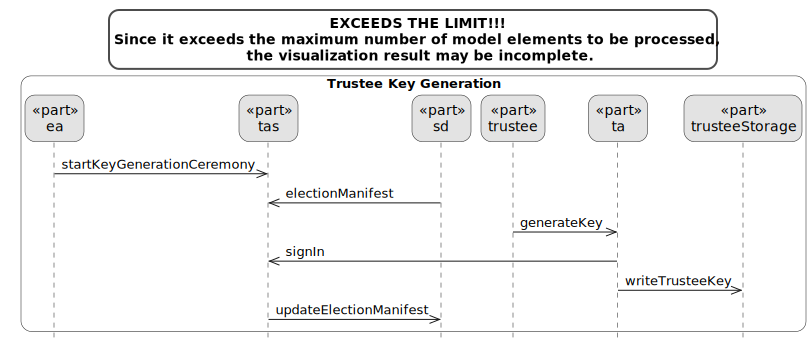

In [55]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Trustee Key Generation"

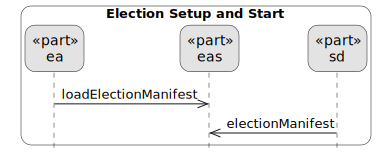

In [56]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Election Setup and Start"

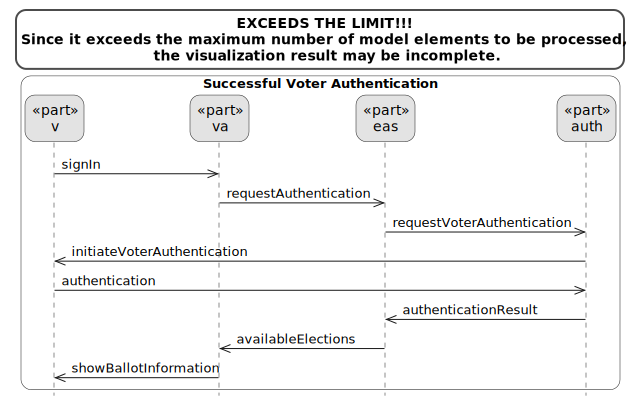

In [57]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Successful Voter Authentication"

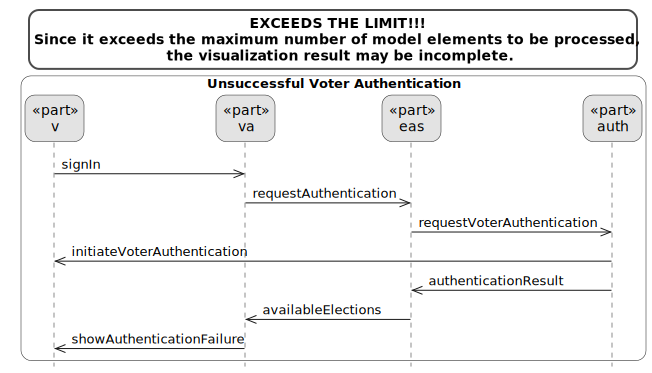

In [58]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Unsuccessful Voter Authentication"

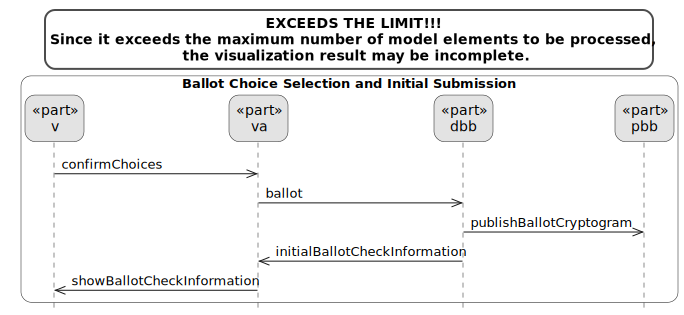

In [59]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Ballot Choice Selection and Initial Submission"

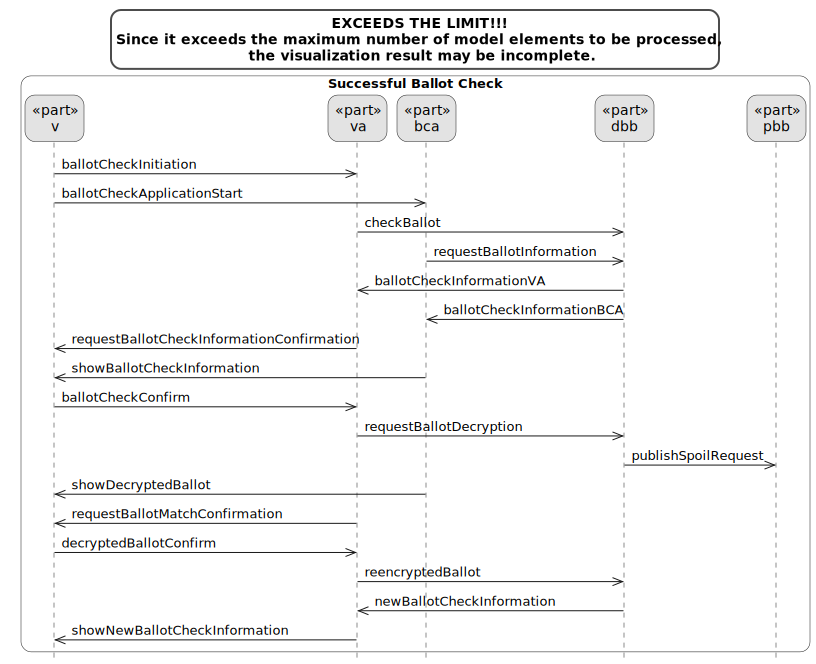

In [60]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Successful Ballot Check"

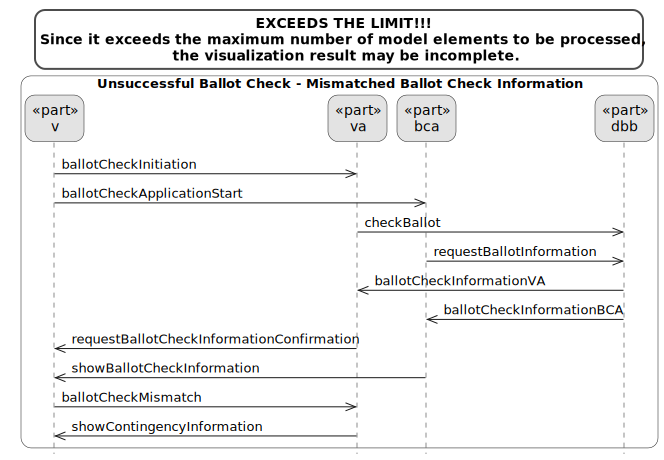

In [61]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Unsuccessful Ballot Check - Mismatched Ballot Check Information"

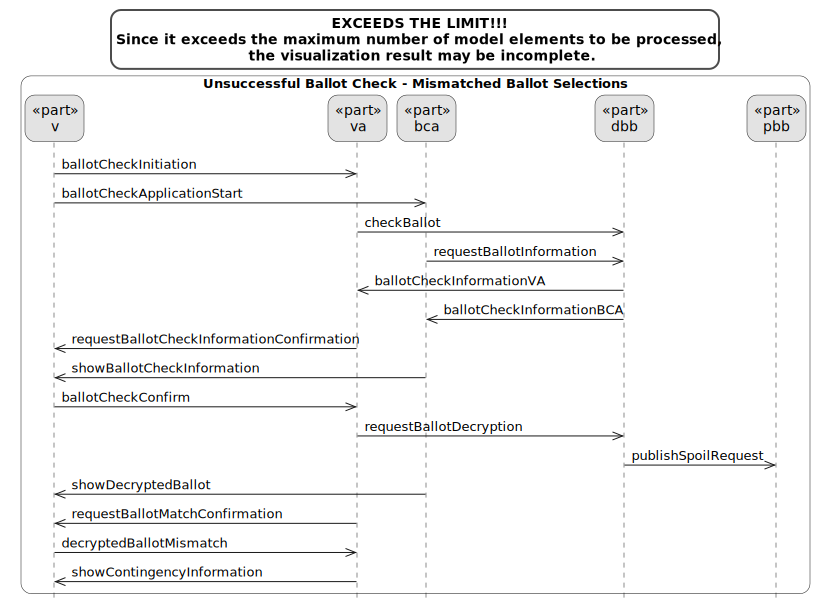

In [62]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Unsuccessful Ballot Check - Mismatched Ballot Selections"

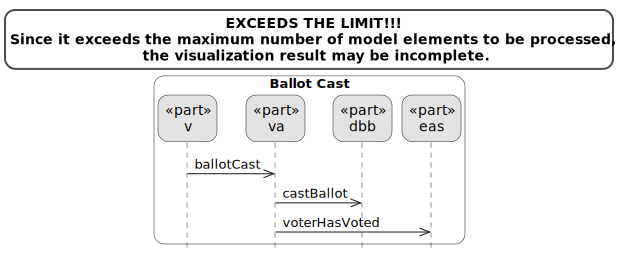

In [63]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Ballot Cast"

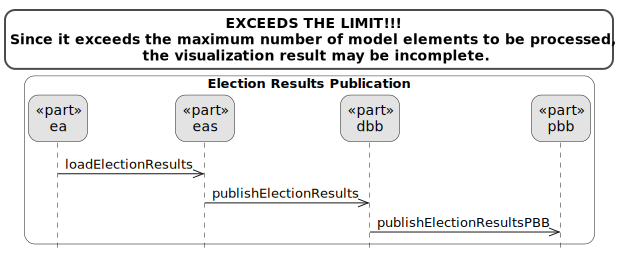

In [64]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Election Results Publication"

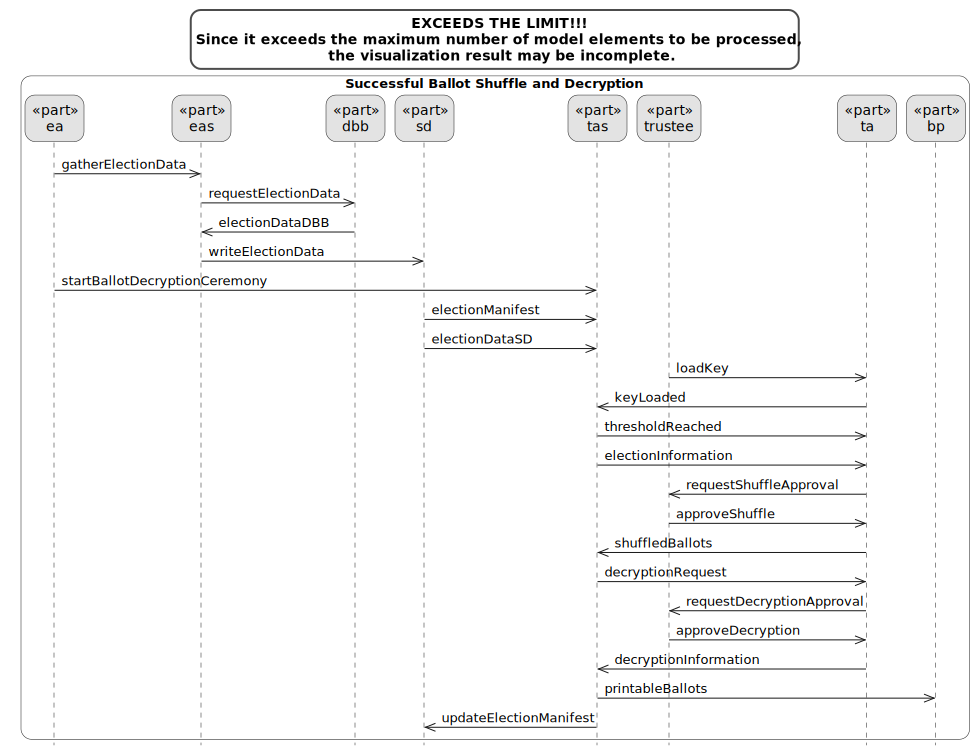

In [65]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Successful Ballot Shuffle and Decryption"

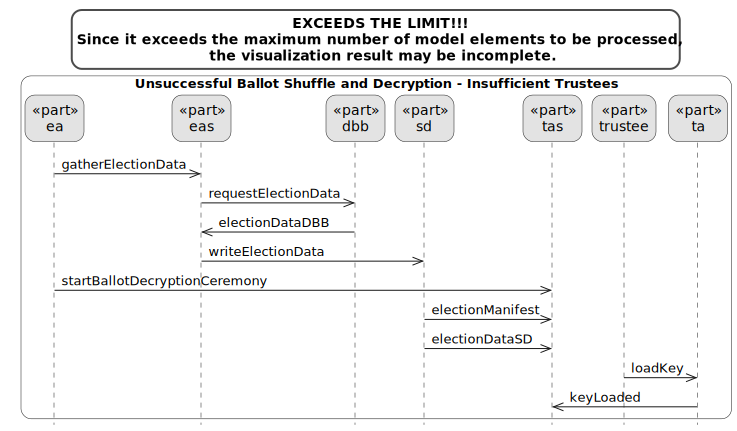

In [66]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Unsuccessful Ballot Shuffle and Decryption - Insufficient Trustees"

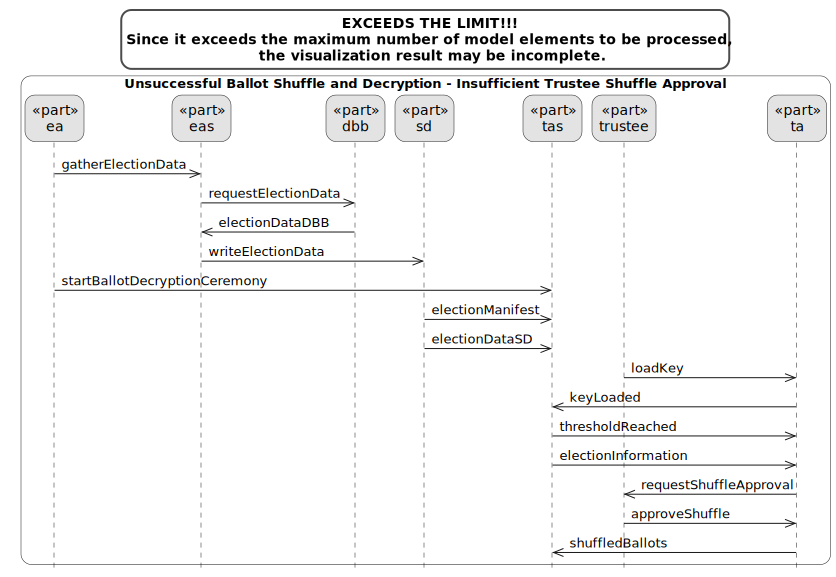

In [67]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Unsuccessful Ballot Shuffle and Decryption - Insufficient Trustee Shuffle Approval"

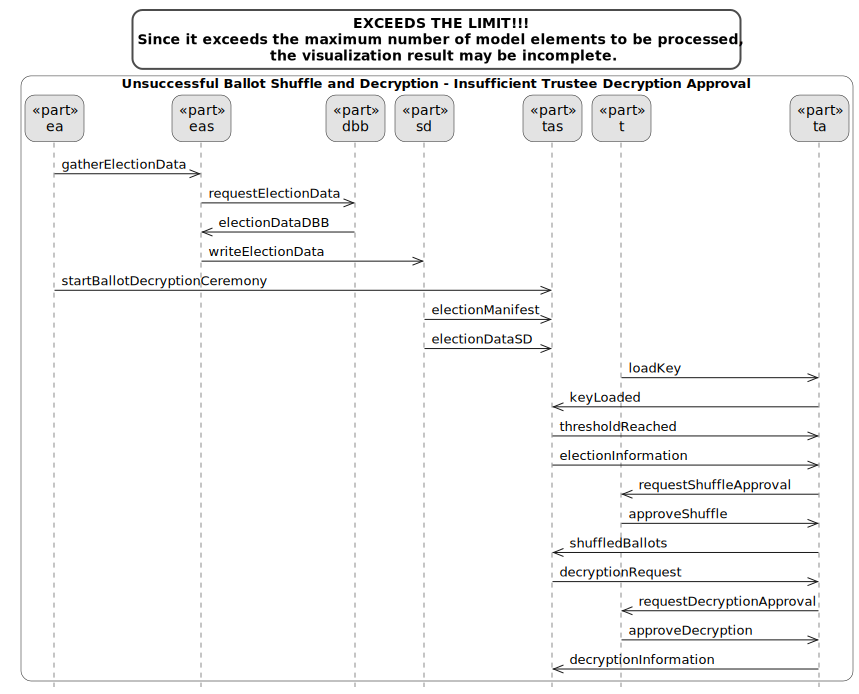

In [68]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Unsuccessful Ballot Shuffle and Decryption - Insufficient Trustee Decryption Approval"

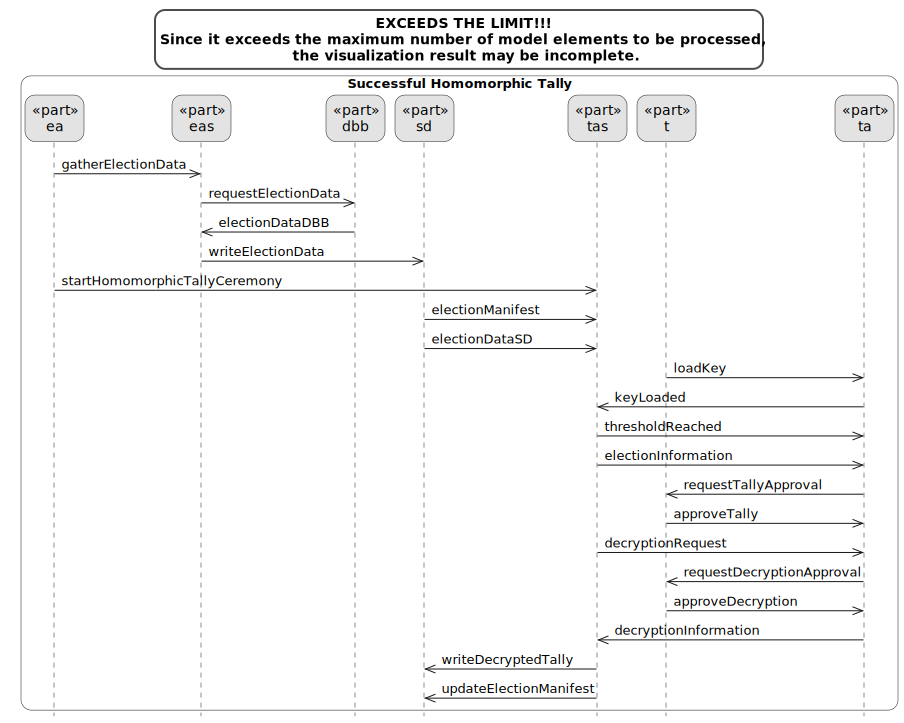

In [69]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Successful Homomorphic Tally"

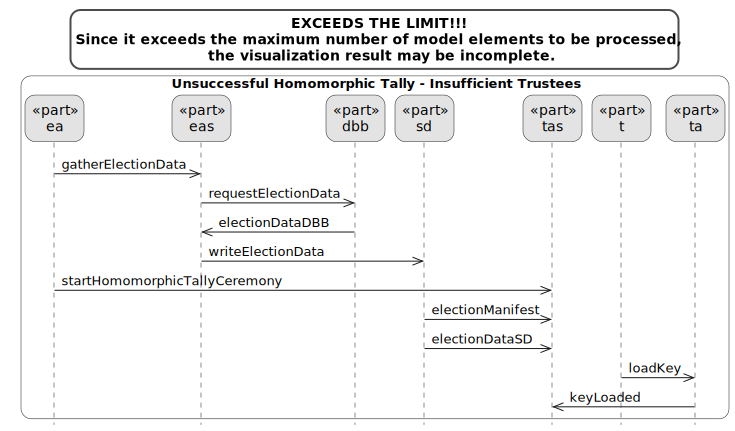

In [70]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Unsuccessful Homomorphic Tally - Insufficient Trustees"

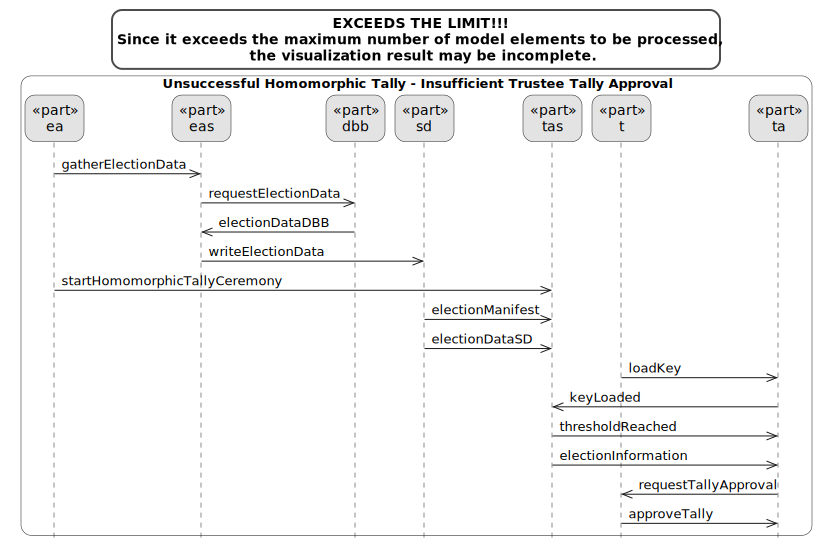

In [71]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Unsuccessful Homomorphic Tally - Insufficient Trustee Tally Approval"

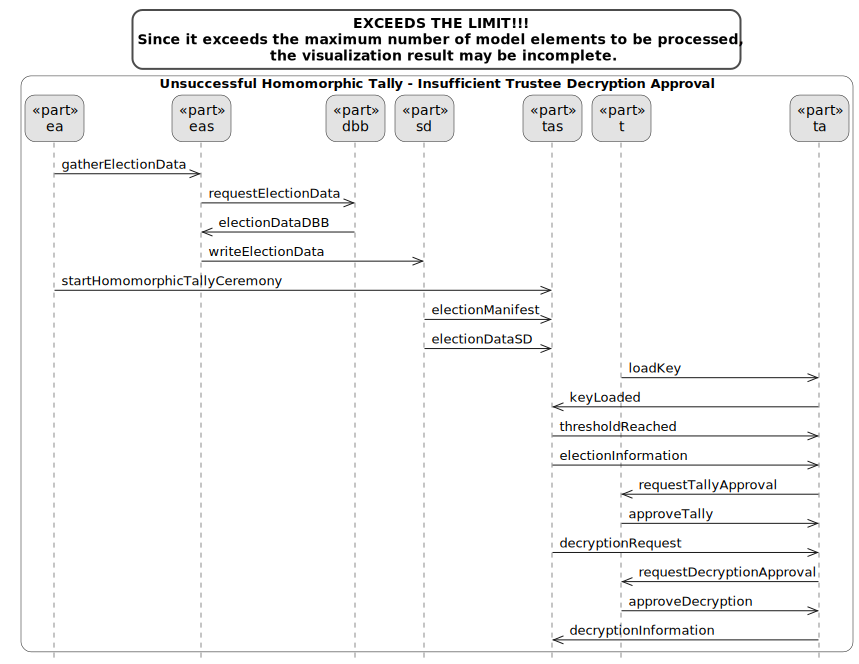

In [72]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Unsuccessful Homomorphic Tally - Insufficient Trustee Decryption Approval"

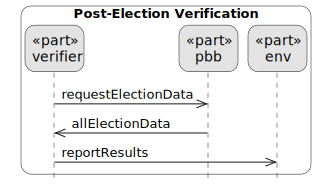

In [73]:
%viz --view=SEQUENCE "E2E-VIV Scenarios::Post-Election Verification"